# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Pulkit Jain, pj2313

Member 2: Greg Kocher, gk2500

Member 3: Ratheet Pandya, rp2707

In [435]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [491]:
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda: regularization parameter. Only required in part 2 of the assignment
        """
        np.random.seed(1)
        
        self.parameters = {
            'layerDimensions' : layer_dimensions
        }
        self.num_layers = len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda = reg_lambda
        
        self.iterations_finished = 0
        self.weights = []
        self.biases = []
        
        #FOr debugging
        self.training_accuracies = []
        self.validation_accuracies = []
        self.loss = []
        
                
        """
        other ideas for increased performance:
        - TA's suggested batchnorm layers
        
        Some that seem easy:
        - decaying learning rate (function of iteration number)
        - random crops/reflections[left-right only]/distortions of input data
        - other random initializations [Xavier, MSRA] - probably not have 
          much effect since we aren't using very deep network??
        
        - #self.reg_p_norm = 2 #If doing Lp norm regularization
        - other activation functions [ELU]
        """
        
        # init parameters
        
        
    def visualizeWeightsAndGradients(self,gradients):
        """
        Visualization tool for debugging
        """
        
        N = len(self.weights)
        r = int(np.ceil(np.sqrt(N))**2)
        
        fig=plt.figure()
        plt.title('Weights')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(self.weights[i].flatten())
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten())
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()        
        
        plt.figure()
        plt.title('Loss vs Iteration (x100)')
        plt.plot(self.loss,marker='o',color='b',label='Loss')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        plt.figure()
        plt.title('Accuracy vs Iteration (x100)')
        plt.plot(self.training_accuracies,marker='o',color='g',label='Train')
        #plt.plot(self.validation_accuracies,marker='o',color='r',label='Validation')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        
        
    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        Z = np.matmul(W, A) + b
        return Z
        

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return self.relu(A)


    def relu(self, X):
        A = np.maximum(0, X)
        return A

            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        rng = np.random.RandomState(123)
        M = rng.binomial(size=A.shape,
                            n=1,
                            p=1-prob)
        A *= M
        return A, M

    def forwardPropagation(self, X):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        A = X
        

        cache = {
            'biases' : [],
            'weights' : [],
            'dropoutMasks' : [],
            'affines' : [],
            'activations' : [A]
        }
        
        #After already done 1 iteration, reuse the weights and biases we learned:
        if self.iterations_finished > 0:
            cache['biases'] = self.biases
            cache['weights'] = self.weights
            #print(len(cache['weights']))
            #print(cache['weights'][0].shape)
            #print(cache['weights'][1].shape)
            #print(cache['weights'][2].shape)
        
        #same for below random initialization of W and b, are they being overwritten?
        
        for layer in range(1,self.num_layers):
            #On 1st training iteration only, randomly initialize weights and biases:
            if self.iterations_finished==0:
                W = np.random.normal(0., .1, size=(self.parameters['layerDimensions'][layer], self.parameters['layerDimensions'][layer - 1]))
                b = np.zeros(shape=(self.parameters['layerDimensions'][layer], 1))
            else:
                W = cache['weights'][layer-1]
                b = cache['biases'][layer-1]
            Z= self.affineForward(A, W, b)
            
            #So relu not applied to last layer:
            A = self.activationForward(Z) if layer==self.num_layers-1 else Z
            
            if self.drop_prob > 0:
                A, M = self.dropout(A,self.drop_prob)
                cache['dropoutMasks'].append(M)
            cache['affines'].append(Z)
            cache['activations'].append(A)
            
            if self.iterations_finished==0:
                cache['weights'].append(W)
                cache['biases'].append(b)    

        AL = A
        return AL, cache
    
    def costFunction(self, AL, y, cache):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param alpha: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """
        
        epsilon = 10e-9 #Since taking logs of very small numbers is giving infs
        S = y.size
        
        #Get softmax cost per sample:
        #(both numerators and denominators are length S vectors)
        #denominators = np.exp(AL).sum(axis=0)
        #numerators = np.array([np.exp(AL[y[i]-1,i]) for i in range(S)])#-1 is assuming class labels start at 1. If they start at 0, get rid of -1.
        #Actually will end up needing for gradients so just do as below...
        
        #print(AL)
        #print(AL.min())
        #print(AL.max())
        
        #print(np.exp(AL))
        #print(np.exp(AL).min())
        #print(np.exp(AL).max())
        
        softmax_out = np.exp(AL)/(np.exp(AL).sum(axis=0)+epsilon)
        #print(softmax_out)
        #print(softmax_out.min())
        #print(softmax_out.max())

        #Now get the cross-entropy / log-loss of this softmax:
        #cost is the average over all samples
        cost = (-1./S)*np.nansum(np.log(softmax_out))#+epsilon)) #Should deal with nans, but for now just use nansum...

        
        #Also get the regularization cost:
        if self.reg_lambda > 0.:
            # add regularization
            #If want to do other Lp norms as easy bonus:
            #in init: self.reg_p_norm = 2#int p for p-norm regularization
            #FOr now just using L2 norm:
            #||W||^2
            reg_cost = self.reg_lambda*np.array([np.sum(i.flatten()**2) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
        
        
        
        # gradient of cost
        #gradient through cross entropy, then sigmoid, turns out to be:
        #for a single trainign example:
        #dAL_i = sigmoid(z_i) - I(class==i);
        #when go over all training batch examples, 
        #take average over axis 1. Is just sigmoid out array, with certain elements -1.
        #Those elements are the ones corresponding to correct class label, for a given
        #training example:
        softmax_out[y,np.arange(S)] -= 1.
        #Sum over axis 1 and then scale by S, i.e. take mean over samples:
        #dAL = softmax_out.mean(axis=1)#actually since using 2D dropout mask,
        #don't do the averaging now. Leave as 2D matrix with axis1 size = S, the number of samples
        dAL = softmax_out
        
        #Since we don't use ReLU on last layer and treat it 
        #manually in this function by feeding it through softmax layer,
        #get rid of last layer activation here since we basically bypass 
        #the gradient calculation for this last layer and do it separately.
        #THen in the layers before this last one, can treat as usual.
        _ = cache['activations'].pop()
        #Same thing for dropout mask, if doing dropout:
        if self.drop_prob > 0.:
            _ = cache['dropoutMasks'].pop()
        
        return cost, dAL

    
    def affineBackward(self, dA_prev, cache, layer):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :layer : since you need to multiply by weights/biases
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        
        #print('layer',layer)
        
        S = cache['activations'][0].shape[1]
        
        #Use the derivative from the later layer
        #["previous" since goign in reverse]:
        #dA_prev
        
        W = cache['weights'][layer-1]
        dA = np.dot(W.T,dA_prev)
        #print(dA.shape)

        #If doing dropout:
        if self.drop_prob > 0.:
            #Sropout not used directly on input layer, even if mask is generated for it.
            if layer > 1:
                dA = self.dropout_backward(dA, cache)
        dA = self.activationBackward(dA, cache, None, activation="relu")
        
        #Repeat dA_prev since have S samples:
        #dW = np.dot(np.repeat(dA_prev.reshape((dA_prev.size,1)),S,axis=1),cache['activations'][-1].T)
        #Since dropout mask, just keep dA_prev in 2D [don't average over samples]
        dW = np.dot(dA_prev,cache['activations'][-1].T)
        #print(dW)
        #print(dW.min(),dW.max())
        #print(dW.shape)#(10,100)

        
        #If regularized, also add in gradients from reg cost:
        if self.reg_lambda > 0:
            dW += self.reg_lambda*W #For now assuming only L2 reg.
        
        #d_output / db = I(if i)
        db = np.ones(cache['biases'][layer-1].shape)
        
        
        #Now that done using the activations, get rid of them 
        #so indexing correct for next iterations:
        cache['activations'].pop()
        #print(len(cache['activations']))
        #print(cache['activations'][0].shape)

        return dA, dW, db

    
    
    def activationBackward(self, dA, cache, layer, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        cached_x = cache['activations'][-1]
        return self.relu_derivative(dA, cached_x)

        
    def relu_derivative(self, dx, cached_x):

        #S = cached_x.shape[1]
        #Repeat dx since have S samples:
        #dx = np.repeat(dx.reshape((dx.size,1)),S,axis=1)
        
        #In positive region, dx=1; in negative region = 0:
        dx = np.ones(cached_x.shape)*dx
        #Mask the negative region to 0.
        dx[cached_x <= 0.] = 0.
        #Could treat the exact ==0. case differently but to precision will never get ==0.
        
        #Average over axis 1 [averaged over samples]
        #dx = dx.mean(axis=1)#No longer do this since dropout mask
        return dx

    
    def dropout_backward(self, dA, cache):
        dA *= cache['dropoutMasks'].pop()
        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {
            'dW' : [],
            'db' : []
         }
        
        
        dA = dAL
        for layer in range(self.num_layers-1):
            dA, dW, db = self.affineBackward(dA,cache,self.num_layers-layer-1)
            gradients['dW'].append(dW) 
            gradients['db'].append(db) 
            
            #Was easier to just put inside affineBackward...
            #if self.drop_prob > 0:
            #    #If not working on the input layer (don't use dropout on it):
            #    if layer < self.num_layers-2 #-2 since: 
            #        self.dropout_backward(dA,cache)
           
        # TODO    
        #if self.reg_lambda > 0:
            # add gradients from L2 regularization to each dW
            #GK: I'm just adding them to dAL in the costfunction so should be ok w/o this here
        gradients['dW'].reverse()
        gradients['db'].reverse() 
        return gradients


    def updateParameters(self, gradients, alpha, cache):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        
        cache: to update the parameters we are learning [weights and biases],
        those values also need to be passed in.
        """
        
        #Weights
        #print(cache['weights'][0])
        #print(gradients['dW'][0].min())
        #print(gradients['dW'][0].max())
        cache['weights'] = [cache['weights'][i]  - alpha*gradients['dW'][i] for i in range(len(cache['weights']))] 
        #print(cache['weights'][0])
        #print(cache['weights'][0].max())
        #print(cache['weights'][0].min())

        #biases
        #print(cache['biases'][0])
        cache['biases'] = [cache['biases'][i]  - alpha*gradients['db'][i] for i in range(len(cache['biases']))] 
        #print(cache['biases'][0])
    
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        
        AL, _ = self.forwardPropagation(X)
        
        #Get probability per class per sample, then take argmax:
        #Technically don't need to go through softmax calculations, etc. since max here is max after too.
        #SO just get argmax for each sample:
        y_pred = np.argmax(AL,axis=0)

        print(y_pred)
        print(np.bincount(y_pred))
        #y_pred = [100, 200, 300]
        
        return y_pred

    
    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        selector = np.random.choice(np.arange(np.size(y)), batch_size, replace=False)
        return X[:, selector], y[selector]

    def train(self, X, y, iters=1000, alpha=0.0001, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X, y, batch_size)
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch)

            # compute loss
            cost, dAL = self.costFunction(AL, y_batch, cache)
            #print('cost',cost)
            
            # TODO compute gradients
            gradients = self.backPropagation(dAL, y_batch, cache)
            #print('gradients',gradients,len(gradients['dW']),gradients['dW'][0].shape)

            # TODO update weights and biases based on gradient
            #print('alpha',alpha)
            self.updateParameters(gradients, alpha, cache) #will update weights + biases in place

            
            #Store the weights and biases that were just updated: 
            self.weights = cache['weights']
            self.biases = cache['biases']
            #print(len(self.weights))
            #print(len(self.biases))
            #print(self.weights[0].shape)
            #print(self.biases[0].shape)
            
            
            if i % print_every == 0:
                # TODO compute + print cost, train and validation set accuracies
                y_batch_predicted = self.predict(X_batch)
                train_accuracy = (y_batch_predicted==y_batch).sum()/np.float(batch_size)
                validation_accuracy = '--'
                print('cost: {0}, train accuracy: {1}, validation accuracy: {2}'.format(
                    cost, train_accuracy, validation_accuracy))
                
                self.training_accuracies += [train_accuracy]
                self.validation_accuracies += [validation_accuracy]
                self.loss += [cost]
                
                
                

            
            #For debugging, look at weights and gradients on weights
            if i % 100 == 0:
                self.visualizeWeightsAndGradients(gradients)
            
            #Just some counter which is only used to make sure this isn't the first iteration
            #since on 1st iteration only we randomly initialize params.
            self.iterations_finished += 1
            print(self.iterations_finished)
            print('\n')

In [28]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [35]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:#[:20000]:#!!!!!!! changed for memory issues, but change this back to "files:"
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [36]:
# Load the data
data_root_path = '/Users/ratheet/coms4995-deeplearning/HW1/git/cifar10-hw1/'
data_root_path = '.././cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


## Part 1

#### Simple fully-connected deep neural network

[2 6 6 2 2 2 6 6 6 6 9 6 6 6 2 6]
[ 0  0  5  0  0  0 10  0  0  1]
cost: 43.803813332570854, train accuracy: 0.125, validation accuracy: --
Weights 0 Mean -0.000967806769693 SD 0.100866611189
Weights 1 Mean -0.000817150026955 SD 0.227929595429
Weights 2 Mean -0.00549602069417 SD 1.02256047475


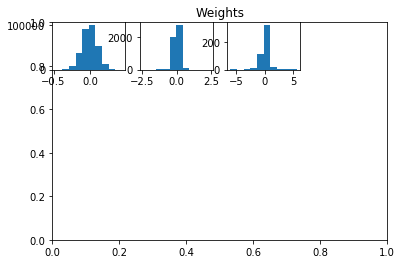

dW 0 Mean 0.00982917973043 SD 0.131685019119
dW 1 Mean -0.00467258463684 SD 2.07826263206
dW 2 Mean -1.05875841427e-11 SD 10.2984322823


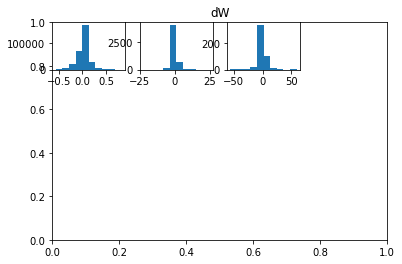

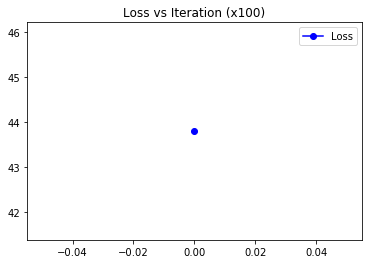

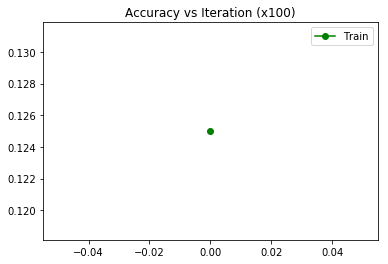

1


2


3


4


5


6


7


8


9


10




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:217: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:224: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in maximum
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in less_equal


In [492]:
layer_dimensions = [X_train.shape[0], 100, 50, 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, iters=10, alpha=0.1, batch_size=16, print_every=10)#change back batch_size=10 #!=10 to debug not square

In [29]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [30]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

(3,)


array([100, 200, 300])

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

[2 6 6 4 7 8 6 2 1 4 6 0 6 6 7 5 6 6 6 7 7 6 6 8 6 2 6 1 6 6 7 1 2 6 6 6 6
 7 7 6 1 6 2 6 6 1 6 5 4 1 7 2 6 2 7 2 6 6 6 6 1 6 2 1 2 7 4 6 2 6 7 4 7 2
 2 5 9 9 6 2 9 2 2 7 7 6 8 6 7 6 6 7 6 2 7 2 6 2 2 6 5 2 9 7 5 5 2 6 2 2 2
 2 6 2 8 5 2 6 2 6 6 6 9 2 6 2 6 7 7 6 1 1 2 6 1 2 6 2 6 6 7 2 6 4 7 6 2 5
 3 2 2 2 6 2 3 2 6 4 6 2 2 7 7 6 6 2 5 2 6 8 7 6 1 7 6 6 2 6 5 5 6 1 1 2 1
 1 2 2 2 7 6 2 7 2 6 7 2 4 2 6 6 0 7 7 6 6 2 6 6 6 6 2 6 6 7 6 8 9 3 6 2 2
 9 3 6 2 2 6 2 6 5 4 2 2 6 5 6 6 6 7 0 7 2 6 1 2 2 7 4 6 2 0 6 2 2 6 7 2 5
 6 6 2 7 6 2 6 2 6 6 2 6 6 0 2 6 2 1 2 2 6 6 2 4 2 7 6 6 7 6 7 2 6 6 6 2 6
 6 2 4 6 2 1 4 6 0 2 2 4 2 2 2 6 6 6 9 2 2 4 6 0 9 7 1 9 2 2 1 6 8 7 0 2 6
 1 2 6 6 6 6 6 6 7 9 6 6 6 6 0 4 6 0 6 9 5 2 2 1 2 1 6 2 2 0 6 4 6 2 2 7 6
 2 6 2 5 6 6 1 2 2 7 6 6 2 6 6 9 6 2 1 6 2 2 6 2 2 2 2 2 6 2 6 6 1 6 2 6 6
 2 1 6 6 5 6 6 6 6 7 6 6 7 8 2 2 6 6 6 2 0 6 7 1 2 1 6 6 2 6 6 5 6 6 8 2 6
 1 6 2 2 2 6 6 9 2 1 7 2 6 7 7 5 2 2 1 9 9 2 2 6 6 4 7 4 2 7 6 8 5 6 4 2 9
 7 2 1 4 7 2 0 2 2 2 6 4 

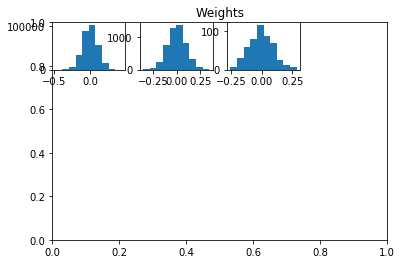

dW 0 Mean 0.417688994045 SD 2.06148332995
dW 1 Mean 0.0578655584003 SD 30.0321121616
dW 2 Mean -5.49612269716e-05 SD 165.280094047


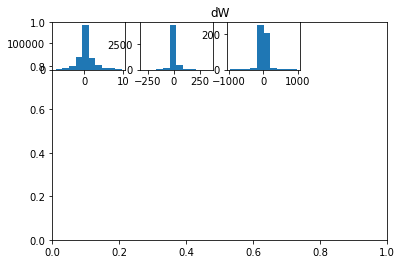

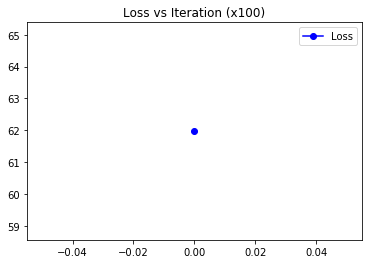

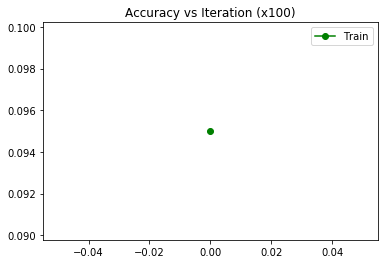

1


2


3


4


5


6


7


8


9


10


[6 1 9 7 9 0 5 1 9 9 8 8 0 0 1 4 4 0 1 7 7 6 6 1 7 8 2 9 6 0 7 6 6 1 4 4 2
 4 6 5 4 0 3 2 2 2 8 5 4 2 8 6 7 7 2 0 5 2 6 1 3 0 7 9 8 8 9 6 3 0 7 9 0 6
 0 8 0 0 0 2 4 2 0 7 9 3 0 2 5 9 6 4 9 7 3 0 4 8 1 0 2 3 5 6 6 0 3 0 3 4 5
 7 8 1 0 0 9 7 2 8 5 3 2 9 3 8 0 3 5 0 3 0 9 2 7 6 0 9 8 0 0 0 8 0 6 5 9 0
 3 2 0 5 0 0 3 6 0 6 8 8 0 8 0 7 6 9 0 6 3 4 8 0 8 4 1 1 3 2 1 0 8 9 0 5 0
 1 1 2 5 7 6 5 4 5 9 9 7 8 0 7 6 5 3 7 3 9 9 6 6 7 1 5 8 9 3 6 3 7 3 7 0 5
 9 3 5 0 3 2 7 6 0 5 0 5 2 7 4 7 2 6 2 7 4 3 2 0 2 0 5 9 7 1 0 9 5 6 5 1 6
 6 8 5 6 7 6 0 7 2 1 2 2 7 9 3 6 9 8 6 9 0 9 8 9 5 0 0 6 1 7 5 9 9 3 4 2 8
 8 6 9 2 9 4 0 2 5 5 4 0 0 2 0 1 9 0 0 2 0 9 7 8 7 2 5 8 0 3 3 6 2 8 4 4 4
 8 9 2 8 9 0 9 6 3 0 7 7 2 0 2 3 7 8 7 0 7 8 2 3 6 4 8 6 3 0 6 4 6 4 0 8 0
 5 1 3 8 8 9 8 1 8 0 8 6 0 1 9 8 6 3 8 7 1 0 8 1 4 5 8 6 3 2 6 4 2 0 2 6 1
 7 5 0 8 0 3 5 2 5 2 3 6 7 7 2 7 3 9 2 5 2 9 0 9 0 9 8 6 9 7 6 0 5 8 5 5 2
 6 5 3 5 9 4 0 4 5 6 7 7 0 0 9 5 5 7 7 3 1 0 9 0 0 5 0 6 2 

42


43


44


45


46


47


48


49


50


[5 1 4 1 8 5 8 1 6 1 9 8 3 9 1 3 4 1 1 7 8 3 5 1 7 9 0 8 9 0 1 2 3 0 9 3 6
 4 4 5 9 0 0 1 2 0 7 5 4 1 4 6 7 7 2 4 9 2 6 0 3 0 2 0 6 8 9 5 2 5 4 4 0 6
 7 7 0 9 3 2 2 2 9 1 2 7 5 6 6 9 8 7 9 1 3 0 8 9 4 5 6 0 0 6 6 4 3 2 3 2 2
 7 4 1 5 8 9 3 2 8 2 3 2 1 1 2 1 5 5 5 3 0 7 6 7 6 0 9 6 7 2 3 4 1 6 5 9 3
 0 6 0 5 5 8 3 7 0 9 4 8 3 4 0 1 0 6 5 2 1 0 8 0 8 4 1 1 1 2 1 1 6 1 2 7 0
 8 1 2 2 7 0 5 4 5 2 8 2 5 2 7 6 4 3 3 3 2 9 3 6 7 1 5 8 3 8 6 3 8 3 4 0 8
 9 4 8 0 3 8 2 6 0 5 8 5 2 7 0 5 8 6 2 7 3 7 7 0 8 0 7 5 7 8 0 9 1 1 8 1 5
 1 0 0 4 7 0 0 0 1 7 0 1 9 5 6 6 6 8 6 9 7 5 5 9 8 3 1 8 1 8 5 8 2 8 4 6 8
 8 6 5 2 8 7 7 9 8 8 9 4 0 0 8 1 0 0 0 8 2 5 1 8 7 1 5 8 0 2 0 6 8 7 4 4 7
 8 4 2 8 5 1 6 6 1 1 7 6 8 6 2 3 8 8 8 0 4 4 5 7 6 7 4 6 7 7 6 8 7 0 0 0 1
 5 4 6 8 2 9 8 0 8 5 2 5 0 1 5 4 6 3 2 7 8 9 4 3 3 7 5 0 2 2 9 4 5 7 8 3 1
 4 7 8 7 0 5 2 2 4 7 0 5 3 8 2 2 2 9 2 5 2 8 4 0 7 8 4 0 9 6 6 0 5 8 8 5 6
 2 2 3 5 1 9 1 9 4 1 7 7 1 6 9 5 5 3 8 2 1 8 9 3 0 6 1 

82


83


84


85


86


87


88


89


90


[0 6 9 1 1 5 8 0 4 7 6 2 3 3 1 5 0 9 0 7 7 3 1 7 1 9 4 9 6 0 5 6 6 2 8 6 8
 4 4 9 9 0 3 2 7 7 6 3 1 2 4 6 7 7 2 4 4 2 6 0 0 3 2 8 4 8 7 8 2 6 7 8 7 6
 7 8 5 0 8 2 9 2 9 7 2 5 2 6 4 9 1 4 4 9 4 0 8 2 4 1 2 3 8 6 6 8 9 7 3 9 8
 7 4 6 2 6 3 3 8 8 5 3 9 5 3 2 1 1 2 4 8 4 1 6 1 6 6 9 0 7 5 3 4 8 5 5 2 7
 7 6 0 5 7 0 3 0 7 9 1 2 3 8 0 0 3 8 5 5 3 3 8 1 8 4 1 1 1 8 0 7 6 9 1 7 0
 3 4 2 2 7 6 5 3 5 5 4 2 8 2 6 6 4 2 7 3 2 4 4 7 3 8 5 6 3 8 6 3 3 3 8 0 4
 1 9 4 0 3 5 2 2 3 7 3 6 3 7 4 2 8 3 2 7 4 1 7 6 8 0 5 3 7 8 7 4 1 6 5 2 4
 2 8 0 4 7 6 0 7 0 7 0 8 9 4 1 6 4 2 9 6 7 9 2 9 1 6 1 3 1 4 5 4 2 4 6 2 8
 8 3 4 2 0 4 0 9 8 8 7 9 2 2 8 1 5 7 2 8 8 9 0 4 0 0 5 4 9 8 3 3 2 3 4 8 7
 3 9 0 0 5 5 5 2 7 4 1 5 4 5 2 3 8 8 8 0 4 3 5 0 7 2 2 6 7 7 6 9 6 0 0 0 7
 5 9 0 2 2 0 8 1 8 6 8 9 3 1 7 4 6 3 1 8 2 2 9 4 3 5 8 0 6 2 6 4 8 0 1 6 1
 2 5 3 6 0 3 2 2 2 1 0 5 3 8 2 7 3 9 1 9 2 4 4 0 7 8 4 1 7 3 4 3 0 8 2 5 6
 0 2 6 5 7 4 9 4 4 1 3 7 7 3 9 7 5 7 5 3 7 2 9 0 0 6 0 

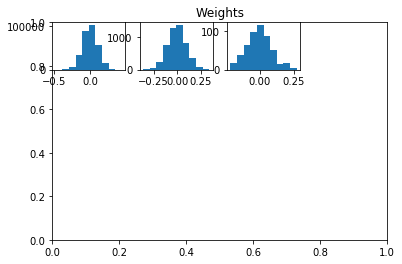

dW 0 Mean 0.0349521405516 SD 0.363842316926
dW 1 Mean -0.0536468151648 SD 4.140348679
dW 2 Mean -5.49319443946e-05 SD 23.2066382091


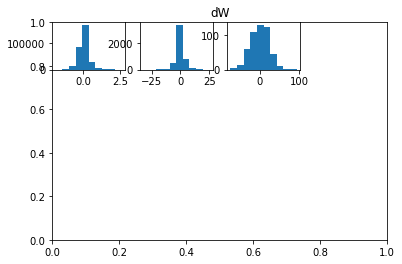

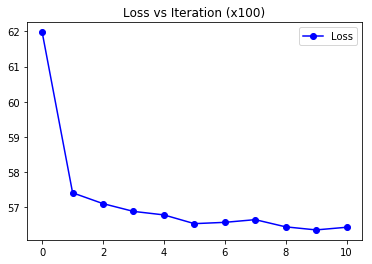

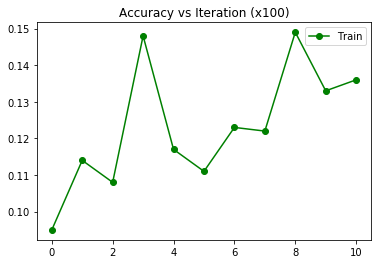

101


102


103


104


105


106


107


108


109


110


[5 0 3 7 8 0 1 1 4 9 9 9 6 3 7 2 8 9 0 1 7 2 5 1 7 9 1 8 0 0 5 6 6 4 8 8 5
 7 6 5 9 0 7 2 7 7 3 5 4 2 1 6 8 6 2 0 0 0 6 4 8 0 2 9 1 8 9 2 2 0 4 4 0 0
 7 8 9 8 8 2 4 3 9 1 8 5 5 6 0 4 6 5 2 3 6 2 6 9 9 5 0 3 8 6 6 8 8 4 3 2 2
 7 4 1 3 8 9 4 2 8 9 3 0 1 2 8 1 4 5 0 6 9 1 8 3 7 0 9 8 6 6 3 4 1 8 5 8 8
 7 6 1 5 0 9 3 0 0 8 5 8 3 8 2 7 6 6 9 2 3 8 8 0 4 7 1 0 1 6 1 1 8 9 1 5 0
 3 6 2 5 7 6 8 0 7 8 4 0 7 8 7 6 4 2 3 6 2 9 0 6 2 1 5 1 3 8 6 4 1 3 8 6 8
 9 9 5 2 8 7 2 6 6 7 8 5 2 7 4 5 8 6 2 7 4 1 4 1 8 0 5 1 2 8 7 2 5 6 6 2 9
 6 9 0 4 6 6 7 5 8 5 7 1 9 4 4 6 8 2 9 9 0 6 5 4 5 0 1 6 1 6 1 8 5 7 5 6 7
 8 7 4 2 9 4 3 3 8 8 9 0 0 1 8 1 7 3 0 2 8 9 7 8 0 0 5 8 0 7 3 2 8 3 8 8 5
 6 8 0 5 3 5 5 8 3 1 2 6 9 5 1 3 2 7 1 0 7 6 5 7 6 8 8 6 7 7 6 4 6 4 6 0 0
 5 1 6 4 2 3 4 1 8 5 8 6 3 1 8 4 4 3 8 8 8 6 7 4 8 5 8 5 6 2 0 4 5 0 3 8 1
 6 1 6 3 5 7 5 2 2 2 0 5 2 7 7 2 7 3 9 9 6 8 4 0 8 9 6 0 9 3 6 1 5 4 4 5 6
 0 2 3 8 6 9 1 4 8 1 7 8 5 6 5 2 5 7 7 3

143


144


145


146


147


148


149


150


[5 6 2 4 9 1 2 1 9 9 9 1 0 3 1 2 0 9 1 7 7 6 1 0 7 9 0 8 9 0 5 6 6 0 8 0 8
 4 6 5 4 0 0 2 8 2 7 3 4 2 7 3 7 7 2 9 9 2 6 0 3 3 7 5 4 8 9 6 2 6 8 8 0 8
 7 8 0 0 8 2 4 1 9 5 2 5 0 5 0 9 6 5 4 9 3 0 8 4 9 1 2 4 5 6 6 7 1 0 3 8 8
 5 4 1 1 6 9 2 2 6 9 3 2 5 2 8 0 8 5 0 0 4 9 6 1 2 6 0 8 0 0 3 8 1 9 5 9 7
 7 5 0 7 5 0 3 5 7 9 4 2 3 8 3 5 3 2 5 6 3 4 8 1 8 4 5 1 8 6 0 1 1 9 8 5 6
 3 1 2 8 7 2 4 0 7 3 7 2 5 8 7 6 7 3 5 6 2 7 0 6 6 3 5 7 9 3 6 8 0 9 2 6 6
 2 9 4 0 3 7 2 7 0 5 1 5 2 7 4 5 1 6 2 7 4 7 5 7 8 9 5 3 7 8 7 9 4 9 8 2 6
 0 3 0 8 9 6 1 7 0 1 2 5 8 9 4 6 0 5 4 6 0 1 8 4 5 7 1 3 1 6 5 8 5 8 6 5 8
 8 6 1 2 9 4 4 9 5 9 7 4 9 2 9 1 1 7 8 9 7 7 1 8 4 2 5 8 0 0 3 6 5 3 8 4 0
 6 8 2 8 3 5 0 8 7 1 1 6 8 5 2 4 3 7 5 0 5 8 5 5 8 4 5 2 3 0 6 9 0 8 6 8 1
 9 9 4 7 2 8 9 1 8 0 8 8 3 1 8 4 5 9 2 5 4 9 3 3 0 4 8 6 0 2 3 4 1 2 3 9 1
 6 7 4 3 0 5 5 2 4 2 9 3 6 7 7 7 3 3 8 9 7 9 0 6 8 8 6 8 7 8 4 3 5 6 7 5 6
 0 2 8 5 7 9 1 9 5 1 8 7 7 6 0 5 5 7 7 3 7 2 6 6 0 8

183


184


185


186


187


188


189


190


[5 1 9 4 8 0 1 9 8 2 4 7 1 6 6 8 0 0 1 7 7 9 1 0 4 4 0 7 0 0 5 9 1 0 8 0 3
 3 7 0 9 0 3 1 7 0 7 9 0 2 4 5 8 4 7 7 0 2 1 6 3 0 7 0 4 8 4 7 2 0 8 8 0 6
 7 5 5 0 8 7 4 5 7 5 8 5 0 7 0 2 5 7 8 9 3 0 9 4 9 1 2 1 8 6 6 4 9 6 6 2 2
 6 4 5 5 0 9 2 4 4 9 3 2 1 6 2 0 5 5 2 4 4 9 2 1 2 9 4 8 7 0 3 8 1 2 5 2 8
 8 5 0 5 5 0 3 0 0 9 4 2 3 8 0 5 6 2 0 6 1 0 8 2 5 5 8 0 1 3 1 1 0 9 3 5 0
 3 1 5 8 7 0 8 3 0 9 4 2 8 6 6 6 1 3 1 5 2 7 4 8 7 8 5 8 3 3 6 4 4 3 2 3 2
 2 9 8 0 3 5 2 2 6 5 2 7 2 7 8 5 9 0 8 7 4 1 8 5 2 0 5 5 9 1 1 3 9 7 8 2 5
 1 6 0 4 6 2 1 2 1 7 7 2 9 3 0 6 8 2 6 2 7 2 9 9 8 9 0 8 1 2 5 6 5 4 6 6 8
 8 7 1 5 4 1 4 3 5 9 7 5 3 0 1 1 0 7 8 2 4 9 1 0 5 0 5 4 0 1 3 8 7 8 4 4 7
 3 9 0 5 8 8 0 6 1 4 0 0 9 5 2 3 8 8 3 2 5 3 7 0 8 4 2 6 2 7 6 4 0 4 2 7 4
 6 5 0 4 2 9 4 6 2 0 9 8 6 4 8 4 4 9 2 7 7 9 3 7 5 7 0 6 6 9 3 6 5 0 3 6 1
 2 1 4 8 0 5 6 8 4 2 2 3 6 8 4 7 2 9 8 6 7 9 0 0 7 7 4 1 9 1 6 5 5 8 7 5 6
 0 7 8 5 7 4 5 4 5 6 6 7 2 3 9 5 9 6 5 3 7 0 9 0 0 5

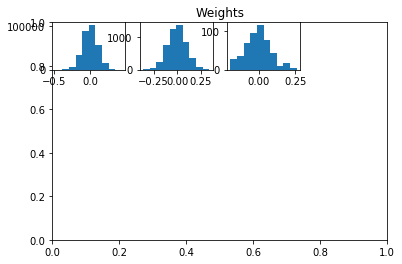

dW 0 Mean -0.0167475826377 SD 0.403229198242
dW 1 Mean 0.022922879065 SD 4.5477430437
dW 2 Mean -5.49223884909e-05 SD 24.630510419


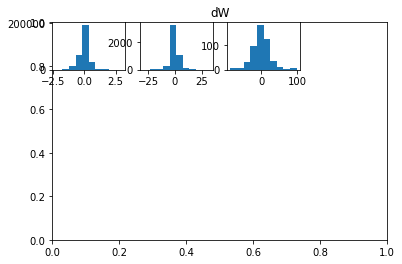

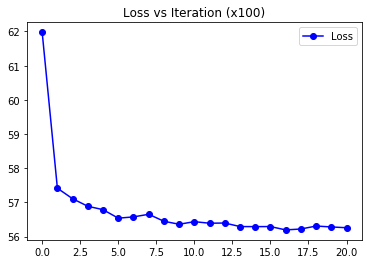

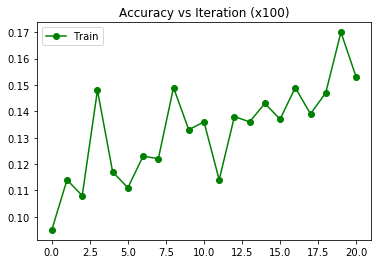

201


202


203


204


205


206


207


208


209


210


[1 5 3 5 5 4 8 2 8 0 4 7 1 3 6 3 4 9 1 7 9 2 1 0 3 4 7 7 9 0 7 6 9 0 4 8 3
 8 9 0 6 0 0 6 7 7 7 3 4 8 8 3 8 4 2 4 5 0 1 0 3 3 7 5 5 8 7 2 0 7 8 8 0 4
 7 9 9 0 0 2 9 2 7 1 2 7 5 5 6 8 5 7 4 3 5 0 4 2 0 7 2 3 0 6 6 4 9 0 7 4 2
 7 4 1 1 3 9 8 8 8 5 3 2 9 3 2 0 5 2 2 4 9 9 8 3 3 0 4 6 6 0 2 8 1 9 5 2 7
 3 5 1 7 5 9 6 0 6 6 2 2 9 5 2 1 6 2 0 2 9 3 8 2 8 4 9 4 1 7 0 8 1 9 3 5 9
 4 1 2 3 6 6 5 0 0 8 4 5 2 0 7 6 5 3 3 6 0 4 4 6 6 8 5 7 3 3 6 3 3 9 2 9 2
 2 9 5 3 3 2 2 2 6 0 8 5 2 7 0 6 9 3 8 3 6 1 4 6 8 0 5 9 7 0 1 2 1 1 5 2 9
 0 8 0 6 7 0 1 3 2 8 2 6 9 5 2 6 8 8 9 2 4 9 2 9 1 0 1 3 3 8 1 4 9 4 6 0 8
 8 7 9 5 9 1 3 8 8 1 9 8 1 6 9 1 1 0 8 8 4 9 1 8 9 2 5 4 0 8 3 6 3 3 8 9 0
 3 9 0 6 3 5 0 8 1 4 7 6 9 8 2 3 2 6 5 6 4 5 5 3 7 4 5 4 7 3 6 9 7 8 6 0 0
 5 5 0 5 1 8 9 8 8 0 9 1 1 1 9 4 4 3 2 5 2 9 9 9 0 5 5 6 7 6 6 6 5 2 3 0 1
 6 5 4 3 5 5 2 0 8 2 0 5 6 7 4 7 2 9 9 8 2 9 4 2 7 9 4 1 9 7 6 1 0 4 5 5 2
 0 2 8 5 7 3 5 9 5 6 1 0 7 8 0 5 5 6 5 5

243


244


245


246


247


248


249


250


[6 0 9 5 2 5 2 9 8 9 9 8 3 9 6 3 0 2 6 5 1 3 1 0 3 9 1 8 9 9 5 6 9 0 7 8 8
 8 4 9 9 6 0 0 3 5 6 9 1 2 5 6 8 7 2 9 6 0 6 0 0 0 7 0 4 1 7 2 7 1 0 2 8 7
 0 8 0 3 3 2 4 5 7 5 9 3 4 3 6 4 9 3 8 9 3 2 8 9 2 3 5 3 5 0 6 4 5 9 3 3 8
 7 8 5 1 6 9 2 2 6 9 3 9 9 2 5 1 9 2 0 7 0 9 6 1 3 3 9 3 6 0 2 4 1 9 5 2 2
 3 5 3 7 5 9 3 7 3 6 4 2 3 3 0 1 6 6 9 2 5 3 8 6 8 1 6 5 8 3 5 7 0 9 1 7 9
 8 3 2 3 7 6 5 8 5 4 8 0 5 2 5 0 5 3 7 6 2 7 0 6 3 8 5 8 3 3 6 7 5 3 8 8 5
 5 9 8 2 1 5 2 6 0 7 9 5 2 7 0 2 9 6 7 9 4 2 3 6 2 6 5 5 3 2 7 9 5 1 5 2 9
 0 5 0 4 6 6 1 0 2 8 7 2 8 4 6 6 4 2 9 9 7 6 1 1 5 9 7 3 1 6 9 8 5 8 6 6 8
 8 7 8 5 0 1 4 0 8 2 9 5 9 2 3 5 7 0 5 8 8 5 0 3 9 2 5 4 0 3 3 8 5 8 4 5 7
 3 5 1 6 5 5 5 5 7 8 0 6 3 5 2 3 8 0 8 0 5 5 7 1 8 4 5 6 2 8 6 5 6 8 1 0 7
 9 5 5 7 7 2 9 9 2 9 8 3 3 1 6 4 6 9 7 2 2 9 8 7 9 9 8 6 3 9 3 6 5 8 8 3 1
 2 5 9 3 5 3 5 0 8 2 4 6 6 5 4 7 3 3 2 3 6 3 4 9 7 9 6 3 7 3 6 5 9 4 1 5 2
 0 2 9 8 1 9 9 4 5 1 7 7 5 3 4 7 7 6 2 3 9 8 8 4 1 9

283


284


285


286


287


288


289


290


[1 6 8 1 2 4 2 2 5 9 9 9 6 9 7 3 6 9 0 1 9 2 1 1 7 4 5 0 9 0 5 6 9 6 4 8 6
 8 6 9 9 5 0 2 9 3 7 3 4 8 8 6 3 6 7 5 4 0 1 1 3 0 2 8 4 8 9 8 3 6 1 2 0 6
 4 5 5 3 3 2 9 1 9 6 8 7 5 5 4 4 1 7 5 2 3 0 6 9 4 3 2 0 3 6 6 0 9 2 3 4 2
 8 8 8 3 5 9 2 2 6 5 3 1 9 4 8 1 7 2 3 0 0 2 6 6 3 9 0 0 6 0 8 4 6 2 5 2 2
 7 5 9 5 5 7 3 7 0 8 4 2 9 3 5 1 5 6 5 8 6 3 8 6 5 1 1 0 1 4 0 7 8 3 3 9 1
 3 3 0 5 7 6 8 0 5 9 9 0 2 2 1 6 1 3 3 6 2 4 0 6 5 1 5 4 8 5 6 8 3 4 8 3 5
 2 9 8 0 9 8 2 6 6 5 8 5 9 7 8 5 8 3 2 7 4 1 2 5 2 6 5 6 7 0 1 0 5 6 5 2 4
 5 6 0 6 1 6 0 5 8 8 0 8 5 9 0 6 4 5 8 9 9 1 9 4 8 6 9 6 7 2 1 4 6 8 1 2 8
 8 7 7 0 8 0 4 3 5 6 9 8 3 2 0 1 5 3 0 8 2 5 0 0 0 5 5 9 0 9 3 2 3 8 8 8 4
 6 9 6 8 8 5 2 6 7 4 2 1 9 8 8 3 5 0 7 2 5 6 5 5 4 7 8 2 7 0 6 5 6 1 6 0 1
 9 8 0 7 2 8 5 6 9 0 6 6 0 1 5 4 0 9 0 5 4 6 9 7 3 7 8 6 0 6 3 4 5 5 5 8 1
 2 7 9 8 5 5 5 2 4 2 2 5 6 7 4 2 8 3 9 7 2 3 0 5 8 8 4 1 6 1 2 5 5 4 1 5 2
 9 7 8 5 1 9 9 4 0 1 3 7 1 6 0 7 5 6 7 2 7 2 1 4 7 9

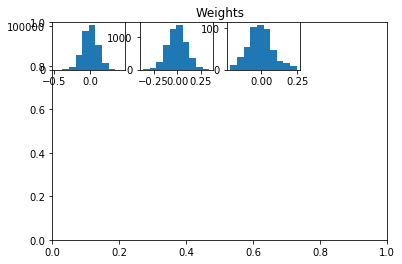

dW 0 Mean 0.000450279113406 SD 0.334573388184
dW 1 Mean -0.0228005206497 SD 3.45900668262
dW 2 Mean -5.49213846383e-05 SD 24.8967282234


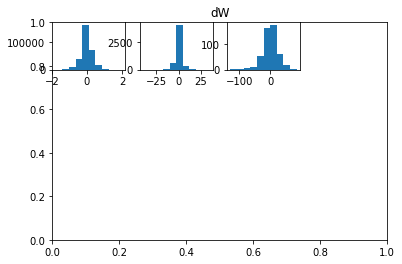

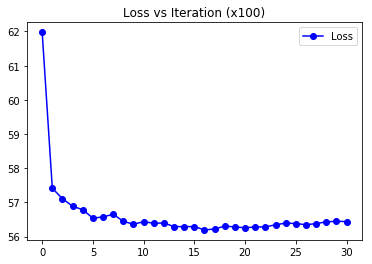

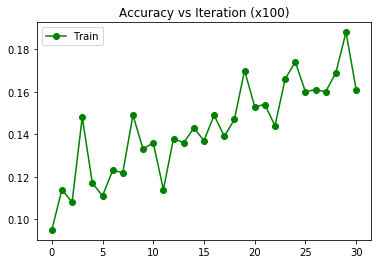

301


302


303


304


305


306


307


308


309


310


[0 0 9 1 2 0 6 9 5 7 1 9 3 3 6 3 8 9 5 1 7 6 1 0 7 4 4 8 6 6 9 9 5 0 0 8 8
 4 9 5 9 1 0 2 9 0 8 9 4 8 5 6 8 6 2 1 0 2 6 6 3 3 7 0 6 1 5 6 9 0 8 9 8 5
 9 0 0 3 3 2 4 6 0 7 2 9 5 6 4 4 6 3 8 3 3 5 4 9 0 7 2 3 9 6 6 4 9 9 3 0 2
 5 6 2 3 8 9 3 2 5 7 3 2 9 2 8 8 9 5 0 3 4 1 6 1 7 3 0 8 7 0 8 4 8 6 5 2 7
 8 8 8 5 6 9 6 0 6 9 2 2 3 8 5 5 6 6 9 2 3 4 7 6 5 5 8 9 1 2 5 7 5 9 3 7 9
 9 4 5 8 7 0 5 8 8 8 4 5 5 8 5 9 5 3 3 3 2 4 0 4 3 8 5 8 8 0 6 4 3 3 8 7 9
 2 9 8 2 3 8 2 2 6 5 9 5 2 7 4 2 1 1 7 9 2 7 3 6 8 4 5 6 3 5 5 0 2 9 0 2 6
 1 8 3 4 7 6 0 9 7 3 2 1 8 0 0 6 8 5 5 6 0 7 6 2 1 7 0 3 1 2 1 0 9 8 2 5 0
 8 7 4 5 4 1 5 9 8 9 9 4 1 2 5 1 6 0 5 8 2 5 0 4 5 7 5 8 0 8 3 2 5 6 4 3 4
 3 8 3 6 5 5 2 2 1 1 3 6 9 5 8 3 8 0 1 3 4 5 8 1 7 4 4 1 0 0 6 9 6 9 2 8 0
 6 5 3 5 2 3 9 1 8 0 8 1 0 1 0 4 6 9 2 2 7 9 9 3 8 9 8 9 0 9 9 6 5 5 3 3 1
 2 5 3 3 5 5 7 2 0 2 0 1 4 7 7 8 8 9 2 3 0 6 0 6 4 5 4 4 7 6 4 0 9 6 5 5 6
 0 2 9 5 1 4 9 9 4 6 1 8 1 3 4 7 2 3 8 9

343


344


345


346


347


348


349


350


[6 6 9 7 2 4 2 8 6 7 6 5 4 3 7 3 0 9 1 1 7 3 1 7 7 9 4 8 0 0 9 9 6 4 4 8 2
 4 6 9 3 5 3 1 5 0 9 3 1 0 3 6 3 4 0 5 9 2 1 0 0 3 0 2 5 5 9 6 3 6 5 4 7 8
 9 5 5 3 0 0 8 8 7 6 8 9 6 3 4 6 6 3 4 3 3 0 8 2 9 5 2 3 0 6 6 8 3 9 3 4 2
 5 6 6 3 3 6 1 8 5 2 3 2 9 2 8 8 8 6 0 7 0 2 6 1 7 6 4 6 8 0 3 8 5 2 5 8 7
 6 5 6 7 0 9 6 9 0 6 2 2 3 3 2 1 6 2 5 2 1 8 8 2 7 7 1 3 0 8 0 8 5 9 3 5 0
 3 3 5 8 7 0 8 3 6 9 4 5 5 8 5 9 5 2 1 6 9 4 0 6 3 3 2 1 3 4 6 3 4 3 2 0 4
 2 8 8 0 3 2 2 6 8 7 8 2 2 3 0 1 0 0 2 3 4 1 8 7 5 9 7 5 7 2 1 0 0 6 0 2 9
 6 9 0 6 7 0 1 3 8 3 2 8 9 9 1 9 4 6 9 6 7 9 9 2 5 6 0 3 7 2 1 6 9 4 7 2 8
 4 7 8 0 9 4 4 9 5 8 4 9 3 2 9 5 5 7 5 8 2 7 1 8 0 2 5 8 0 0 3 2 5 3 4 4 2
 8 9 0 6 8 6 0 6 1 0 0 5 6 8 8 3 2 8 8 2 0 5 5 5 8 2 0 0 0 2 6 5 4 1 6 0 7
 9 9 0 5 1 9 1 8 2 0 8 8 0 1 0 4 0 3 1 5 5 0 7 3 3 9 5 6 7 6 3 4 5 8 5 3 1
 8 7 9 3 7 7 5 3 8 2 2 7 6 7 8 7 6 2 2 7 2 4 4 0 0 7 4 9 8 6 6 5 6 6 1 2 6
 0 2 3 8 5 7 9 3 0 7 1 7 5 3 5 5 5 7 2 3 7 5 2 8 5 9

383


384


385


386


387


388


389


390


[6 6 4 4 9 4 1 0 6 2 6 6 3 8 7 3 8 8 0 0 7 6 7 9 6 4 0 2 9 6 5 6 4 0 0 5 0
 8 6 1 0 0 0 2 5 5 6 9 1 8 4 6 8 4 2 4 9 2 1 6 3 5 0 2 1 0 9 2 2 6 4 2 0 6
 7 9 5 2 8 2 0 2 9 1 2 7 0 6 6 9 5 4 4 9 0 2 8 5 4 9 6 3 8 6 6 8 9 7 3 2 8
 7 6 2 9 3 9 0 8 5 2 5 2 8 2 2 9 7 9 0 7 0 2 6 1 2 5 1 7 8 1 9 4 0 6 5 8 9
 7 8 3 5 5 5 3 0 0 8 6 8 3 7 5 6 7 2 5 6 3 3 8 0 7 5 6 1 1 3 1 7 2 3 1 9 9
 3 1 5 2 6 0 8 3 5 8 9 5 5 2 5 0 4 2 1 6 9 7 4 8 7 3 5 7 3 3 9 8 3 9 2 8 2
 5 7 4 0 3 5 2 6 0 7 9 5 2 7 0 1 9 3 2 7 4 3 0 0 3 7 7 1 7 0 5 0 5 1 5 2 6
 0 5 0 1 6 6 1 3 8 3 2 3 7 5 4 9 8 6 9 9 0 1 2 0 2 3 7 7 7 2 1 9 6 8 6 0 7
 8 7 7 1 0 4 1 3 7 2 4 7 1 5 0 6 0 1 5 2 0 9 6 8 9 7 5 4 0 0 3 6 5 6 4 8 2
 6 9 3 6 5 0 9 6 1 4 0 6 6 5 2 3 4 0 8 2 0 8 5 7 7 4 5 2 2 5 6 5 6 3 6 8 1
 6 5 0 7 2 1 1 0 2 9 8 1 3 1 2 4 4 3 5 8 2 6 3 4 6 9 5 6 2 9 6 6 1 9 1 6 1
 2 5 0 3 2 9 5 1 4 2 6 1 9 5 4 7 2 0 9 5 8 8 4 0 5 9 4 9 6 4 7 4 5 8 6 5 6
 0 2 9 9 1 6 9 4 5 9 7 0 7 0 9 2 7 6 8 3 9 8 9 2 0 7

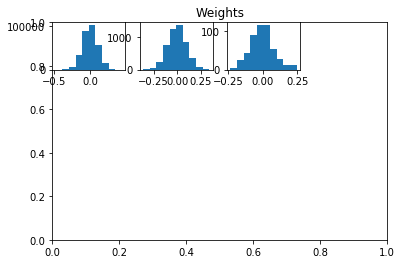

dW 0 Mean -0.0188709926934 SD 0.376959808664
dW 1 Mean 0.062012031132 SD 3.33487092139
dW 2 Mean -5.4926244514e-05 SD 18.8330922457


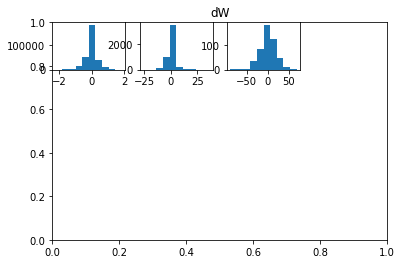

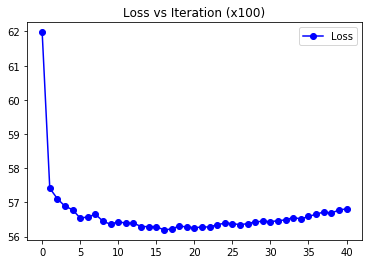

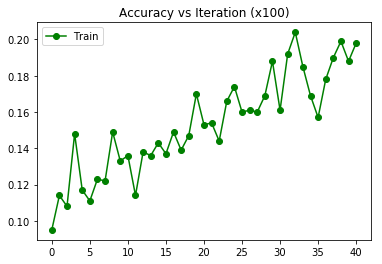

401


402


403


404


405


406


407


408


409


410


[0 6 6 4 2 1 1 8 1 9 9 0 3 3 1 0 6 2 9 4 8 6 1 7 1 4 4 2 9 0 5 6 1 0 9 8 3
 6 6 1 3 6 0 6 1 5 7 9 4 0 1 6 3 6 0 9 6 0 6 4 0 3 2 5 4 1 5 6 3 0 4 9 0 5
 7 9 9 2 3 2 4 2 9 8 2 3 9 3 6 4 0 3 4 3 3 0 4 2 9 1 2 9 9 9 0 4 3 9 3 8 8
 5 8 2 5 3 3 0 4 8 6 8 0 3 6 2 0 7 5 5 8 4 9 6 1 3 6 4 8 6 0 8 7 6 2 5 9 8
 4 6 0 7 5 8 3 7 7 6 4 2 3 5 5 1 7 1 5 8 9 3 7 6 4 1 1 1 1 4 0 5 5 5 7 1 6
 3 6 0 8 6 6 1 0 5 3 4 5 5 0 1 0 4 3 3 3 3 8 7 6 8 3 5 6 3 3 6 4 8 3 2 2 9
 9 8 8 6 3 4 2 4 3 5 2 5 9 7 4 2 9 3 2 0 4 8 4 6 2 6 5 9 7 2 7 3 5 1 6 2 6
 1 6 9 6 9 6 6 3 6 8 0 3 9 9 0 6 8 5 7 6 7 5 6 1 2 6 4 6 1 6 1 8 9 8 6 6 4
 4 7 5 0 2 0 5 3 8 9 8 4 9 2 0 1 5 3 2 3 8 9 7 8 5 7 5 4 0 0 0 2 5 3 2 3 0
 3 9 0 0 5 5 0 6 3 1 1 1 3 8 2 8 3 8 1 2 5 5 7 7 4 0 2 6 0 2 6 5 6 0 0 0 7
 6 6 9 5 8 8 9 6 2 7 5 3 0 1 5 0 6 3 2 6 2 6 9 9 8 4 6 6 0 6 3 6 5 5 6 9 1
 2 7 3 3 7 5 5 3 0 2 1 1 5 6 7 2 6 0 9 7 8 3 4 5 7 9 2 0 6 7 6 6 0 8 0 5 6
 0 7 3 8 0 7 6 4 1 1 1 9 2 3 7 2 5 1 7 9

443


444


445


446


447


448


449


450


[1 1 9 4 9 4 2 2 5 0 4 6 6 3 1 3 8 8 7 6 0 3 8 0 1 0 5 0 0 5 5 6 3 8 4 8 5
 2 6 5 3 1 5 2 9 1 6 9 4 0 7 6 8 0 5 0 9 0 1 6 0 6 0 8 5 8 7 6 2 6 0 2 7 9
 5 5 5 9 8 0 0 6 9 1 8 3 0 6 5 4 6 3 8 8 5 2 4 9 4 7 2 3 0 8 0 4 9 8 2 0 2
 5 4 6 9 6 6 0 2 6 5 8 1 3 1 8 7 9 5 3 8 0 2 6 1 3 9 9 8 8 0 0 8 1 2 5 2 2
 7 5 0 7 2 5 3 0 0 8 0 8 9 3 5 0 5 6 5 7 7 3 8 2 7 7 8 5 0 8 5 7 0 3 3 7 9
 8 7 2 8 0 2 4 8 7 2 9 0 5 2 5 2 0 3 4 3 2 7 4 6 8 3 6 7 9 4 9 4 3 9 2 0 3
 9 9 1 0 3 5 2 7 6 7 8 7 2 6 4 8 9 3 2 9 6 3 3 6 8 0 5 5 3 5 0 0 1 5 8 1 6
 2 3 3 9 7 6 9 7 6 3 0 8 9 3 4 9 9 2 6 2 3 5 6 4 2 3 3 8 7 2 5 6 2 7 2 5 8
 6 7 9 0 9 4 3 0 8 8 9 9 3 0 8 1 1 7 5 2 8 7 1 8 9 2 5 9 0 3 1 6 8 3 4 4 0
 6 5 0 5 5 6 5 8 3 0 1 0 6 8 8 1 9 0 3 5 7 5 5 1 7 4 2 2 2 6 6 9 4 5 8 8 4
 6 9 9 7 8 9 5 8 8 1 3 5 3 1 2 8 4 3 5 5 2 0 3 3 6 9 1 6 0 5 3 0 2 5 3 3 1
 6 6 8 8 0 7 5 3 8 2 4 6 8 7 2 2 8 0 3 6 2 8 4 4 7 7 2 3 6 7 6 0 9 5 0 5 2
 0 9 8 5 1 3 9 4 5 6 5 9 0 6 9 2 1 0 0 3 2 2 9 8 2 9

483


484


485


486


487


488


489


490


[0 6 3 0 2 4 2 9 9 6 9 7 3 3 1 3 1 3 6 4 7 2 7 1 1 8 6 2 6 0 0 4 4 0 9 8 6
 4 9 0 9 6 0 2 8 1 6 9 2 0 5 1 8 0 2 0 9 6 1 4 2 3 0 8 9 6 5 2 9 0 7 2 7 8
 2 5 9 5 8 0 4 6 9 5 8 7 8 5 0 4 0 4 0 3 6 5 8 4 0 3 2 3 0 6 3 4 9 7 1 8 5
 7 1 5 3 8 9 0 2 5 6 3 5 3 3 8 0 9 5 0 7 4 9 6 1 0 9 9 6 0 0 8 8 5 2 5 2 2
 5 8 8 5 1 3 4 9 0 0 0 2 3 8 9 0 7 6 8 2 9 3 8 6 4 7 1 5 0 3 0 8 5 9 9 7 9
 9 3 2 5 6 0 5 8 5 8 9 5 5 8 7 0 5 3 3 6 3 4 0 7 6 8 6 8 3 5 9 4 3 9 2 6 4
 2 1 1 0 3 2 2 4 0 0 8 7 2 7 8 5 6 1 9 7 2 2 5 9 8 0 7 3 3 0 0 3 4 1 6 1 6
 0 6 0 4 6 6 0 5 5 3 2 2 9 5 8 6 0 8 8 9 7 1 6 7 5 6 1 3 7 2 1 9 5 4 2 6 4
 6 7 6 0 4 0 3 3 4 7 9 9 5 0 5 1 1 4 9 8 2 8 7 8 5 2 5 4 8 7 3 1 5 6 4 8 4
 3 9 3 6 5 6 5 6 7 8 0 1 6 9 3 3 5 8 3 6 0 8 9 5 8 4 2 0 0 5 0 9 7 8 0 0 4
 6 6 0 8 8 9 1 6 8 7 3 1 8 4 6 4 0 3 2 5 2 0 7 9 8 8 5 9 0 9 9 6 1 3 3 9 1
 8 7 9 3 5 9 0 3 0 2 1 1 4 7 5 5 6 9 9 7 6 4 4 4 7 5 8 0 7 7 6 5 5 8 7 5 2
 9 9 9 5 6 9 9 4 9 1 3 7 5 3 1 5 9 3 7 5 7 0 2 8 1 5

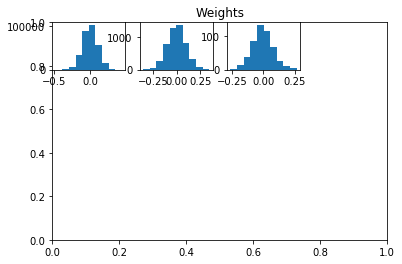

dW 0 Mean -0.00656692376627 SD 0.33792704458
dW 1 Mean 0.051586628706 SD 3.27876898297
dW 2 Mean -5.49281176557e-05 SD 18.7967556795


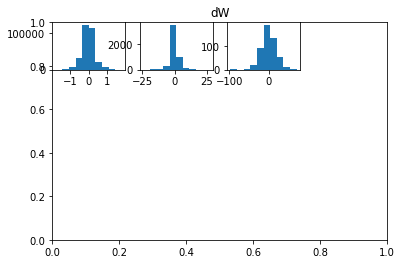

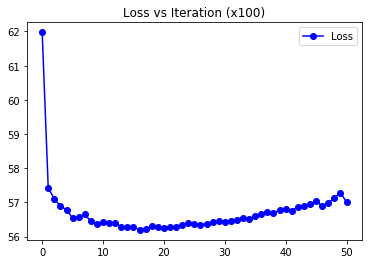

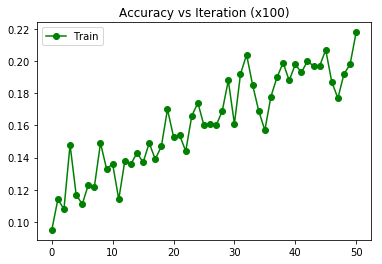

501


502


503


504


505


506


507


508


509


510


[1 8 9 5 5 0 2 9 5 7 4 9 1 8 6 8 7 2 4 1 3 9 5 2 6 4 0 0 0 0 7 9 1 4 4 9 8
 8 6 6 6 1 6 1 6 0 9 9 0 6 5 5 8 4 7 9 0 2 1 6 8 3 2 0 2 8 7 7 9 6 5 2 0 6
 7 6 9 3 3 7 2 2 9 6 2 9 0 6 0 9 1 5 8 3 6 2 8 5 0 7 2 5 0 0 3 5 9 9 9 8 8
 7 1 8 3 8 9 0 2 7 6 3 9 3 1 2 0 9 9 4 0 0 2 6 1 2 0 3 8 7 0 0 8 1 2 5 8 8
 0 9 0 7 6 8 4 0 1 6 6 7 8 3 1 0 6 2 5 2 9 8 8 6 5 7 3 0 1 8 1 8 5 3 3 5 0
 3 4 0 3 7 0 5 0 0 8 7 7 2 2 5 0 8 2 5 5 2 7 0 6 3 8 5 8 3 5 6 4 8 3 2 6 5
 2 8 8 0 3 8 2 3 6 4 9 7 5 7 1 2 9 0 2 3 4 0 0 6 2 7 9 9 7 1 7 3 4 5 8 1 9
 0 9 3 4 1 6 0 2 6 3 0 8 8 5 3 9 9 2 6 6 8 6 2 8 8 3 9 8 7 2 5 4 6 7 1 5 7
 4 7 7 5 7 4 4 3 7 9 4 4 7 0 6 1 7 3 2 8 0 5 7 8 5 7 5 8 2 9 1 2 8 3 4 4 7
 3 9 0 6 5 0 5 2 1 0 3 6 4 9 4 3 5 6 8 0 0 5 8 3 7 7 2 4 0 6 8 2 7 5 0 0 9
 9 0 9 5 8 3 3 0 8 6 6 3 1 1 6 4 6 9 2 2 0 2 7 9 3 4 5 6 7 9 3 6 1 6 5 3 1
 6 5 4 3 5 7 5 2 1 2 6 6 2 7 4 2 8 3 9 5 0 0 0 0 7 4 9 6 9 1 4 3 0 8 5 5 0
 9 5 9 8 1 6 5 4 9 6 6 7 2 6 7 5 2 1 7 3

543


544


545


546


547


548


549


550


[0 0 3 1 2 4 2 2 0 1 5 0 0 3 6 3 8 0 7 6 8 3 8 0 8 0 5 2 9 0 7 6 1 4 0 0 6
 4 6 5 9 5 3 6 8 5 6 9 1 8 1 5 8 5 2 9 5 2 6 0 6 3 7 8 2 1 9 2 3 0 5 4 8 4
 7 5 9 2 8 2 4 6 9 5 8 7 6 6 0 4 0 3 4 9 3 0 9 5 0 7 7 0 5 6 6 4 9 8 3 0 2
 9 1 8 1 5 9 0 1 7 3 0 0 3 2 8 0 7 1 0 3 3 2 6 6 8 3 8 7 6 5 3 8 6 2 8 2 5
 5 5 6 7 2 3 4 0 0 8 0 2 3 7 0 1 6 2 2 6 9 0 8 2 7 1 3 6 0 6 0 5 5 0 3 7 0
 8 3 0 8 6 6 4 8 9 8 1 2 0 2 1 6 8 3 4 9 2 7 0 6 3 8 5 6 3 0 9 4 7 4 2 3 2
 6 2 8 6 3 2 7 6 6 0 9 5 5 3 4 5 9 8 2 3 2 0 9 0 2 9 7 9 3 6 1 3 7 5 8 8 4
 6 6 3 6 7 6 1 7 5 9 0 6 7 3 3 9 8 8 6 6 4 6 2 4 7 3 1 8 7 4 7 8 2 8 2 6 8
 4 7 0 6 7 4 4 3 7 8 8 5 3 7 3 1 6 7 0 8 0 7 7 4 0 0 5 0 2 1 3 6 2 3 4 9 6
 3 6 3 5 3 5 6 5 8 0 3 6 6 6 8 3 2 6 7 8 0 8 8 7 0 2 5 8 3 6 6 1 6 1 0 0 7
 9 6 0 4 2 3 4 0 3 0 4 3 3 4 2 0 6 3 7 6 2 9 8 9 4 4 4 9 0 5 6 4 5 8 6 0 4
 8 6 4 3 4 5 7 3 2 2 2 1 6 9 4 2 6 3 9 3 6 4 0 5 5 9 4 1 3 8 3 0 9 6 6 7 6
 9 5 6 0 1 7 9 6 5 7 7 7 2 3 0 5 7 3 2 2 9 2 1 2 3 5

583


584


585


586


587


588


589


590


[0 1 3 7 5 5 2 6 9 7 8 7 3 3 1 8 0 0 6 8 0 6 7 0 6 4 0 0 6 5 5 9 3 0 8 7 3
 2 4 9 7 9 0 6 3 0 7 9 1 2 1 5 6 0 2 9 5 0 1 0 0 3 0 5 2 1 9 6 4 1 4 8 3 6
 9 9 5 7 3 7 0 5 9 9 9 3 2 6 9 9 1 7 8 3 6 0 8 8 4 7 2 3 5 0 6 4 4 0 1 3 8
 6 1 8 3 8 5 2 8 5 6 3 5 5 1 8 6 9 9 2 7 4 9 5 1 2 9 1 7 8 0 2 5 6 0 9 3 8
 8 9 6 7 7 8 4 0 0 9 1 7 4 7 0 0 7 1 2 2 6 8 9 6 7 4 1 8 3 2 1 8 1 9 3 7 0
 3 6 0 3 7 2 5 8 7 6 8 4 8 6 5 6 7 3 1 3 3 4 7 7 6 8 5 0 8 4 9 4 3 3 2 3 6
 2 8 1 2 3 3 2 6 8 0 6 5 9 8 4 5 0 6 2 3 2 2 5 5 2 7 5 5 3 0 7 9 9 1 6 1 9
 6 3 0 4 0 0 7 6 6 3 2 1 5 9 3 9 6 2 9 9 0 9 5 2 2 3 5 8 6 2 4 8 2 7 1 0 7
 8 7 1 5 7 4 1 1 3 7 4 7 3 2 0 7 8 7 2 2 2 1 8 4 9 7 5 9 1 0 0 6 5 3 0 9 4
 1 9 0 0 6 6 7 6 9 4 6 1 3 5 2 3 6 8 1 0 0 8 5 7 4 7 5 2 0 2 6 9 6 5 5 0 4
 6 8 0 7 2 3 9 6 2 1 9 4 6 1 0 2 4 9 2 6 4 6 8 3 0 5 5 9 7 2 0 6 9 7 3 9 1
 2 7 4 3 0 9 5 8 2 5 0 6 6 6 4 2 6 2 9 2 8 5 0 5 5 5 6 6 5 3 6 8 0 8 0 5 2
 9 2 8 6 1 6 9 4 5 1 5 8 2 5 7 5 5 1 7 9 0 2 2 4 9 4

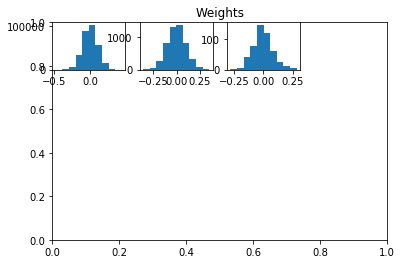

dW 0 Mean -0.0287216847311 SD 0.4066143748
dW 1 Mean 0.0394035796551 SD 3.70033508877
dW 2 Mean -5.49306597095e-05 SD 21.6534536494


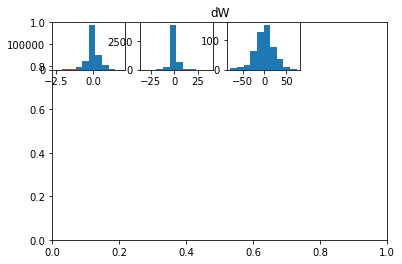

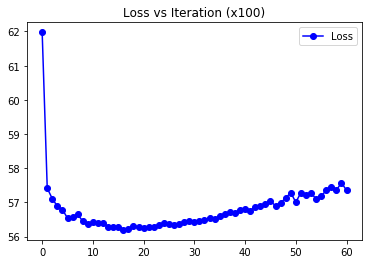

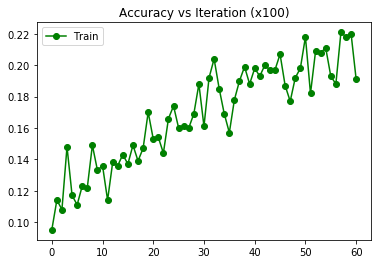

601


602


603


604


605


606


607


608


609


610


[5 6 3 5 2 0 2 9 8 7 0 6 3 3 6 9 6 8 1 7 3 7 5 7 6 9 4 4 0 5 0 5 0 8 4 7 6
 4 6 6 3 6 7 1 5 5 8 3 0 0 7 1 0 5 2 0 5 2 6 6 8 8 0 5 2 7 9 2 4 1 1 9 0 0
 7 6 6 9 3 5 8 6 9 0 9 9 6 0 0 8 6 5 4 9 3 5 4 4 0 7 0 9 7 6 3 8 1 2 3 2 2
 5 8 2 9 5 5 2 2 5 2 3 1 5 2 5 1 7 1 5 9 0 9 6 3 7 5 1 8 7 1 0 5 5 2 5 1 7
 7 9 0 7 5 8 3 6 0 9 4 8 7 5 5 1 7 2 5 2 9 8 8 0 7 1 1 5 8 4 5 7 7 0 7 9 9
 8 1 0 9 7 0 8 8 7 8 2 5 5 5 6 6 1 2 7 8 1 2 0 6 7 1 5 6 3 9 6 3 3 4 2 8 5
 9 9 1 0 6 2 2 6 8 5 6 5 9 7 0 6 9 8 0 3 1 2 3 6 5 6 5 9 1 1 7 0 0 5 7 1 5
 6 9 0 9 6 0 1 5 2 3 2 2 7 5 4 6 8 0 9 6 9 5 0 4 8 3 6 8 1 2 8 2 6 4 4 6 4
 9 7 0 6 7 4 1 3 8 2 7 7 5 6 6 1 0 7 5 8 0 5 7 4 7 0 5 8 0 0 3 8 2 7 4 5 6
 8 8 3 5 1 1 7 6 1 0 7 9 6 6 4 3 5 0 8 4 5 8 5 7 4 5 4 2 0 0 6 5 7 8 5 0 9
 9 2 3 8 2 3 8 1 4 5 8 3 5 4 5 4 0 7 2 9 5 0 3 2 3 7 5 9 0 6 6 4 5 5 9 3 1
 8 7 8 3 4 7 0 8 0 2 2 1 5 7 4 2 5 3 3 6 6 9 4 4 5 0 4 3 8 7 6 5 9 6 8 9 6
 0 2 6 6 5 6 6 4 5 0 5 7 5 3 9 5 2 4 7 9

643


644


645


646


647


648


649


650


[0 3 3 4 5 0 1 1 2 6 9 0 3 8 0 3 1 2 5 1 7 4 5 5 4 4 8 2 7 0 7 9 0 0 0 8 9
 4 4 3 0 5 3 2 5 0 6 3 1 0 5 6 8 4 0 2 6 0 1 6 0 5 7 5 2 7 5 5 9 6 4 4 8 6
 0 6 5 5 8 2 0 6 9 7 9 7 5 7 0 2 0 3 4 9 6 2 0 9 8 3 2 0 9 5 6 4 9 0 3 2 5
 0 1 6 3 8 3 0 4 5 9 8 0 3 6 8 8 7 9 0 7 0 4 5 3 2 6 4 3 7 5 8 4 5 2 6 2 2
 0 8 0 2 5 7 3 6 0 8 0 2 3 3 1 7 7 6 8 6 3 0 8 1 8 1 6 1 2 4 5 5 0 3 3 5 9
 3 6 3 3 6 1 5 0 8 8 8 5 5 0 7 0 4 3 8 3 5 3 0 3 7 1 2 4 3 0 9 0 8 4 8 0 6
 9 2 8 2 0 9 2 0 6 7 9 7 9 7 0 1 9 8 2 3 1 8 3 2 3 0 7 1 1 4 7 9 7 5 5 1 4
 2 6 3 6 0 0 1 0 7 8 2 1 1 3 3 6 8 4 9 2 7 7 0 8 6 1 5 7 1 4 5 8 6 0 1 6 4
 9 7 7 1 9 7 5 3 7 2 4 5 9 3 5 1 0 7 2 3 5 7 7 9 7 2 8 4 2 1 6 6 9 3 6 4 0
 3 8 3 6 6 6 2 6 8 4 7 9 3 5 0 3 9 0 5 0 5 5 9 7 0 4 5 2 0 0 6 9 4 9 5 0 9
 6 3 9 7 2 8 4 6 9 1 3 1 0 4 1 4 6 3 2 5 2 6 7 3 0 8 5 9 3 5 6 6 5 7 6 3 1
 0 6 5 3 5 9 5 3 0 0 0 6 4 7 5 2 2 8 9 7 0 6 4 4 4 0 5 6 6 7 7 4 3 6 7 5 2
 0 5 3 8 7 4 9 9 5 6 7 9 5 6 4 5 6 3 0 2 7 2 1 4 0 5

683


684


685


686


687


688


689


690


[0 0 3 0 5 4 2 2 6 2 9 9 6 3 7 3 8 9 7 6 3 3 1 7 6 9 4 4 9 5 5 9 5 4 5 8 3
 2 6 9 9 1 1 6 8 5 8 2 0 8 8 5 5 4 0 1 6 2 1 6 1 5 0 5 4 0 9 0 9 9 1 2 1 6
 4 9 5 8 3 0 4 1 9 6 8 6 0 5 0 4 6 4 5 8 9 0 7 5 0 9 6 3 0 0 6 4 7 8 9 2 8
 8 4 8 6 6 6 3 2 8 6 3 0 1 3 5 7 9 9 2 8 0 9 1 3 2 5 8 8 7 9 3 4 5 0 8 8 2
 8 9 0 7 6 3 6 0 0 4 6 2 3 5 0 5 6 2 2 2 9 4 8 0 4 4 1 1 0 6 0 5 2 5 9 9 3
 8 9 2 7 3 6 5 3 7 5 9 5 5 5 7 0 1 0 7 3 3 4 0 6 6 8 9 4 3 0 6 4 3 3 2 2 3
 9 3 1 0 8 8 0 2 6 7 9 8 3 7 0 5 0 3 2 3 4 3 2 1 5 4 5 9 2 3 7 3 7 1 5 1 0
 2 3 1 4 1 6 7 3 0 8 2 1 3 5 4 5 5 7 5 2 7 2 9 0 7 0 4 6 1 2 1 8 2 0 2 6 8
 9 7 0 5 9 0 1 3 9 7 4 9 9 2 9 1 1 1 5 3 2 8 0 7 7 0 5 4 0 8 6 2 5 3 4 7 6
 1 8 3 0 8 1 9 6 7 4 0 0 3 5 8 3 9 0 5 3 5 6 3 7 4 4 2 2 0 6 0 2 6 8 5 0 0
 8 9 5 8 6 9 8 6 9 1 9 1 0 1 0 2 1 3 2 6 5 7 7 4 6 5 4 6 3 6 8 4 5 4 9 3 4
 6 5 9 3 0 3 2 3 1 2 0 1 6 7 2 2 8 2 3 7 2 9 0 0 8 6 2 3 5 6 6 3 9 8 1 7 0
 0 2 6 5 7 7 3 6 5 8 3 9 6 8 0 2 0 8 2 2 7 5 7 0 0 9

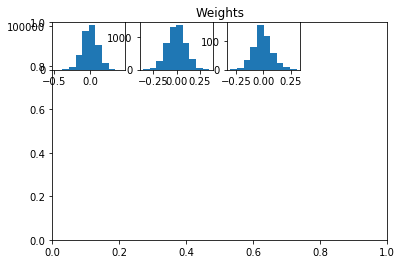

dW 0 Mean -0.0363197992238 SD 0.411817008861
dW 1 Mean 0.0430174527478 SD 4.19698039228
dW 2 Mean -5.49333742597e-05 SD 25.8821798518


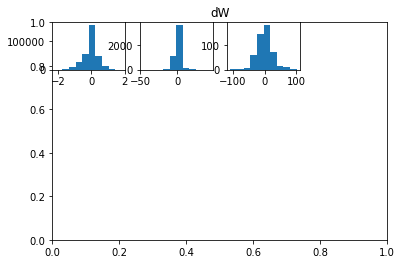

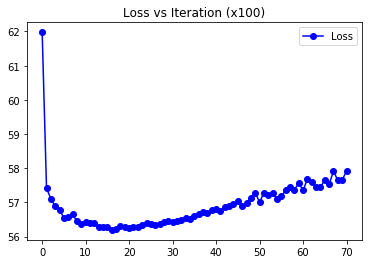

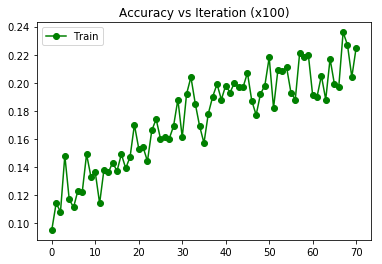

701


702


703


704


705


706


707


708


709


710


[1 0 9 1 9 4 6 1 5 2 9 7 3 3 8 8 6 6 5 1 7 2 6 0 0 4 9 2 0 5 6 0 6 6 4 8 5
 4 3 1 8 9 7 6 6 0 7 2 2 2 1 5 3 5 5 0 4 9 1 6 3 9 0 9 5 0 5 6 3 6 8 9 4 0
 1 5 1 3 3 0 0 1 5 9 2 1 8 5 1 8 0 5 4 3 9 8 4 9 4 7 0 9 0 1 6 0 7 0 2 8 8
 7 1 1 1 8 6 0 2 5 9 4 2 3 2 5 8 7 5 1 7 0 9 6 3 9 5 1 5 7 0 3 6 5 2 6 2 2
 5 5 8 7 5 3 6 0 0 4 2 8 0 7 5 6 6 1 5 6 6 3 7 2 7 1 1 6 0 8 0 5 8 9 3 9 4
 9 3 0 6 7 6 4 4 7 4 0 5 2 0 6 9 5 3 2 3 5 4 0 0 8 3 5 7 3 4 9 5 4 4 8 3 5
 2 9 1 9 0 8 4 2 8 5 9 8 9 7 0 7 9 0 7 6 1 0 9 1 2 3 5 3 9 2 1 3 9 5 6 2 5
 6 6 3 3 0 0 7 5 1 3 0 6 7 3 0 4 8 0 9 6 7 9 6 2 7 5 0 6 1 8 4 8 9 4 6 6 7
 6 7 7 5 7 0 7 3 8 2 4 7 3 2 5 1 6 4 5 2 8 7 7 4 1 2 9 8 0 1 3 2 5 3 7 8 0
 3 8 3 8 3 0 9 8 9 8 1 1 3 8 8 3 9 0 8 4 5 6 7 5 0 2 5 2 3 6 1 0 0 9 8 8 7
 9 3 6 7 2 9 5 6 3 9 9 1 2 4 9 0 5 3 7 9 0 9 9 0 6 2 5 0 3 5 8 6 9 6 3 9 7
 2 7 9 3 0 9 5 3 6 2 9 8 2 8 4 2 8 3 2 7 2 6 1 2 7 4 2 6 8 8 2 8 0 5 2 2 2
 9 3 3 2 6 7 6 9 1 6 3 0 5 7 7 9 6 0 8 6

743


744


745


746


747


748


749


750


[6 8 3 1 2 4 5 6 8 6 0 8 6 3 1 0 4 8 0 5 1 6 1 0 0 9 5 9 0 9 0 9 5 0 8 8 8
 4 9 9 3 5 0 2 5 0 5 5 1 8 1 1 8 5 2 0 4 2 1 5 3 9 2 2 5 1 5 1 9 0 0 2 0 4
 0 4 6 0 9 0 4 1 2 4 7 9 8 4 5 4 1 3 4 9 5 7 9 5 4 0 1 3 3 1 6 8 7 7 9 8 5
 5 8 2 6 5 9 8 2 4 1 6 5 1 1 8 9 7 9 2 4 3 5 1 3 0 5 8 0 6 0 3 7 4 2 9 2 2
 0 5 0 7 1 0 3 2 6 9 6 9 0 7 9 1 1 2 0 8 3 0 4 6 7 4 5 6 1 6 5 1 0 9 3 5 0
 3 6 5 9 5 0 5 4 3 3 6 0 2 2 0 9 5 3 1 6 3 4 0 8 3 8 2 8 8 8 6 0 3 9 7 6 4
 0 9 1 2 4 7 2 0 6 7 3 5 2 7 0 2 0 3 2 7 2 1 6 1 2 0 5 6 3 8 7 3 5 7 0 1 6
 6 6 3 6 7 6 1 5 8 3 2 1 8 0 0 5 5 7 8 6 7 4 6 4 1 5 5 3 7 2 1 4 9 7 1 1 8
 6 7 7 2 7 0 4 9 8 7 7 7 9 2 5 1 1 1 0 7 5 7 0 2 9 2 5 9 8 0 6 2 5 3 8 8 0
 1 9 0 6 1 5 7 8 9 8 7 9 6 5 2 3 9 7 7 0 7 8 3 9 3 0 5 6 2 6 6 5 7 8 0 3 7
 4 0 9 8 8 9 9 9 9 7 4 9 3 4 7 0 1 9 5 6 4 0 3 9 3 4 8 5 3 6 3 4 5 4 6 6 1
 8 7 0 8 5 9 7 1 1 9 4 6 9 6 4 2 3 2 9 7 6 9 4 2 4 8 9 3 7 1 6 8 0 8 8 7 2
 0 9 6 7 8 7 6 9 9 9 6 8 8 9 9 2 9 0 8 3 5 9 2 2 9 5

783


784


785


786


787


788


789


790


[5 9 3 4 9 0 5 2 9 9 9 7 1 3 7 3 4 3 7 1 3 3 5 0 4 7 9 7 9 0 9 9 2 4 8 5 3
 8 6 9 7 6 5 2 8 7 6 4 2 0 3 2 8 5 9 0 8 2 1 6 6 5 2 9 2 5 9 6 2 5 4 8 0 8
 7 8 1 0 8 2 4 0 1 4 2 5 5 6 0 2 5 3 4 9 9 5 8 2 0 9 7 5 0 2 0 4 9 1 3 2 5
 7 6 7 6 6 6 6 4 5 5 6 1 3 2 3 3 4 3 1 5 4 1 6 1 2 0 1 8 7 0 8 2 4 2 5 2 0
 8 7 0 7 6 7 4 5 0 8 0 8 3 4 1 5 2 2 5 5 3 3 7 9 8 4 8 6 2 6 0 7 4 3 3 5 4
 8 8 0 8 6 4 1 0 9 9 4 5 0 6 4 3 4 5 4 3 9 4 1 0 3 6 2 6 8 4 7 5 9 9 1 2 4
 9 7 8 2 4 2 2 4 6 4 2 8 2 7 4 8 0 6 2 0 2 8 2 6 8 6 5 6 9 3 1 1 1 1 5 1 5
 1 5 3 6 7 0 6 9 1 3 0 1 1 3 3 9 0 7 9 3 0 2 5 0 1 5 8 6 7 0 1 0 5 7 2 5 3
 6 7 1 5 2 7 5 3 7 1 0 7 9 2 8 1 6 9 5 7 2 1 9 2 7 7 5 9 2 1 6 8 2 3 4 9 2
 3 9 0 6 5 5 7 6 7 4 1 1 6 5 8 1 9 8 1 8 7 8 7 9 0 7 9 8 2 5 3 2 4 5 0 8 9
 9 8 0 9 2 9 3 1 9 0 0 1 5 4 1 2 1 3 5 5 4 6 9 9 8 4 5 6 0 9 3 4 5 0 9 9 1
 4 1 0 3 5 3 6 0 8 9 2 1 8 7 7 2 5 6 1 8 6 4 3 6 9 7 0 1 7 8 7 5 3 5 2 9 2
 9 5 3 2 5 9 9 4 9 5 5 7 6 0 0 9 9 0 2 9 0 5 6 2 5 7

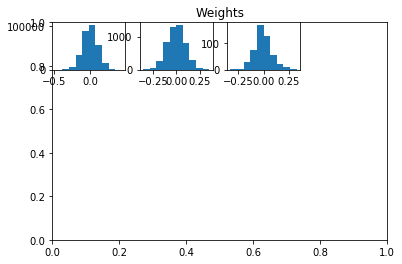

dW 0 Mean 0.0303103060348 SD 0.397550402462
dW 1 Mean 0.0234116114793 SD 3.58235865628
dW 2 Mean -5.49349377651e-05 SD 19.2196300678


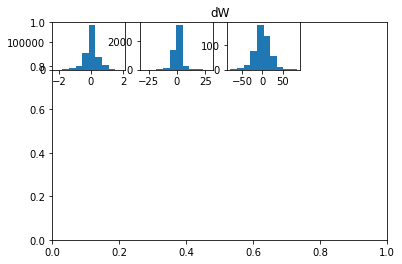

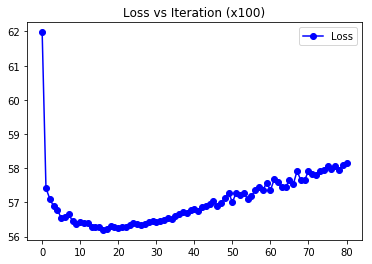

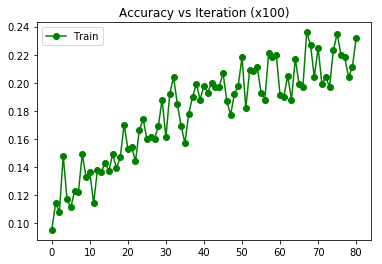

801


802


803


804


805


806


807


808


809


810


[5 6 2 4 0 9 2 2 5 7 9 8 3 8 1 5 2 2 5 6 9 4 5 7 6 4 5 2 6 0 5 6 1 8 5 6 3
 6 9 9 0 6 5 2 5 1 6 9 2 8 0 6 0 2 2 5 8 2 5 3 1 8 0 2 5 8 7 0 3 0 5 8 4 0
 0 5 9 3 6 2 8 1 2 7 5 2 5 0 5 0 0 0 4 3 0 7 5 9 0 9 5 9 0 0 6 4 7 7 7 2 0
 6 4 1 1 8 6 0 4 5 9 6 1 1 6 2 0 0 9 1 0 3 9 1 3 7 9 8 4 0 0 0 7 5 2 6 2 8
 5 5 6 7 9 7 3 0 0 6 5 2 8 5 5 5 7 2 2 2 6 0 7 5 7 1 3 6 1 6 5 7 7 9 1 9 1
 3 1 5 3 1 6 0 0 7 8 2 5 2 5 5 6 0 2 3 5 0 2 1 3 6 4 2 4 4 5 6 0 5 3 7 6 9
 3 9 1 2 3 9 4 4 6 1 1 5 9 7 5 5 0 6 2 3 2 2 8 9 8 7 5 9 7 1 1 3 5 6 6 2 0
 1 9 8 4 0 2 9 9 6 3 2 8 0 5 3 0 8 2 8 2 7 1 5 4 2 3 6 6 4 2 5 8 2 7 3 0 7
 9 7 0 0 6 7 3 3 4 2 7 8 7 2 1 6 0 1 9 2 2 5 0 4 7 0 5 4 2 1 6 2 8 8 6 4 2
 1 6 3 1 5 0 5 8 1 1 0 0 0 6 8 6 5 8 1 0 5 8 9 5 0 7 8 8 0 6 6 9 7 5 7 7 4
 2 9 5 7 3 3 1 0 2 1 9 9 6 4 0 4 0 1 9 6 2 4 3 4 0 0 7 8 0 6 8 4 5 5 6 3 1
 8 7 9 3 1 8 5 3 2 1 4 5 5 5 2 1 6 8 9 7 0 4 5 0 9 5 2 6 2 3 0 4 5 5 6 2 2
 1 2 9 2 0 9 6 6 5 9 6 7 2 0 5 2 5 1 0 5

843


844


845


846


847


848


849


850


[8 3 3 1 5 4 7 2 8 0 6 2 1 3 1 8 5 0 1 1 3 3 7 6 3 4 5 2 2 5 6 9 1 4 1 7 2
 5 4 9 3 0 2 6 6 3 3 9 2 2 1 2 3 6 5 0 0 2 6 9 3 2 0 5 8 1 9 6 9 5 4 2 8 8
 1 5 5 1 0 5 9 6 1 9 2 2 2 5 6 8 0 5 4 6 6 2 4 8 4 9 2 5 7 6 5 1 7 7 7 0 7
 6 0 2 9 5 9 0 8 6 6 6 2 3 6 8 9 0 9 2 1 1 1 6 3 7 9 3 3 8 1 3 4 8 6 8 2 5
 4 5 6 8 7 0 4 6 3 6 6 9 8 3 1 5 2 9 2 2 6 2 7 6 8 1 1 1 1 6 2 9 8 9 3 2 0
 3 3 0 3 0 6 8 4 7 2 2 0 5 5 7 3 4 5 8 9 1 1 0 4 3 6 5 8 8 8 6 8 8 3 2 6 3
 9 9 1 2 4 9 4 6 6 0 6 7 2 0 0 7 0 1 2 3 4 8 0 0 2 7 5 6 3 4 4 9 5 1 1 5 9
 1 6 3 6 6 6 9 6 5 8 2 6 7 0 0 9 6 0 9 2 4 6 5 1 7 6 4 6 7 8 5 6 4 4 2 5 7
 6 7 1 5 7 0 1 3 7 7 7 5 7 2 6 7 0 3 0 4 2 8 7 4 7 7 5 5 2 3 3 2 5 8 7 9 0
 6 9 9 5 9 5 2 8 3 4 1 1 9 5 2 1 8 8 8 0 0 0 5 3 2 0 2 3 3 6 6 5 6 3 6 0 9
 4 5 9 9 8 8 3 0 9 1 9 6 9 6 1 2 5 9 7 6 8 6 7 0 4 4 4 0 0 6 9 0 9 5 8 3 4
 0 7 5 3 5 2 0 6 1 5 9 6 2 9 4 6 6 3 8 7 2 9 4 4 4 5 2 6 5 4 6 4 3 6 0 7 2
 0 6 9 2 7 2 9 4 1 1 3 0 2 0 1 2 9 0 7 9 2 5 6 6 6 5

883


884


885


886


887


888


889


890


[0 0 3 0 5 4 1 0 5 0 6 2 4 0 0 3 0 0 7 1 1 6 5 0 3 4 7 4 0 0 9 2 1 4 4 8 8
 4 9 3 1 6 7 1 1 5 3 3 1 2 4 1 0 5 2 0 8 2 2 4 5 2 2 9 4 6 4 5 3 0 4 6 7 6
 5 5 0 4 3 0 9 8 0 0 2 3 2 4 0 6 0 1 4 5 9 2 0 2 0 9 7 5 8 6 1 2 7 4 9 9 2
 4 4 6 9 6 9 8 7 4 9 3 2 5 3 1 8 7 9 2 4 0 4 2 1 0 5 3 8 6 1 3 4 8 5 8 9 7
 5 5 6 5 1 7 3 7 0 6 4 8 7 8 5 5 2 1 2 1 9 2 7 9 7 4 8 0 8 2 0 0 5 1 3 7 9
 3 3 7 3 9 0 8 4 7 6 4 5 8 6 5 0 5 5 2 3 8 2 0 6 7 8 5 1 4 9 9 8 5 9 1 4 3
 9 1 1 0 4 8 4 0 8 7 1 7 9 8 8 7 6 0 2 3 1 2 3 3 2 4 5 9 7 8 1 1 9 1 5 1 5
 6 9 3 8 1 6 1 9 8 3 0 6 5 1 0 0 8 7 2 9 7 1 2 6 7 1 7 3 8 4 1 8 2 7 3 2 7
 6 7 7 1 7 0 3 3 5 6 4 4 0 7 3 8 0 4 9 3 5 5 5 0 0 4 5 9 2 7 4 2 8 1 8 4 0
 1 6 0 5 5 9 5 8 9 4 2 1 6 5 8 8 9 8 3 4 7 8 7 6 0 4 6 2 0 5 0 5 4 0 2 0 5
 6 9 3 7 1 9 9 6 9 0 9 9 6 4 6 4 4 1 2 8 2 9 3 9 8 9 8 6 0 9 6 4 2 9 6 6 4
 8 6 4 3 1 3 5 6 2 4 6 6 4 8 2 2 6 1 3 5 6 6 0 0 8 0 0 6 9 8 6 6 9 6 8 1 2
 9 9 9 6 9 2 5 9 9 8 1 7 5 7 5 2 2 4 7 5 1 5 2 4 0 6

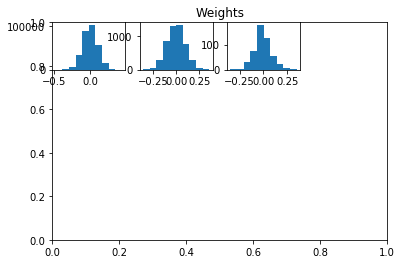

dW 0 Mean -0.0774545635455 SD 0.716626360824
dW 1 Mean 0.00118804594247 SD 5.63759638626
dW 2 Mean -5.49366449546e-05 SD 26.2267568331


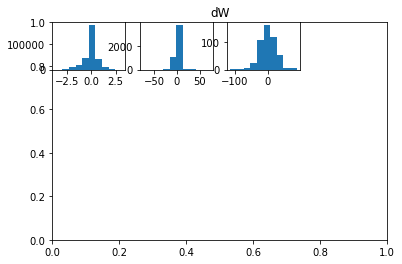

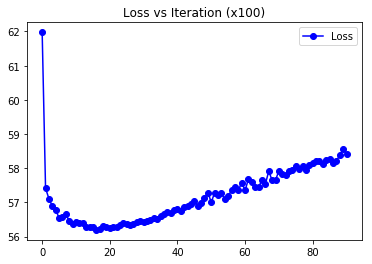

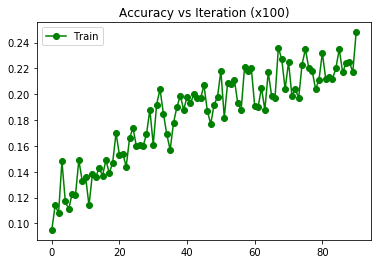

901


902


903


904


905


906


907


908


909


910


[0 8 3 1 1 4 1 2 2 0 0 8 6 3 0 3 4 4 0 6 8 8 5 0 3 4 6 2 7 0 5 9 1 0 9 8 9
 4 6 2 0 6 2 0 8 2 5 9 4 0 1 1 3 2 5 5 8 2 6 8 1 8 0 5 1 8 4 6 0 5 0 9 0 6
 1 5 9 9 6 2 2 0 9 4 8 7 5 4 6 5 0 5 6 1 9 9 7 5 0 9 5 9 7 0 6 0 5 7 9 8 5
 0 4 6 3 8 9 2 7 8 6 3 7 3 4 2 5 8 9 5 7 3 9 2 6 7 9 3 8 8 9 0 2 4 9 5 9 2
 5 8 2 8 7 7 4 5 0 4 4 7 3 8 1 9 1 1 5 7 9 3 1 6 7 1 5 1 1 4 2 7 0 9 9 1 4
 8 9 5 3 3 0 2 4 8 3 0 0 2 5 9 9 7 8 4 9 1 4 5 0 7 8 8 0 8 5 7 3 3 9 7 0 5
 9 8 5 0 4 8 2 4 3 7 8 8 9 4 7 8 0 2 2 7 1 3 3 0 3 0 9 5 3 8 6 2 8 5 5 1 9
 1 6 3 6 0 6 6 6 6 3 0 8 9 5 3 9 9 4 5 5 5 2 9 7 5 9 1 6 1 4 8 8 6 4 1 1 5
 8 7 9 1 0 7 4 3 8 1 7 8 7 0 3 8 0 1 0 3 8 5 7 6 5 2 5 9 1 9 6 2 5 3 4 4 0
 6 9 1 0 1 8 9 8 7 0 0 9 8 8 8 3 3 8 1 4 7 5 5 1 7 4 0 2 4 6 6 8 7 5 0 0 6
 9 2 9 4 7 3 4 1 3 7 9 1 6 4 8 1 5 2 6 2 2 4 7 1 0 0 8 6 3 5 9 4 5 8 9 3 4
 4 7 4 3 5 8 5 9 8 2 9 1 5 8 4 5 8 1 8 8 8 2 0 6 8 1 0 6 9 4 3 5 6 8 5 7 2
 0 5 9 8 6 2 9 4 5 1 6 9 4 6 1 9 9 0 2 9

942


943


944


945


946


947


948


949


950


[5 9 4 4 8 5 2 2 5 2 2 2 3 6 3 8 5 0 1 9 0 6 5 2 0 4 9 2 0 8 7 9 0 0 9 0 9
 2 6 0 0 1 7 6 3 0 7 4 0 0 8 1 8 3 0 5 6 0 6 9 6 9 0 5 8 8 9 6 0 2 4 9 4 9
 1 5 9 1 8 2 9 0 9 4 3 9 6 6 9 2 0 4 9 3 3 2 9 5 4 3 5 9 7 6 6 9 7 0 9 0 7
 5 1 8 9 5 6 0 2 8 9 0 7 3 2 8 6 6 9 0 7 4 5 6 3 3 9 4 7 0 5 3 6 4 5 6 3 5
 0 8 0 8 0 7 4 0 0 6 2 0 4 0 5 1 6 1 5 2 9 6 8 0 5 1 5 5 0 4 5 5 0 3 8 2 3
 3 4 2 6 7 6 5 4 0 2 2 1 2 8 5 2 7 2 4 5 0 9 0 8 8 1 8 0 8 6 6 0 8 3 7 6 2
 9 1 1 0 3 5 0 4 9 7 1 5 2 5 7 8 3 0 8 3 6 0 6 0 6 0 5 5 9 2 5 1 5 4 6 2 6
 0 9 5 1 7 0 1 0 1 9 0 1 7 5 3 5 9 8 9 2 4 9 9 1 6 9 5 8 7 8 5 9 9 4 7 6 4
 8 1 9 0 0 0 5 3 1 8 2 5 1 2 5 6 0 7 9 6 0 5 5 5 7 5 5 8 2 8 1 4 5 4 1 8 2
 1 9 3 4 6 1 7 1 6 0 5 9 0 6 8 3 5 0 7 4 7 5 8 3 3 2 2 2 0 6 3 5 4 5 8 7 5
 9 5 2 9 2 3 4 6 9 1 6 1 0 9 6 0 6 9 6 2 2 2 9 9 6 4 0 8 2 6 8 6 5 8 3 8 0
 4 1 9 0 4 9 7 6 0 1 9 3 6 8 4 2 3 4 1 7 0 9 0 9 5 5 0 9 2 3 4 8 7 5 2 5 2
 6 2 6 9 1 9 9 6 1 9 1 2 9 0 9 2 9 1 2 5 5 0 2

982


983


984


985


986


987


988


989


990


[0 3 1 4 1 4 4 8 2 7 1 7 3 3 0 3 0 9 0 9 0 6 0 9 0 4 5 2 9 8 9 2 1 0 5 8 1
 4 4 9 3 6 7 6 5 0 8 4 2 0 4 1 8 9 2 5 8 2 6 0 0 9 0 8 4 3 7 0 3 6 4 4 1 5
 1 5 7 9 6 0 2 8 2 4 2 6 5 6 9 2 0 5 4 1 9 0 0 9 0 0 7 3 1 2 6 8 9 0 2 0 2
 0 0 2 2 8 2 5 2 1 6 1 5 3 1 5 5 7 3 6 7 3 7 3 3 7 0 3 8 0 5 8 4 0 9 8 8 5
 8 6 3 7 2 7 4 4 0 8 4 7 4 4 5 1 5 2 2 1 9 0 8 2 5 1 1 6 1 5 5 7 0 3 8 7 4
 8 3 0 8 7 0 5 4 7 0 9 0 5 2 7 0 7 0 8 3 3 3 5 4 7 3 3 0 1 3 6 0 9 4 8 3 5
 7 8 1 9 9 2 2 4 8 0 6 7 9 7 4 1 9 3 2 7 1 3 2 1 8 3 5 9 7 5 5 3 5 6 5 1 6
 6 9 1 6 0 0 1 6 6 8 2 6 4 5 6 7 6 7 5 9 3 9 2 0 2 5 4 6 3 2 4 8 2 4 7 6 9
 6 7 1 2 9 7 5 8 4 8 2 5 7 3 9 1 1 9 2 3 4 1 0 4 7 5 5 5 2 1 3 4 5 3 4 9 7
 8 8 3 3 3 0 9 1 6 8 5 7 6 8 0 3 9 6 3 4 7 5 7 7 7 8 4 2 3 6 1 5 7 9 1 0 0
 9 5 5 8 2 3 9 9 9 1 6 4 5 4 8 2 1 9 4 6 4 4 9 4 0 8 7 6 3 9 3 4 9 6 9 3 4
 0 1 9 8 4 9 0 3 0 2 9 1 6 0 8 2 6 3 3 7 6 8 4 6 5 7 6 6 5 1 6 6 3 6 4 7 0
 2 2 6 2 9 3 6 4 9 1 6 7 5 6 7 2 2 7 7 3 7 5 2

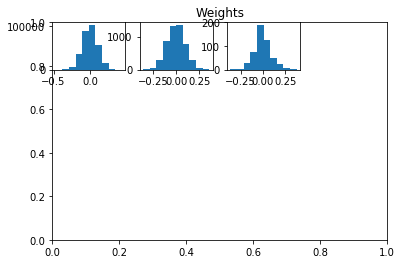

dW 0 Mean -0.035102513001 SD 0.406475615967
dW 1 Mean 0.114362685129 SD 4.19860194922
dW 2 Mean -5.49380470968e-05 SD 25.5111161528


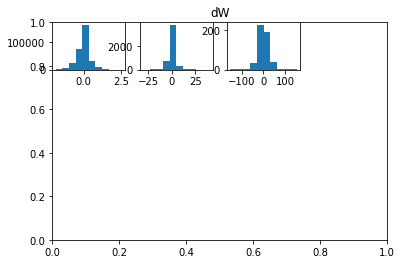

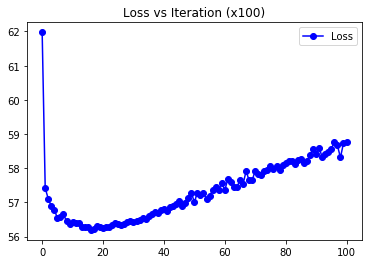

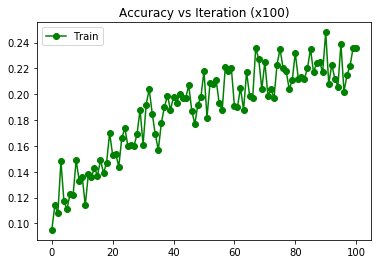

1001


1002


1003


1004


1005


1006


1007


1008


1009


1010


[6 7 9 0 9 4 2 9 5 7 0 8 2 2 7 4 7 6 5 8 7 4 5 0 3 8 8 7 6 8 9 6 1 0 5 8 1
 8 4 9 3 1 0 6 8 0 5 2 0 6 5 1 7 5 0 5 8 0 1 9 1 6 1 8 7 5 4 5 9 2 0 6 0 7
 0 5 6 2 3 2 9 6 5 7 5 5 5 7 0 8 3 5 9 9 5 9 0 9 0 7 6 5 0 2 1 4 1 7 2 8 8
 5 0 2 9 8 9 0 7 5 3 8 5 3 3 8 7 8 9 1 9 9 9 6 3 7 5 9 8 7 5 2 7 4 0 5 1 5
 7 9 6 7 0 0 3 4 6 4 6 2 0 4 1 0 7 2 2 1 3 4 1 0 7 1 3 1 1 5 5 5 4 9 8 4 1
 3 8 3 6 7 9 8 0 8 9 9 5 5 0 7 2 0 2 5 6 6 0 0 8 3 3 7 8 0 5 6 4 3 9 2 0 7
 0 8 1 1 0 6 2 2 8 7 3 7 9 7 5 8 2 3 2 0 1 3 4 2 2 0 5 9 3 8 5 3 9 4 5 1 5
 2 6 1 4 7 0 7 5 6 5 2 9 1 9 8 0 9 7 6 2 4 9 6 7 2 1 5 3 7 6 5 0 6 7 7 1 8
 8 2 0 0 7 5 1 0 0 3 2 7 3 1 0 1 5 1 7 4 1 1 5 2 1 0 8 4 2 0 3 6 5 1 0 9 0
 8 3 8 1 2 9 5 6 6 0 7 0 0 5 3 3 3 8 5 4 5 5 7 7 0 4 6 2 0 5 0 5 7 4 8 0 9
 6 0 0 5 2 8 4 0 2 1 4 1 6 6 9 4 4 4 4 8 0 6 7 3 3 4 5 9 0 5 3 0 5 5 3 0 6
 2 1 4 3 5 5 5 3 0 2 2 5 8 8 8 1 3 8 9 7 8 9 4 4 4 7 1 6 5 3 6 1 5 6 5 2 0
 0 9 8 9 5 8 9 4 9 1 3 3 5 0 5

1042


1043


1044


1045


1046


1047


1048


1049


1050


[0 3 3 4 5 0 1 4 5 9 4 0 2 3 0 3 4 4 7 5 3 9 6 7 4 0 5 4 6 8 0 9 1 4 0 0 1
 4 6 6 3 4 0 6 8 1 7 9 0 0 5 5 7 5 2 6 6 2 5 8 8 2 2 9 1 5 9 6 3 2 4 2 8 5
 1 6 7 1 3 2 4 6 2 0 2 3 5 2 5 4 6 1 4 3 3 7 0 4 4 9 4 5 7 2 6 4 9 7 2 3 5
 7 4 6 1 6 5 1 8 5 6 6 5 3 1 2 0 7 1 2 7 1 4 8 3 8 5 9 8 8 0 2 4 6 9 8 9 8
 1 9 3 7 7 5 4 5 3 4 5 2 0 4 1 5 6 1 5 5 9 2 8 0 8 5 8 1 1 4 1 5 5 1 0 7 9
 3 6 7 3 7 9 0 4 8 8 4 7 5 0 0 0 7 5 7 3 9 8 2 2 7 4 7 5 3 0 9 3 9 4 7 5 5
 6 3 6 5 3 6 4 0 6 0 3 7 5 7 5 1 3 3 8 7 1 3 4 1 3 4 5 1 3 2 9 2 1 5 1 1 9
 5 6 5 6 1 0 5 3 8 7 2 3 6 0 6 2 6 8 9 9 8 1 6 2 7 5 8 6 9 4 5 6 9 8 5 6 4
 8 1 6 5 5 0 5 3 5 1 4 9 9 7 3 1 5 0 5 4 2 5 0 6 0 8 9 5 2 0 4 2 8 8 4 9 2
 3 9 1 4 3 5 9 5 1 4 6 9 0 5 4 3 8 8 1 4 5 6 3 1 7 7 2 0 4 2 3 9 7 9 0 5 9
 8 8 6 8 2 9 9 8 3 5 6 1 8 9 2 0 1 3 2 6 4 9 8 7 7 1 7 5 0 2 3 6 2 4 7 3 7
 8 1 9 8 0 7 0 3 0 5 0 1 5 6 4 2 6 1 9 5 0 4 8 0 5 7 0 6 5 7 6 8 5 6 1 5 2
 0 9 9 8 1 9 5 6 5 9 1 3 5 6 5 9 7 1 

1082


1083


1084


1085


1086


1087


1088


1089


1090


[1 5 0 1 5 4 2 1 3 0 5 7 4 8 3 3 1 9 3 6 3 3 8 2 4 7 6 4 0 6 1 2 1 0 1 8 6
 6 9 3 7 6 2 1 4 5 6 2 0 2 5 6 8 5 5 9 6 2 6 9 3 0 0 5 5 8 4 1 3 5 0 2 7 7
 5 9 1 9 0 2 4 1 9 7 6 2 5 7 9 4 1 4 4 1 0 7 8 5 1 3 0 5 5 0 5 5 7 7 6 8 0
 9 0 8 6 5 9 1 4 8 9 1 2 3 2 3 0 7 9 2 1 3 9 6 3 7 0 3 0 6 0 8 4 4 2 6 2 9
 0 5 0 7 2 7 4 7 0 4 6 7 0 3 2 5 6 2 2 1 6 0 8 0 1 1 1 6 4 6 5 5 5 1 1 2 0
 3 2 5 5 7 6 1 1 7 6 4 0 5 6 5 4 5 0 3 3 0 4 0 8 4 8 2 8 0 4 5 3 3 0 1 8 4
 2 1 3 0 6 3 0 0 8 7 6 7 2 5 9 5 6 0 8 0 2 3 4 1 6 3 5 2 0 2 6 1 5 5 1 2 7
 2 0 1 9 0 0 5 9 8 0 2 3 7 5 3 0 3 7 8 2 8 2 9 6 1 1 5 6 1 2 4 0 5 0 2 0 7
 8 1 1 5 9 4 5 9 9 1 4 5 3 2 9 1 0 9 5 3 5 5 6 0 7 2 5 5 1 1 1 6 5 4 4 9 2
 6 6 1 9 2 8 9 6 9 4 1 7 6 6 8 1 5 8 5 4 5 5 5 9 8 0 6 6 0 6 6 5 4 0 0 0 9
 4 5 2 5 2 9 8 2 4 0 8 8 4 1 6 1 5 3 8 2 4 6 7 0 0 5 7 6 0 2 0 4 5 5 8 3 7
 8 5 9 3 0 3 5 3 4 0 4 6 5 6 4 5 6 1 3 7 8 8 0 0 4 9 2 6 2 1 3 6 9 8 4 2 6
 9 7 8 9 1 3 1 2 0 8 1 7 8 6 9 5 5 4 

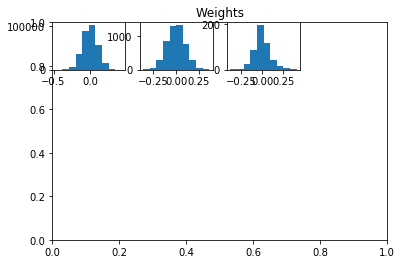

dW 0 Mean -0.0356666100072 SD 0.564449113732
dW 1 Mean 0.0523882291155 SD 4.97384632312
dW 2 Mean -5.49393937237e-05 SD 28.7887628559


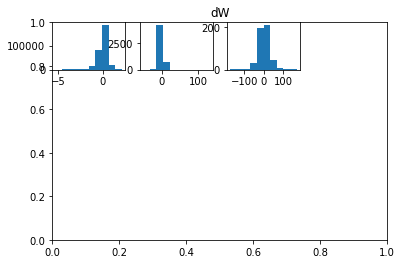

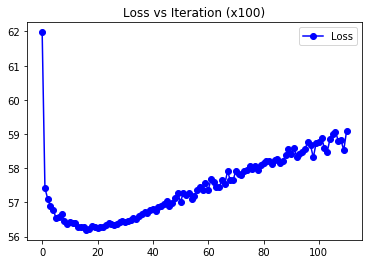

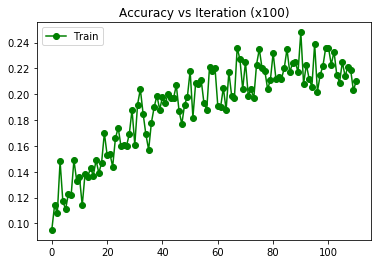

1101


1102


1103


1104


1105


1106


1107


1108


1109


1110


[1 7 1 8 5 5 6 8 0 6 1 7 9 0 0 4 2 4 3 1 7 4 7 2 4 0 5 0 9 5 7 9 6 1 1 7 0
 2 9 9 7 6 0 2 6 2 6 4 4 1 5 1 7 5 5 1 8 3 6 9 6 6 2 5 9 5 2 6 9 0 0 6 8 0
 1 9 1 4 6 2 0 6 9 9 3 5 8 5 5 6 0 5 4 1 5 0 7 2 0 3 2 9 0 0 3 4 9 6 2 3 5
 7 1 8 6 5 9 8 4 1 9 5 2 8 3 8 1 8 3 1 6 1 0 8 3 0 5 8 3 0 0 3 2 7 2 5 2 5
 8 9 3 7 7 7 3 9 1 9 5 2 3 4 5 0 6 6 0 5 9 6 7 0 7 4 1 6 1 4 1 7 0 9 7 9 1
 3 9 7 3 1 2 8 0 7 3 6 5 0 0 1 0 5 0 4 2 0 3 6 8 5 3 3 0 4 6 9 0 9 9 1 4 9
 6 7 6 2 0 6 2 6 8 1 1 2 2 5 0 8 2 0 2 0 2 0 3 1 2 3 9 5 1 7 9 1 7 1 6 6 6
 6 6 3 2 0 1 1 3 1 3 0 8 7 5 4 2 6 7 6 2 8 7 9 2 8 1 1 6 3 4 5 2 6 7 5 6 7
 6 7 7 5 6 7 1 1 5 8 2 7 1 1 6 1 0 4 5 3 2 8 6 9 7 6 5 5 2 3 6 5 9 4 0 4 0
 3 9 3 1 3 7 9 1 3 4 7 7 0 5 2 3 9 8 5 9 7 5 9 3 4 7 4 8 2 8 0 9 7 5 1 4 4
 4 6 3 5 3 9 5 6 4 5 9 8 6 1 9 9 0 3 5 6 4 4 3 8 7 1 8 8 3 9 8 4 5 6 1 6 1
 8 6 9 0 1 9 5 1 1 9 9 1 6 8 7 8 3 6 8 8 2 8 4 7 5 6 8 6 7 7 6 6 5 4 0 9 0
 0 3 5 5 5 3 9 3 5 6 1 4 6 2 1

1143


1144


1145


1146


1147


1148


1149


1150


[0 5 0 5 1 5 9 7 5 1 7 0 1 3 7 4 7 2 9 5 3 3 8 2 4 4 8 9 2 0 0 6 0 0 5 7 0
 2 0 6 7 9 2 6 3 1 9 4 4 6 1 5 4 4 5 9 5 2 6 3 3 6 0 6 2 3 9 2 3 5 4 9 8 6
 5 6 9 5 8 0 4 3 1 0 9 1 0 2 8 4 0 4 9 3 9 7 4 4 7 4 4 9 8 2 5 4 7 7 2 8 5
 2 1 5 3 8 6 0 2 5 3 2 9 9 6 7 6 7 2 2 0 0 0 6 1 9 9 9 7 8 0 3 8 4 0 5 2 5
 1 5 2 5 6 7 4 6 4 6 6 9 4 8 5 9 5 2 2 8 9 0 8 0 7 1 1 5 1 6 1 5 7 9 3 9 9
 3 6 0 3 5 2 0 1 0 1 8 4 2 6 1 6 5 3 2 3 3 0 7 4 7 1 3 8 0 8 7 3 3 3 7 8 2
 9 8 3 0 0 9 0 6 6 5 6 6 9 8 7 4 3 3 0 7 3 2 3 7 8 3 9 1 1 1 4 3 1 1 1 1 5
 6 8 3 5 7 0 1 2 3 8 0 1 7 5 4 0 8 7 5 5 9 5 5 2 8 3 9 6 1 0 1 8 2 4 1 2 9
 6 7 0 2 7 7 9 2 9 8 8 9 1 3 8 6 1 4 5 3 8 6 8 2 0 6 8 4 1 9 6 2 5 4 4 4 0
 3 9 3 1 3 8 0 8 2 4 7 7 0 5 8 3 8 0 5 5 5 0 7 6 4 2 8 0 0 8 6 2 7 5 0 8 7
 6 2 2 8 2 4 9 2 8 9 6 1 5 9 6 4 1 2 1 6 2 7 7 0 9 4 5 9 0 2 2 4 9 5 9 0 1
 2 1 9 8 0 9 0 3 2 8 8 8 5 4 5 2 2 4 9 5 2 6 7 8 5 5 1 5 2 3 7 8 2 9 1 5 2
 1 9 3 2 5 7 9 2 4 6 3 0 4 6 7 5 1 1 7 2 0 5

1183


1184


1185


1186


1187


1188


1189


1190


[2 0 3 1 5 4 6 6 2 9 0 2 3 3 3 3 0 9 5 8 3 6 2 2 3 4 5 9 2 9 5 6 1 0 7 7 1
 8 9 6 7 6 0 2 6 2 2 3 1 6 7 1 8 6 7 2 4 3 1 4 1 6 2 0 2 0 9 6 2 0 0 1 0 9
 4 6 9 4 0 0 9 0 1 0 2 3 5 0 8 5 0 4 6 1 1 7 8 4 7 9 2 3 8 0 6 0 7 1 9 2 2
 9 0 8 4 5 6 4 8 5 3 0 2 3 2 8 6 6 1 1 6 0 1 5 3 3 0 3 5 6 0 0 7 8 0 5 8 5
 3 9 0 5 0 7 6 2 0 9 1 0 4 0 5 6 6 2 2 5 9 0 4 0 7 2 5 1 1 6 5 5 2 2 0 5 4
 8 2 7 3 5 0 5 8 8 1 2 0 2 0 1 6 4 2 5 8 0 3 0 7 7 2 0 6 8 9 9 4 2 4 7 6 5
 2 5 1 0 1 6 0 2 0 5 6 2 5 8 0 1 0 0 2 9 1 3 9 0 2 3 9 3 3 2 5 1 9 6 5 1 6
 6 8 3 4 0 2 5 6 5 3 6 6 1 9 2 2 9 7 9 9 4 5 5 1 2 3 3 8 3 1 1 5 5 4 2 2 4
 6 1 7 1 6 7 5 9 4 6 9 4 1 1 0 6 7 3 0 3 5 5 5 7 7 6 6 4 8 2 0 1 9 3 0 4 2
 3 9 3 1 3 8 2 6 9 4 2 7 3 2 4 3 9 0 0 8 0 3 2 3 1 5 6 6 0 6 5 9 7 2 6 8 9
 4 2 2 8 9 3 5 2 4 7 6 9 4 4 5 4 1 0 7 9 8 9 5 7 4 0 5 6 4 9 2 4 5 6 3 3 0
 2 8 6 3 5 5 0 1 8 1 4 1 2 4 4 8 7 1 3 7 2 0 4 1 8 7 6 5 7 3 3 4 9 6 1 2 2
 0 2 6 8 9 3 6 2 5 1 1 7 2 8 5 5 5 0 7 9 5 8

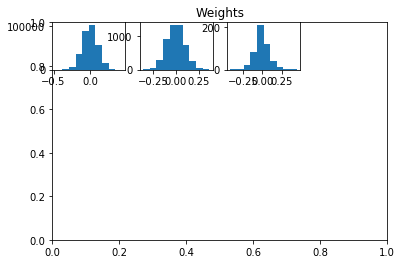

dW 0 Mean -0.019824530108 SD 0.49233341074
dW 1 Mean 0.0582881526384 SD 4.63943535238
dW 2 Mean -5.4940064808e-05 SD 22.5729679022


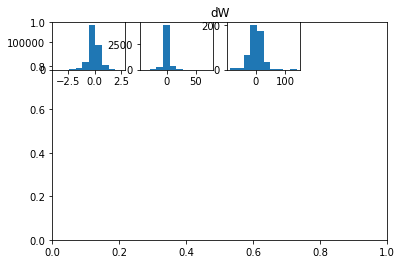

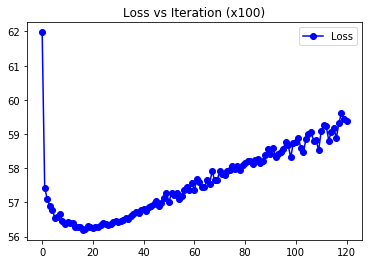

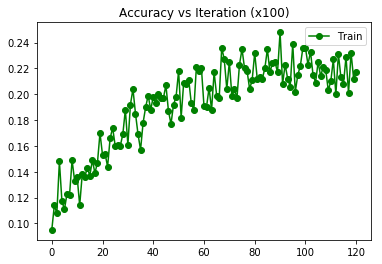

1201


1202


1203


1204


1205


1206


1207


1208


1209


1210


[6 0 3 1 1 4 5 3 9 2 7 3 2 6 6 3 0 6 5 8 3 4 6 0 3 4 5 2 2 5 0 9 1 4 4 0 8
 4 4 3 7 5 0 0 9 1 8 4 1 1 7 5 6 4 2 0 8 9 1 4 1 0 0 1 8 8 5 1 3 2 8 2 8 9
 7 5 1 1 3 0 8 6 1 7 2 1 2 6 5 7 0 5 7 3 1 0 1 2 8 3 2 9 8 0 6 9 7 7 2 4 8
 7 3 8 2 8 6 1 2 4 6 3 5 1 3 1 0 9 3 2 7 1 9 6 1 0 5 3 4 6 0 3 4 0 0 5 1 2
 6 7 3 1 0 8 1 0 7 6 6 9 4 4 1 1 7 6 2 6 9 0 5 1 1 1 1 6 1 8 0 3 5 5 7 1 4
 9 6 8 6 3 9 4 8 8 1 6 5 7 8 9 0 1 5 2 3 8 2 4 0 5 4 0 8 9 0 6 5 3 3 2 5 2
 9 8 6 9 5 8 0 3 0 5 6 7 9 0 4 4 4 0 2 3 1 0 0 6 3 7 5 9 1 1 1 9 2 1 5 8 9
 0 5 0 7 1 0 7 2 3 8 0 6 7 0 9 6 9 5 6 9 6 2 0 0 7 1 1 6 1 2 4 8 9 4 5 2 8
 6 7 5 5 7 8 1 2 7 8 7 5 7 2 9 6 1 7 9 3 2 5 7 4 9 6 8 4 0 7 3 1 9 3 0 9 7
 3 6 9 0 6 1 2 8 1 4 0 1 0 5 0 3 9 0 1 4 4 8 3 9 7 2 2 2 0 6 0 0 7 9 8 7 9
 6 6 7 8 1 3 8 6 9 0 9 5 8 6 0 4 7 9 2 6 8 2 9 4 8 1 5 2 7 6 6 0 5 5 9 2 0
 7 6 0 8 0 3 5 3 2 3 0 1 9 5 8 1 6 6 2 7 6 9 0 3 9 7 3 6 5 8 4 4 0 5 6 7 6
 5 9 9 5 3 9 9 5 9 8 7 7 7 0 5

1243


1244


1245


1246


1247


1248


1249


1250


[2 0 3 4 9 1 1 8 2 2 6 7 2 8 0 5 2 3 7 5 7 4 7 1 3 4 6 0 7 6 0 2 0 1 4 7 1
 1 3 5 0 9 0 2 1 1 3 2 2 2 3 1 7 7 0 0 1 2 1 3 9 9 2 3 9 1 8 7 9 0 9 2 7 8
 5 5 5 0 0 4 4 3 2 4 9 5 8 4 1 9 6 5 4 5 0 6 4 4 8 7 0 0 0 1 6 1 7 7 9 2 7
 7 0 6 6 8 4 0 3 5 3 6 0 3 6 3 1 8 3 2 3 4 2 6 7 2 5 4 5 0 7 3 2 0 0 5 3 8
 0 8 0 2 7 7 1 5 6 4 8 0 4 4 9 5 6 1 0 5 6 4 4 5 7 1 9 1 1 8 0 8 6 9 9 5 4
 9 2 7 3 6 2 1 4 7 9 0 2 2 6 9 9 4 5 1 3 9 7 6 7 7 2 5 1 3 4 9 1 2 9 2 4 6
 9 9 3 1 4 6 2 0 6 1 9 7 2 7 0 4 0 9 2 7 1 3 2 3 3 0 0 9 7 0 1 0 1 1 2 2 9
 2 6 1 4 0 0 9 7 3 8 0 6 8 0 2 3 9 2 6 2 7 7 1 1 7 1 8 3 1 8 4 9 9 7 1 1 4
 6 2 7 2 0 7 4 3 5 9 4 7 1 7 9 6 0 1 9 3 1 5 7 9 7 0 5 4 2 7 3 4 5 3 1 9 0
 8 9 0 0 8 9 0 5 3 0 0 1 9 9 7 3 5 0 6 4 0 5 8 1 8 7 0 2 0 9 0 5 2 0 0 8 0
 2 9 2 7 1 0 3 8 2 0 3 4 6 8 6 4 7 2 0 5 2 6 7 9 3 7 8 9 3 9 3 4 9 5 3 9 1
 4 6 9 3 7 3 5 6 1 2 4 1 4 6 7 2 8 4 1 8 0 9 0 3 8 5 9 6 9 3 3 4 6 0 2 7 2
 4 3 3 9 3 9 6 9 9 7 8 2 4 7 9 5 5 0 7 9 0 5

1283


1284


1285


1286


1287


1288


1289


1290


[0 5 7 5 1 4 2 2 5 7 1 8 2 0 3 3 4 4 7 1 3 4 2 7 3 7 5 2 6 6 5 9 1 0 0 7 2
 5 4 5 7 9 0 1 3 1 5 4 1 1 1 2 8 9 0 9 6 2 6 8 5 6 0 5 1 7 9 1 9 5 4 5 7 8
 1 9 1 5 0 0 1 0 7 0 1 9 5 4 5 9 5 4 8 5 2 6 5 0 1 8 4 5 5 0 1 1 7 7 3 8 8
 5 3 6 1 6 6 0 8 6 9 0 0 3 6 8 0 0 9 2 1 0 5 5 3 3 0 3 8 8 0 2 8 8 2 6 9 2
 7 5 3 7 7 7 1 4 0 9 8 2 4 8 1 5 5 2 2 8 9 0 5 7 4 1 5 8 3 6 5 5 9 5 7 5 3
 3 2 7 3 5 2 0 8 7 5 2 5 0 0 5 2 5 2 2 2 0 7 4 8 8 3 4 6 0 8 7 8 0 3 5 0 7
 2 1 5 3 0 9 2 6 6 0 0 7 9 6 5 8 3 2 2 6 1 2 3 1 2 0 4 1 9 1 5 0 5 6 6 6 7
 1 5 3 7 6 2 5 9 1 5 0 6 7 9 4 2 6 7 5 6 4 7 2 2 7 0 4 3 9 3 5 8 2 0 2 1 0
 9 1 0 1 7 7 5 6 5 2 9 8 5 3 9 1 0 1 5 2 2 5 9 4 1 0 5 4 1 0 4 4 8 1 0 5 7
 3 8 8 8 4 6 7 8 3 0 0 7 9 9 8 3 5 6 1 9 0 0 7 9 0 2 1 2 2 6 1 5 7 9 5 8 4
 6 0 3 7 3 9 5 2 9 9 6 9 9 4 8 4 1 1 4 5 1 9 7 0 8 7 0 2 3 5 9 6 5 5 6 9 0
 0 0 9 8 5 6 0 0 2 9 3 6 5 4 2 2 8 9 8 8 6 6 4 9 2 0 2 9 2 3 7 4 5 9 2 7 6
 6 3 5 7 5 0 1 9 5 6 9 7 6 7 9 2 6 2 7 2 0 9

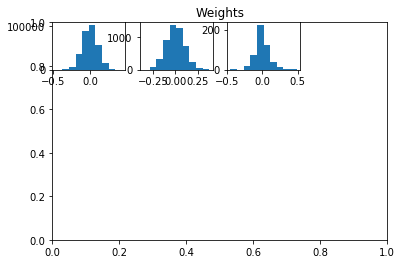

dW 0 Mean 0.0194285870681 SD 0.788084651162
dW 1 Mean 0.0476431854757 SD 6.51314229098
dW 2 Mean -5.49398495463e-05 SD 36.7367922165


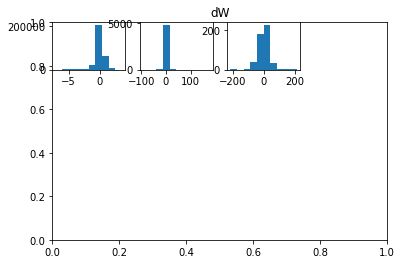

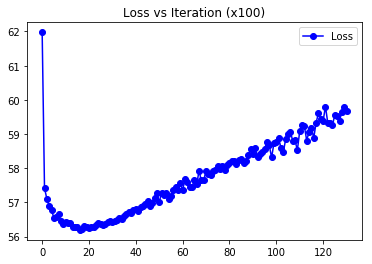

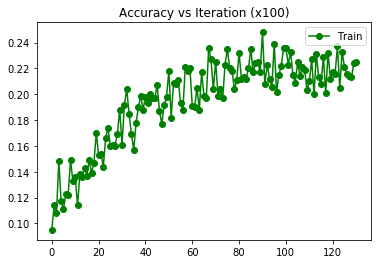

1301


1302


1303


1304


1305


1306


1307


1308


1309


1310


[0 0 7 0 9 4 7 1 9 7 0 7 3 3 3 8 0 9 0 4 8 6 2 9 1 4 9 7 2 5 7 9 1 4 4 8 1
 2 3 3 7 5 0 6 8 1 7 9 1 8 8 6 8 4 2 0 4 2 1 4 0 5 0 8 2 3 9 6 0 2 5 5 3 8
 0 9 1 1 3 2 8 6 7 7 6 2 9 2 8 9 8 0 4 3 6 0 4 4 7 3 2 5 5 6 1 9 7 7 9 6 2
 5 3 2 6 5 2 6 3 8 3 2 2 9 3 2 0 7 3 6 9 1 9 6 3 7 0 3 6 0 9 3 8 9 9 6 2 7
 1 9 3 2 5 7 1 5 1 4 8 0 3 4 3 0 6 1 5 8 9 0 4 0 1 1 8 6 1 8 0 3 0 2 7 1 4
 3 3 0 3 7 0 0 8 5 1 2 0 2 8 9 0 5 5 2 2 5 0 0 7 7 3 0 0 8 5 5 4 1 3 2 4 7
 5 3 1 0 3 9 4 6 6 5 6 8 5 8 0 8 0 3 7 3 1 3 0 2 4 0 5 9 1 2 0 1 9 4 5 6 0
 6 6 3 7 6 0 9 5 8 3 0 6 7 1 2 2 4 0 8 6 6 9 6 2 8 1 4 0 9 1 5 8 9 0 1 6 4
 9 7 1 2 9 4 5 3 5 1 4 7 1 6 9 1 5 1 5 3 5 9 0 6 7 5 6 9 0 3 1 2 5 3 6 9 0
 1 8 1 6 8 8 0 5 3 4 7 1 9 5 7 3 3 6 8 4 7 5 0 3 0 1 5 6 2 0 0 5 7 5 7 0 9
 0 9 7 9 3 9 3 6 9 2 6 1 9 4 9 2 1 1 9 6 5 6 7 2 0 5 7 5 3 6 0 8 5 6 6 6 4
 4 8 9 3 5 7 2 6 2 1 2 3 1 6 0 1 5 8 3 6 2 6 0 8 2 1 1 6 7 3 6 5 2 6 3 2 0
 0 0 3 9 9 3 1 4 3 0 8 7 8 0 5

1343


1344


1345


1346


1347


1348


1349


1350


[8 8 8 0 7 0 1 4 5 4 2 8 3 3 6 3 4 0 3 9 3 9 2 7 3 4 1 4 2 5 2 6 1 0 1 7 1
 2 4 9 0 9 0 0 8 5 3 4 2 2 1 1 8 5 7 5 4 9 6 5 0 6 0 3 7 0 9 2 9 2 3 9 3 6
 1 9 1 0 0 2 4 3 1 7 1 2 2 4 0 2 3 3 4 3 6 0 7 8 0 9 0 5 5 0 5 4 1 0 3 3 5
 9 0 1 6 6 9 0 8 5 3 0 1 3 2 2 7 7 9 1 9 9 0 2 3 2 5 3 8 6 7 3 2 4 6 8 9 5
 3 8 8 1 0 2 3 2 3 9 6 3 8 4 1 6 7 6 2 6 2 4 4 1 1 4 3 6 1 8 5 3 5 1 7 9 4
 8 2 8 6 7 2 4 8 7 1 3 5 2 6 7 4 7 8 3 3 8 0 1 4 7 1 5 0 0 8 6 5 3 9 0 6 1
 0 7 6 2 5 6 4 6 8 5 1 6 2 0 0 2 0 3 2 7 3 8 3 2 8 4 0 1 1 1 7 3 5 1 6 6 2
 2 5 1 1 0 0 5 3 1 5 6 3 7 3 6 2 9 3 9 5 5 1 9 2 3 6 9 3 3 2 5 5 0 4 2 6 0
 6 7 7 2 0 7 9 3 8 8 4 7 1 5 5 1 0 7 5 3 2 6 5 9 0 5 6 4 8 3 3 4 5 8 1 8 2
 6 6 3 1 1 5 7 6 1 0 7 1 2 5 8 3 3 0 6 3 4 3 7 1 0 2 2 6 0 9 0 5 6 0 5 3 0
 9 6 0 9 1 3 5 1 4 7 9 6 9 0 9 2 1 0 4 5 4 6 7 4 5 2 8 5 3 9 3 4 9 6 3 6 4
 2 1 9 3 9 5 5 8 1 5 4 0 2 6 7 1 6 4 3 3 2 8 4 0 5 7 6 6 2 3 2 5 0 6 5 2 0
 5 3 6 2 1 9 2 2 5 8 1 7 5 6 1 2 1 0 7 9 2 8

1383


1384


1385


1386


1387


1388


1389


1390


[0 8 6 4 5 9 6 2 2 1 6 6 1 6 0 5 0 8 0 1 3 4 2 7 3 4 6 8 7 0 2 4 1 0 7 0 3
 4 6 9 1 5 0 0 2 1 5 9 1 8 4 5 4 0 5 9 6 3 6 6 5 9 0 8 1 8 5 8 0 2 3 2 8 6
 1 6 9 1 3 0 2 6 9 0 6 3 4 4 0 9 0 4 2 1 3 7 4 5 8 9 0 4 3 1 6 1 7 7 2 3 0
 8 8 1 8 8 9 0 2 8 9 3 2 3 6 3 0 7 1 2 9 4 9 6 3 9 5 0 6 8 5 9 4 4 9 5 3 8
 0 9 6 7 1 7 4 0 1 4 6 9 9 0 9 1 1 6 9 6 8 1 5 0 7 4 4 8 1 6 1 1 6 3 7 1 0
 3 6 7 3 1 0 1 4 7 8 0 5 5 6 1 0 1 2 3 3 9 8 0 0 7 1 5 0 3 4 5 8 3 0 5 9 3
 0 3 1 7 1 9 2 0 5 1 0 7 5 6 0 6 6 3 8 0 4 0 2 6 6 7 0 3 3 4 1 4 5 5 6 1 5
 0 4 1 5 0 0 1 2 0 8 0 8 7 0 4 0 5 8 9 5 5 0 5 1 7 1 8 6 9 0 5 4 9 4 2 6 0
 6 4 7 0 7 7 1 0 5 8 4 8 3 0 1 1 9 0 2 3 2 5 7 5 5 1 5 9 1 0 6 6 9 3 7 9 5
 0 9 1 8 6 0 9 8 3 0 7 0 9 6 2 3 9 8 1 9 4 5 9 9 2 2 9 8 0 3 8 9 7 3 1 8 7
 6 8 3 9 4 3 5 1 5 0 4 1 9 0 8 1 1 3 2 6 2 2 8 2 0 7 8 9 4 5 3 0 5 6 6 5 1
 0 5 9 3 7 3 5 3 2 1 4 1 1 8 0 7 6 1 3 4 2 6 0 8 5 2 6 6 7 3 3 5 2 9 0 5 2
 0 3 5 6 5 7 0 4 0 1 9 9 9 6 5 5 5 7 8 9 5 9

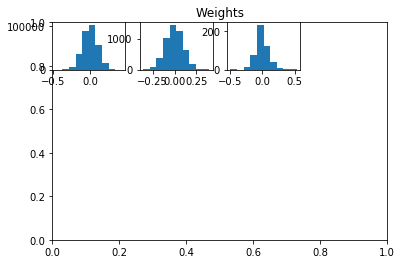

dW 0 Mean 0.0171397313004 SD 0.824195772824
dW 1 Mean 0.192326430807 SD 7.01880142623
dW 2 Mean -5.49398751127e-05 SD 33.1419689556


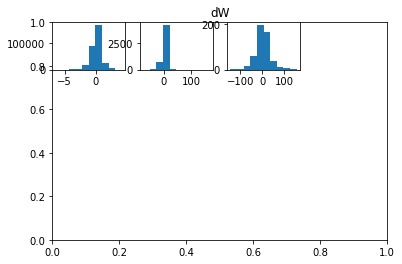

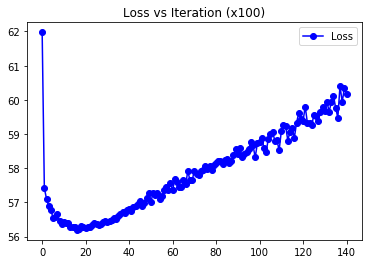

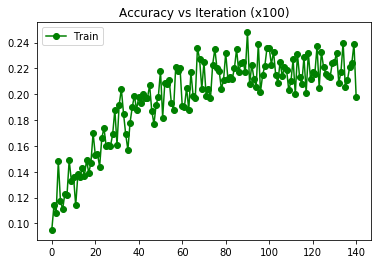

1401


1402


1403


1404


1405


1406


1407


1408


1409


1410


[8 8 3 7 5 4 4 3 2 6 5 7 3 3 0 9 0 4 5 4 3 4 0 7 0 4 3 8 2 5 7 0 1 2 9 8 8
 4 0 9 6 4 5 3 1 1 6 8 1 1 0 5 8 2 7 1 1 3 1 5 5 6 0 3 9 5 5 2 9 0 4 2 0 6
 1 6 9 4 0 2 4 6 1 7 6 4 4 7 1 8 1 4 4 1 3 0 7 4 0 4 1 5 9 0 3 4 9 7 2 3 8
 5 3 6 1 5 6 5 2 5 6 3 5 3 1 3 0 8 3 6 0 3 4 1 3 6 0 3 0 0 0 8 4 0 6 9 3 5
 6 7 3 8 8 7 4 7 0 8 4 2 8 4 1 0 1 2 5 5 9 4 8 0 7 1 1 1 4 6 5 1 5 5 0 9 0
 9 9 5 2 5 0 0 4 9 5 9 5 0 2 7 2 4 0 1 7 3 3 2 7 0 8 0 6 0 0 7 0 7 3 7 6 7
 0 7 1 2 5 9 2 2 9 7 9 8 2 7 5 8 0 1 9 7 1 3 7 2 0 4 5 5 3 7 9 0 2 0 6 1 5
 2 5 1 5 9 1 9 6 8 8 0 3 1 0 3 0 5 6 5 5 4 7 6 7 8 3 0 0 1 4 9 2 9 4 1 0 3
 6 7 1 3 7 4 1 1 9 3 9 7 1 5 8 1 0 1 2 8 0 6 5 9 9 8 9 4 1 2 4 4 5 3 7 4 0
 3 9 9 9 1 1 2 1 4 0 7 9 6 4 0 3 5 6 8 4 4 5 3 5 0 7 2 0 0 6 6 5 7 4 6 4 9
 5 9 3 8 3 1 5 6 9 5 9 4 1 9 1 1 3 3 0 9 2 2 7 9 0 5 3 9 0 0 3 4 5 7 6 2 8
 0 6 9 8 0 9 0 9 0 3 2 1 3 9 2 2 3 8 9 8 7 4 0 8 4 4 1 9 8 3 4 4 2 5 2 2 2
 0 5 9 2 1 3 9 5 9 1 1 3 7 7 5

1443


1444


1445


1446


1447


1448


1449


1450


[2 9 3 6 5 9 2 3 2 6 9 9 4 3 0 3 6 4 1 9 0 9 7 7 3 8 1 0 2 6 5 9 1 4 9 8 1
 4 4 0 7 5 6 0 1 2 0 9 0 0 8 0 7 5 5 5 9 4 1 4 5 9 1 0 8 6 9 7 0 0 3 1 0 8
 0 6 1 5 0 0 4 6 2 5 6 6 0 7 0 6 0 4 4 5 5 7 4 0 8 9 2 0 7 0 6 8 7 0 9 4 0
 5 0 5 8 6 6 0 7 8 6 2 5 3 1 2 0 8 1 6 7 0 7 6 3 9 9 1 8 6 0 8 4 7 0 6 3 5
 7 6 2 2 5 3 1 7 6 4 6 2 0 0 9 1 2 9 2 5 8 3 0 6 7 1 5 5 4 4 0 5 0 9 9 5 6
 9 9 3 4 1 4 5 1 9 9 9 0 2 6 0 2 4 2 1 9 1 2 0 8 7 4 5 6 0 0 6 5 9 4 0 0 7
 9 8 4 9 3 6 0 4 6 0 9 4 0 0 0 4 7 3 9 7 2 1 6 1 4 7 1 5 7 7 4 2 7 9 0 2 5
 1 6 4 5 0 6 1 7 1 8 0 8 1 5 4 5 9 4 9 2 5 9 0 6 7 3 6 8 3 0 4 5 6 0 0 2 4
 4 2 6 0 7 7 5 3 4 8 9 9 1 7 1 8 0 1 8 3 2 8 6 9 1 0 6 9 1 8 4 1 5 3 0 8 0
 5 8 3 6 8 2 0 6 1 0 7 7 6 4 2 3 4 0 1 4 0 8 9 3 8 1 8 6 0 6 0 5 7 1 7 7 8
 9 9 7 9 2 0 4 9 4 7 0 1 6 9 2 4 6 9 2 6 0 9 7 0 0 1 7 6 0 6 2 4 9 5 6 2 4
 6 1 9 8 0 5 7 9 8 9 3 3 1 8 0 2 5 1 9 2 6 9 1 4 4 9 1 6 2 8 6 4 0 0 0 2 8
 0 0 8 8 0 3 0 9 9 8 7 7 5 0 1 9 0 1 1 9 5 8

1483


1484


1485


1486


1487


1488


1489


1490


[0 7 4 4 1 9 6 2 1 2 8 7 1 0 3 3 0 0 0 3 3 3 2 6 3 4 6 1 0 8 0 2 1 0 7 0 5
 5 4 5 8 6 0 6 1 1 8 9 2 0 1 5 5 5 0 0 0 0 1 8 0 6 0 8 7 8 9 8 9 2 4 5 7 6
 7 9 9 1 0 5 4 6 5 9 9 5 4 7 0 2 1 1 7 5 6 7 0 4 8 9 2 9 3 5 6 5 7 7 2 3 5
 7 0 2 6 6 9 0 0 5 6 6 5 3 3 5 0 7 9 6 5 9 7 6 3 7 5 8 6 6 0 0 7 5 5 6 3 5
 3 9 1 8 1 7 1 0 3 4 5 3 4 4 4 1 2 6 5 6 2 4 0 0 7 1 1 6 1 6 5 5 2 9 7 9 0
 3 3 7 9 5 0 5 3 5 1 0 0 5 6 0 0 1 5 7 5 8 7 0 2 8 6 2 8 0 4 6 3 0 0 7 3 6
 0 9 1 0 5 5 0 0 6 1 0 7 0 7 5 1 7 0 0 0 0 8 2 0 5 7 5 3 1 7 1 2 5 6 5 6 6
 6 9 8 8 0 6 1 3 6 8 0 8 6 1 0 5 3 1 5 2 7 1 6 8 7 6 5 0 1 2 1 4 9 4 5 0 8
 9 6 6 0 7 7 4 3 4 8 4 7 9 6 5 0 1 4 5 3 4 1 0 4 0 7 5 0 2 7 0 4 8 0 7 4 0
 3 8 3 8 1 6 9 1 7 0 7 9 6 2 4 0 2 8 0 8 5 3 5 6 0 0 9 2 0 6 8 5 2 8 6 6 9
 5 6 0 8 2 3 6 4 5 2 9 8 9 0 5 1 7 3 9 9 7 4 9 7 0 4 7 6 3 2 3 6 5 9 3 9 9
 2 5 4 0 0 8 7 9 2 3 9 6 1 6 4 5 9 0 2 9 2 3 0 5 5 7 3 6 5 1 0 8 0 0 4 5 1
 0 9 9 5 5 3 1 9 1 1 9 7 5 8 9 9 9 6 2 9 0 9

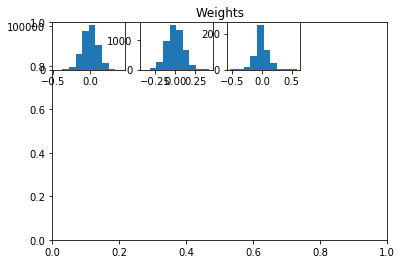

dW 0 Mean -0.0127423003784 SD 1.03140718631
dW 1 Mean 0.121266258769 SD 8.8019662055
dW 2 Mean -5.49406211337e-05 SD 38.821132403


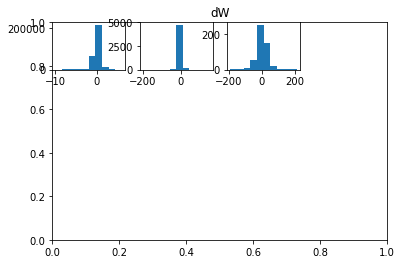

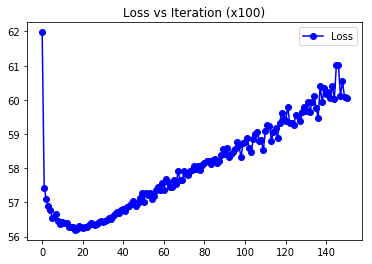

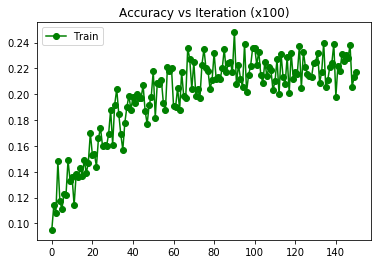

1501


1502


1503


1504


1505


1506


1507


1508


1509


1510


[6 6 3 5 0 4 6 7 0 1 0 3 2 7 6 9 0 1 0 0 3 4 2 8 0 9 5 2 9 9 0 0 1 1 9 7 8
 1 6 0 8 0 7 1 3 2 7 9 0 6 1 5 8 5 0 0 8 0 1 4 0 9 0 7 8 8 5 0 3 5 3 9 7 5
 9 8 9 4 9 3 1 6 2 7 6 6 1 0 8 0 5 5 2 1 5 8 7 0 7 9 0 0 9 8 5 0 9 7 2 8 8
 9 0 1 3 6 9 4 4 4 3 1 2 3 4 3 8 7 3 2 7 0 9 6 3 7 5 3 6 0 7 3 4 5 9 6 3 5
 7 5 9 5 7 8 1 0 9 8 0 0 9 4 1 6 6 2 2 1 7 4 9 5 4 1 9 6 8 8 0 5 0 3 7 0 4
 3 9 1 5 9 2 1 8 8 0 6 9 5 6 1 4 7 0 3 5 0 3 5 7 0 4 7 8 3 5 6 5 1 4 1 4 7
 2 1 5 2 0 2 2 4 6 4 6 7 5 5 0 4 7 1 2 7 4 8 2 2 0 3 9 3 2 7 0 1 8 4 5 1 7
 5 5 3 5 1 0 5 3 8 8 2 1 7 0 4 7 0 7 5 3 6 4 9 8 6 3 5 6 3 4 1 0 7 8 2 6 3
 6 1 8 0 7 4 4 1 8 9 9 7 3 7 1 6 1 7 8 6 9 5 0 2 7 6 5 0 0 4 4 4 8 3 4 9 0
 6 4 0 6 6 5 7 6 1 4 6 7 6 5 8 3 3 6 1 8 5 8 0 6 7 7 2 0 0 6 5 2 7 3 0 0 7
 5 5 7 7 3 3 9 4 4 7 9 6 9 6 2 0 4 0 6 6 7 9 3 2 0 1 7 9 0 0 2 4 9 4 6 5 1
 0 8 9 8 5 9 5 3 4 1 0 6 2 5 2 7 5 5 3 6 0 9 0 0 8 6 2 6 6 3 7 8 0 6 0 5 0
 0 3 9 7 1 3 0 8 3 1 5 3 1 8 3

1543


1544


1545


1546


1547


1548


1549


1550


[5 9 7 1 5 0 7 2 9 1 9 8 0 3 3 9 2 1 0 7 3 4 7 0 4 4 5 8 6 0 5 0 1 0 4 3 6
 5 0 3 3 9 0 3 3 5 0 9 4 8 1 0 8 0 7 7 1 4 6 9 7 9 2 3 5 0 6 7 3 0 4 9 8 7
 1 9 0 1 3 0 0 6 1 1 3 3 4 7 6 2 0 0 2 9 5 6 9 4 8 3 4 9 5 8 5 9 5 7 0 8 5
 5 0 1 1 0 4 7 8 9 9 3 2 3 0 3 5 7 9 1 7 1 9 1 0 7 6 0 6 6 0 3 5 8 6 8 3 5
 1 9 0 9 5 5 1 0 6 4 8 2 4 4 1 6 7 6 2 6 6 3 9 0 7 1 3 1 4 6 1 5 5 9 1 9 0
 3 9 3 5 1 2 0 4 8 6 7 0 2 6 5 9 4 5 3 9 1 4 1 0 7 8 0 6 3 5 7 7 7 3 2 3 5
 7 7 4 0 5 6 0 0 6 0 9 5 5 5 0 1 1 1 2 7 3 3 2 5 0 4 5 0 3 6 1 1 9 0 1 1 4
 6 5 3 7 1 6 6 9 8 5 0 1 7 0 1 0 9 8 5 6 8 0 6 7 5 1 8 0 3 0 9 6 0 0 5 6 5
 6 2 8 5 7 8 1 3 1 1 0 9 5 4 1 6 9 2 9 3 0 5 0 9 1 8 9 0 2 8 6 1 9 9 7 4 4
 6 9 3 8 1 1 7 1 3 4 0 1 6 2 3 3 3 0 6 4 0 0 7 9 4 4 1 0 2 6 6 4 7 9 1 0 7
 4 1 7 7 8 3 9 1 5 7 9 1 9 4 7 4 0 3 1 6 1 7 9 4 0 9 6 5 3 5 9 0 5 5 6 9 1
 2 5 7 3 7 4 0 3 1 2 3 7 1 6 5 2 6 0 3 3 6 1 8 7 5 5 6 6 7 3 4 6 9 6 1 1 0
 0 5 5 9 1 7 1 9 1 6 3 7 6 5 3 9 9 1 1 0 5 5

1583


1584


1585


1586


1587


1588


1589


1590


[6 1 7 1 5 4 6 7 9 4 0 0 2 6 0 3 0 3 0 8 3 4 2 2 4 9 6 2 2 6 2 6 1 0 9 7 5
 8 0 9 2 9 7 1 5 3 7 9 1 0 4 0 8 2 7 7 4 0 2 9 7 9 0 9 7 8 9 1 3 0 4 1 4 7
 3 9 0 8 3 2 8 6 0 4 7 2 1 0 8 2 0 1 2 1 9 2 4 9 7 4 2 1 7 2 5 5 7 7 9 8 0
 9 3 2 6 0 9 0 4 5 9 3 5 3 2 3 6 0 3 1 5 1 7 1 3 3 9 1 6 6 7 8 4 5 6 6 0 5
 7 5 6 7 7 7 1 7 3 4 0 9 0 0 1 1 0 2 5 5 9 1 5 0 7 1 5 5 1 6 0 9 5 9 8 4 4
 3 8 7 9 7 1 0 1 7 9 6 0 5 6 9 4 5 0 3 9 8 0 2 8 0 1 0 6 0 0 6 5 1 3 2 4 9
 2 2 1 5 9 8 0 3 5 1 9 7 2 5 0 6 3 0 2 0 0 3 2 3 8 0 5 0 3 2 5 0 7 6 0 1 5
 6 5 3 8 0 0 9 3 2 3 0 6 1 0 4 0 4 6 5 6 6 2 9 6 7 3 9 6 1 2 4 4 0 2 5 2 4
 6 1 7 5 7 4 1 3 5 6 0 0 3 5 8 0 8 2 2 6 1 4 7 9 1 7 5 4 2 1 4 4 5 1 2 2 0
 8 6 3 8 3 2 0 8 1 4 0 0 8 2 4 3 9 6 6 8 7 0 3 3 0 6 2 2 0 6 6 9 4 3 6 0 9
 0 0 7 7 7 3 5 4 4 0 5 4 9 9 7 8 0 0 4 6 7 2 7 7 0 7 7 0 0 5 9 4 9 5 5 5 9
 0 0 4 4 0 6 4 3 4 9 1 3 2 5 4 4 9 2 2 8 2 1 4 3 9 0 3 6 9 3 2 3 9 0 0 9 2
 0 9 8 7 0 3 1 4 3 7 1 7 1 8 3 9 9 3 7 2 2 5

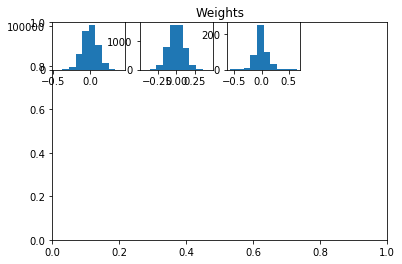

dW 0 Mean -0.146802149518 SD 0.947009173505
dW 1 Mean 0.14887022253 SD 11.6211682986
dW 2 Mean -5.49399735961e-05 SD 51.3527585662


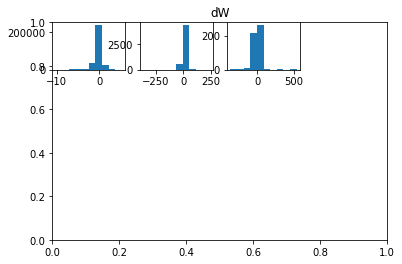

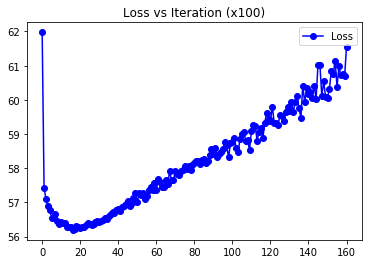

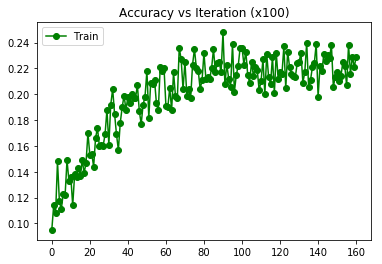

1601


1602


1603


1604


1605


1606


1607


1608


1609


1610


[4 7 0 1 5 4 6 7 1 0 5 7 6 3 0 4 0 6 7 1 3 4 7 7 0 7 7 4 0 5 3 7 1 0 5 0 1
 4 0 9 8 1 0 3 1 3 9 9 1 4 5 0 8 5 3 5 5 0 1 8 7 6 1 3 2 8 9 1 3 7 4 6 3 6
 9 5 9 1 8 0 2 3 2 7 6 1 1 2 0 5 5 3 0 3 6 7 1 1 8 9 0 1 7 2 6 4 7 7 0 8 0
 5 0 1 3 0 9 5 0 1 3 6 0 1 0 3 6 7 9 1 7 3 0 3 9 7 0 1 2 6 0 9 2 4 5 0 1 5
 0 9 3 1 5 0 1 7 3 4 1 7 4 5 9 0 0 2 9 1 6 2 6 5 4 1 6 6 4 6 1 5 0 9 0 0 0
 3 2 2 2 3 2 4 8 8 1 2 0 2 6 0 2 5 8 3 3 2 3 5 7 7 1 2 6 0 6 9 5 5 3 7 0 6
 9 1 4 0 2 2 0 2 0 7 6 6 9 5 1 6 2 3 2 7 4 0 0 6 0 3 0 3 1 1 0 0 7 6 6 1 5
 1 6 1 2 1 0 0 2 8 1 0 6 9 0 9 0 5 7 5 3 5 1 5 0 7 3 5 6 3 1 8 9 0 4 6 0 4
 6 1 7 0 9 5 5 3 0 2 4 8 2 7 1 6 6 1 5 3 5 9 8 9 9 2 0 9 1 0 3 1 9 3 5 8 4
 6 8 3 9 1 9 5 1 8 4 0 0 9 5 0 1 2 8 6 4 5 8 8 3 1 7 2 6 0 6 1 5 7 3 0 5 9
 5 6 3 5 2 3 0 1 5 0 6 1 6 4 8 8 2 3 8 9 7 7 9 8 4 7 7 4 3 5 3 6 5 6 3 6 0
 8 5 9 0 0 4 7 9 1 1 6 6 5 6 2 2 5 6 2 7 0 1 0 9 4 7 6 6 7 3 6 8 0 5 1 5 8
 7 3 5 2 0 3 6 5 5 1 3 7 2 0 4

1643


1644


1645


1646


1647


1648


1649


1650


[4 1 0 4 9 9 2 9 2 1 0 1 4 3 3 4 6 9 0 6 3 4 2 7 1 4 8 7 0 5 3 0 2 4 9 0 6
 8 0 0 8 0 0 0 3 3 2 5 0 2 1 0 8 2 0 0 6 0 1 8 5 5 2 2 9 5 5 1 3 0 9 2 8 6
 5 9 1 3 3 4 4 2 9 7 8 0 0 0 1 2 0 4 0 1 5 8 7 9 8 3 6 9 0 6 6 5 7 7 0 9 0
 5 0 1 3 0 2 7 3 9 6 1 2 1 2 8 0 0 3 6 0 4 9 3 3 3 0 1 5 6 9 8 4 9 6 0 3 9
 7 5 0 7 7 7 0 2 7 4 4 0 3 0 3 1 1 1 2 5 9 0 0 6 8 0 9 3 0 6 0 1 5 3 9 1 9
 9 2 8 5 5 9 5 3 7 9 8 5 2 2 1 4 5 3 4 3 6 3 1 8 2 3 2 0 0 4 9 8 2 0 4 3 5
 2 2 1 0 9 9 0 4 9 1 9 6 5 8 9 8 0 8 9 7 4 8 0 6 4 7 0 1 3 1 9 9 8 0 0 1 5
 5 9 4 6 0 0 9 5 2 8 2 9 1 5 9 2 9 0 0 4 7 0 0 1 7 0 5 8 8 0 9 9 0 4 5 5 5
 6 2 0 0 2 8 1 3 4 1 9 7 0 1 5 8 6 9 7 8 2 9 8 6 7 2 5 4 1 4 6 0 5 9 2 2 0
 3 6 3 1 6 1 0 1 9 1 0 1 6 8 4 3 7 0 1 4 0 5 7 3 0 8 6 4 0 6 6 5 0 2 0 7 8
 5 4 3 8 3 0 0 2 5 0 9 1 6 0 7 0 4 0 4 9 0 2 7 0 4 7 7 9 2 5 8 4 9 9 9 5 4
 0 0 6 0 5 5 0 1 0 2 9 1 6 6 4 4 9 1 9 9 2 7 8 8 5 7 2 6 5 3 3 0 3 6 2 2 9
 0 3 6 2 3 3 9 5 3 8 0 0 5 6 3 0 2 3 8 9 5 5

1683


1684


1685


1686


1687


1688


1689


1690


[1 2 0 0 0 4 8 7 0 1 4 7 3 8 3 0 7 1 3 1 1 4 7 1 4 4 5 8 0 0 2 9 2 4 8 0 6
 1 0 3 3 5 0 3 3 2 8 8 2 2 8 1 8 9 2 0 4 3 2 4 0 5 0 6 7 8 8 1 3 1 0 9 4 8
 5 6 9 0 3 0 1 8 9 5 6 0 0 4 7 5 0 4 5 5 9 8 6 4 7 9 0 1 7 0 5 8 5 2 3 2 0
 9 3 6 2 5 6 5 4 1 3 1 5 1 3 3 0 0 5 0 0 9 2 8 0 0 5 9 6 6 0 9 4 4 0 5 3 5
 3 9 6 1 1 7 1 5 1 0 1 8 4 4 5 9 6 2 5 5 9 8 0 7 1 1 3 0 1 6 5 8 7 3 8 9 0
 3 0 1 9 3 2 4 4 8 3 2 0 2 6 7 4 4 3 2 3 3 3 4 8 7 1 6 6 0 5 6 5 7 3 4 4 5
 7 1 4 0 0 6 0 4 0 0 6 5 0 8 1 1 2 1 2 3 0 2 0 2 4 7 0 3 3 6 0 2 1 5 1 8 2
 5 9 5 7 6 0 1 5 3 3 6 6 1 0 6 0 9 4 6 9 6 0 5 4 8 1 5 5 9 3 1 5 0 8 1 0 4
 9 2 1 5 9 4 5 0 9 1 0 7 1 2 6 1 1 9 8 3 2 4 5 9 0 2 5 0 8 0 3 2 5 3 7 2 0
 5 5 3 5 6 6 5 1 8 0 2 0 6 5 1 3 6 8 1 9 0 0 3 7 2 1 5 4 0 3 6 1 7 3 0 5 8
 6 9 3 4 8 3 9 2 9 5 4 1 8 0 9 4 0 0 4 5 2 9 9 3 0 1 1 9 0 2 8 6 9 6 1 5 0
 3 5 9 3 0 9 9 0 4 3 0 1 2 4 5 1 6 1 6 7 8 9 4 6 8 7 0 6 7 3 4 4 5 6 1 8 6
 0 9 9 2 3 3 1 9 3 1 3 7 6 7 5 5 0 1 2 2 5 5

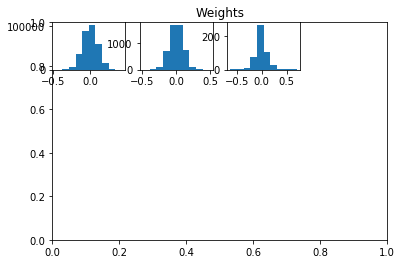

dW 0 Mean 0.0727818623382 SD 0.673274132905
dW 1 Mean 0.171570446227 SD 8.64058279802
dW 2 Mean -5.49376589701e-05 SD 53.4255471992


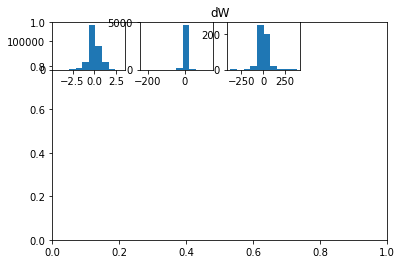

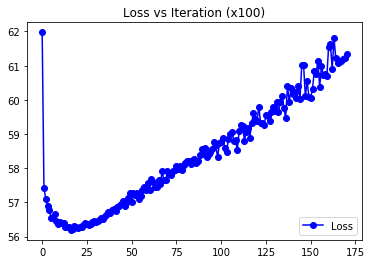

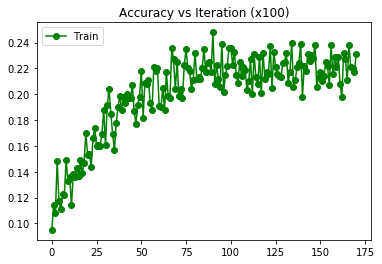

1701


1702


1703


1704


1705


1706


1707


1708


1709


1710


[0 1 3 4 1 1 8 8 9 2 6 7 9 6 0 2 0 3 0 6 3 3 6 5 3 0 9 4 0 0 3 9 1 0 5 0 1
 8 0 6 7 4 0 3 7 1 5 9 1 2 0 5 0 0 5 0 9 4 5 8 0 6 0 3 7 0 8 5 3 0 4 5 3 6
 0 6 9 5 0 0 0 6 9 6 9 5 4 4 0 2 0 0 4 3 9 7 8 4 7 9 7 1 7 6 6 4 7 7 9 9 2
 0 0 1 0 8 6 5 0 1 9 5 0 1 3 2 6 7 0 1 9 0 7 3 3 7 0 1 6 6 7 0 4 0 9 5 9 8
 3 0 0 9 7 7 1 0 0 9 6 8 9 4 1 9 2 2 2 2 9 0 0 6 1 1 5 0 1 6 0 3 0 3 8 0 3
 3 6 2 9 7 0 0 4 7 1 7 5 2 0 1 9 0 5 3 8 8 3 4 8 0 1 5 8 0 5 7 7 7 0 1 0 9
 2 2 4 0 1 9 0 4 5 0 6 7 9 5 5 4 6 1 9 0 0 1 6 0 4 0 0 0 9 2 4 0 1 4 2 1 6
 0 9 8 5 0 6 0 5 8 8 0 3 7 0 6 0 6 6 9 0 5 1 9 2 7 3 9 6 4 1 5 0 5 4 0 5 9
 9 1 8 5 2 4 4 2 1 3 9 8 0 6 8 0 5 1 2 3 8 5 7 9 1 5 0 4 0 8 8 8 5 3 8 2 4
 8 5 3 6 6 6 9 6 3 0 7 9 6 0 7 3 2 8 6 4 5 5 7 3 2 4 2 2 0 6 8 5 7 5 0 5 7
 9 0 2 7 1 0 0 2 9 0 9 1 9 9 2 0 6 3 0 9 0 0 7 7 0 0 6 5 3 6 3 6 5 9 9 9 8
 0 0 6 0 0 5 5 3 2 0 9 6 2 8 7 5 5 6 1 2 2 8 4 3 4 8 6 6 2 3 4 3 5 6 6 7 2
 0 5 6 2 6 3 1 9 1 9 8 0 2 9 3

1743


1744


1745


1746


1747


1748


1749


1750


[5 7 0 4 1 9 7 7 5 1 7 7 4 6 8 4 7 8 0 4 3 4 7 6 3 4 1 8 1 5 0 7 1 0 1 0 1
 8 9 0 7 0 0 3 1 2 2 8 2 8 8 0 0 0 7 7 9 3 6 0 8 5 0 7 7 8 4 7 9 0 9 9 4 6
 4 5 0 3 0 0 0 1 9 7 3 2 0 6 0 0 5 4 8 3 0 2 8 5 8 6 0 5 7 6 1 1 9 7 2 9 5
 0 0 5 6 6 9 5 0 6 3 6 0 1 0 3 6 8 3 0 7 0 8 6 9 7 0 1 6 0 7 9 5 4 9 6 3 0
 0 5 3 7 9 8 3 2 0 0 4 0 8 4 1 3 7 9 5 5 6 4 0 1 0 1 0 6 1 8 0 1 0 3 6 0 0
 3 2 5 6 5 4 1 4 0 7 6 0 0 6 9 2 4 5 3 9 7 3 0 3 8 8 0 8 0 6 6 4 7 4 1 7 7
 2 7 0 7 5 9 0 2 9 1 9 8 5 5 0 6 7 3 0 0 0 2 2 3 4 0 5 0 3 8 4 9 5 6 1 1 9
 1 5 5 5 7 0 0 0 9 3 0 1 1 0 3 9 4 5 3 6 4 9 8 0 2 0 5 6 3 2 1 4 4 8 5 0 4
 6 1 7 0 9 0 4 0 4 1 4 5 1 1 1 8 1 7 2 6 9 9 6 9 1 7 5 0 0 0 8 2 5 4 8 4 0
 0 6 1 6 6 5 5 1 8 0 7 0 2 6 3 0 9 0 5 5 0 5 7 3 0 0 6 1 0 6 3 5 0 3 5 0 4
 4 1 3 7 8 3 5 1 8 0 9 1 6 9 7 1 1 0 9 6 5 6 8 9 0 1 5 9 0 0 0 0 9 0 5 6 8
 0 8 6 8 5 8 7 6 4 1 0 5 5 9 4 2 5 8 3 7 7 6 0 5 9 7 0 6 5 3 0 6 3 6 4 5 6
 0 0 9 7 6 9 4 9 1 6 5 7 1 8 3 0 0 1 0 0 5 5

1783


1784


1785


1786


1787


1788


1789


1790


[5 1 2 1 8 4 2 7 5 2 7 3 2 8 0 5 7 3 0 5 3 6 2 5 3 4 9 8 6 0 0 4 3 4 9 0 2
 4 0 0 3 0 0 3 9 3 0 9 0 6 4 0 0 0 2 0 6 9 0 4 0 5 0 7 2 6 5 7 3 9 9 6 8 8
 1 6 9 5 3 0 4 1 1 7 2 5 9 0 8 4 0 3 2 1 3 7 6 9 9 3 0 0 3 5 1 4 7 0 2 0 0
 8 0 1 4 0 3 5 4 5 3 1 0 3 4 0 3 7 9 5 4 0 7 6 0 0 0 1 6 0 0 3 4 4 5 5 0 8
 8 0 1 9 3 7 4 0 0 0 4 2 4 4 0 0 1 1 2 5 3 3 4 9 4 1 3 1 4 4 2 5 8 3 8 9 4
 9 8 3 5 6 0 4 9 7 6 7 5 2 6 2 2 5 5 4 9 7 2 4 4 7 4 3 1 0 5 9 1 0 0 7 5 1
 2 1 1 9 8 9 0 4 5 7 9 0 5 8 0 8 2 1 2 0 4 1 2 2 4 4 4 3 3 7 6 0 4 0 6 1 0
 0 6 1 5 0 0 6 9 6 8 2 8 8 3 4 0 9 0 6 0 4 4 9 8 4 0 9 8 3 1 5 6 0 4 5 0 4
 9 0 7 0 0 4 1 2 4 6 9 7 0 4 9 1 5 1 2 3 5 1 9 9 0 5 5 0 2 0 8 2 5 4 5 4 0
 6 6 0 6 1 9 0 0 8 0 7 0 6 8 3 3 5 0 1 4 5 6 0 7 2 2 0 6 0 3 5 5 7 9 5 0 6
 5 0 0 7 1 4 0 6 4 0 9 1 6 0 7 4 1 4 0 6 7 2 7 4 3 1 0 9 0 0 0 8 9 0 3 9 9
 0 1 9 0 5 5 5 6 0 4 0 6 5 6 2 2 6 6 6 7 2 8 0 7 8 8 3 6 5 3 4 4 9 9 0 9 1
 0 3 9 0 1 0 9 4 1 6 3 2 9 6 3 9 2 1 4 4 0 9

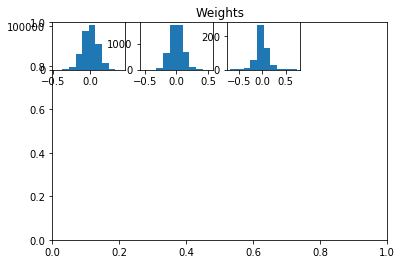

dW 0 Mean -0.166894378986 SD 1.2527996534
dW 1 Mean 0.0903288541701 SD 12.4441081096
dW 2 Mean -5.49380544387e-05 SD 59.4164541509


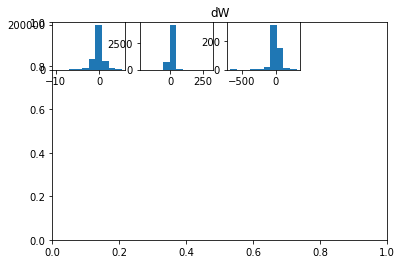

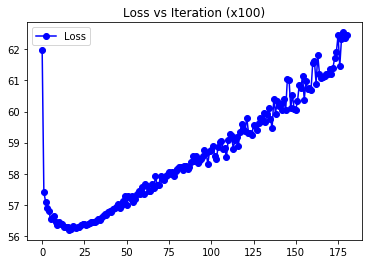

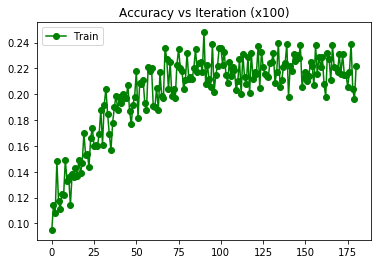

1801


1802


1803


1804


1805


1806


1807


1808


1809


1810


[2 8 7 0 5 4 8 9 2 0 9 0 6 3 0 4 7 9 6 5 9 9 7 7 0 0 1 0 0 5 0 9 1 4 7 7 2
 4 4 3 8 0 0 3 7 3 8 5 2 0 3 0 8 4 2 7 4 9 1 9 8 9 0 1 2 6 9 6 3 7 3 4 7 7
 1 5 0 5 0 0 0 6 9 8 1 9 2 0 0 8 0 1 8 5 7 8 5 5 1 9 4 1 1 9 3 1 7 7 0 4 0
 7 0 8 8 5 9 7 1 4 3 3 0 1 4 1 0 0 5 2 8 3 7 8 3 7 0 3 6 0 9 3 4 5 6 6 2 5
 7 6 2 7 8 7 2 4 4 0 0 3 4 0 1 0 2 8 2 2 9 4 9 6 8 0 9 1 1 6 5 1 1 3 9 0 4
 0 2 5 9 1 0 4 8 9 5 2 0 0 5 7 4 0 8 3 9 3 3 1 7 3 4 8 6 0 4 9 0 7 0 0 8 7
 2 7 4 0 6 6 4 0 6 0 6 0 0 5 0 4 0 0 2 7 0 3 2 2 4 7 5 3 3 6 1 1 9 9 6 1 0
 0 5 5 8 0 0 6 3 7 4 4 8 1 0 4 0 4 2 5 2 3 0 0 7 7 1 8 8 3 1 5 0 0 4 7 0 5
 9 2 0 4 7 4 1 9 9 7 9 8 3 1 9 5 5 1 5 3 1 6 6 5 0 8 5 0 0 1 8 4 5 0 7 7 0
 3 6 3 6 3 6 0 5 8 4 7 9 6 5 4 0 9 0 8 9 0 0 5 3 7 7 2 4 0 3 5 5 4 3 1 4 7
 6 1 0 7 3 3 9 4 5 0 6 5 9 6 9 4 4 9 4 6 7 9 9 9 4 7 6 6 0 9 8 4 5 6 6 9 8
 0 6 4 8 0 7 6 6 6 9 9 1 6 8 8 4 2 9 6 8 6 8 0 8 0 8 7 6 6 3 6 6 5 1 4 2 1
 1 9 9 7 1 3 6 4 3 8 3 7 8 7 3

1843


1844


1845


1846


1847


1848


1849


1850


[0 0 0 8 9 1 5 8 9 2 8 3 6 3 3 3 8 9 9 7 0 3 8 2 3 4 5 4 9 5 3 9 5 4 4 0 0
 1 4 3 7 0 0 3 5 0 2 4 1 0 5 0 0 5 3 0 8 0 0 0 8 8 0 6 7 8 5 5 3 2 0 5 0 5
 0 6 1 8 3 0 4 1 1 0 9 4 8 4 0 7 0 4 4 1 9 7 3 1 7 9 0 5 7 6 6 0 9 7 0 2 0
 8 3 6 3 0 9 7 4 1 9 5 0 3 0 3 0 8 3 2 7 9 5 1 9 8 0 1 6 6 9 9 4 8 6 6 3 5
 6 5 6 7 0 0 4 3 4 0 6 3 0 4 9 1 5 0 0 6 8 3 9 0 1 5 1 1 1 6 5 3 0 9 8 1 0
 3 2 0 6 3 0 4 3 0 2 2 1 0 0 7 0 4 3 3 1 9 4 4 3 7 1 0 3 0 4 9 3 0 3 0 2 2
 2 7 4 0 2 9 4 0 0 0 6 5 0 8 9 5 0 1 2 0 0 1 4 2 4 1 4 3 3 2 4 0 9 0 6 1 0
 5 5 0 7 7 0 5 2 2 8 2 6 8 1 4 6 9 7 6 6 9 9 2 2 7 9 5 8 3 0 9 5 4 4 0 6 6
 4 7 7 0 7 4 1 2 0 1 0 7 0 0 8 0 5 0 5 9 1 1 6 6 0 8 6 4 0 1 0 4 5 9 7 4 4
 3 9 3 1 5 1 9 5 3 0 7 0 3 4 0 0 9 0 6 9 4 0 7 3 7 0 2 2 0 6 8 9 4 3 6 7 7
 6 6 0 0 1 5 4 1 4 0 9 5 9 0 7 8 4 0 4 5 7 6 7 8 4 8 1 9 0 0 8 8 5 5 6 5 0
 0 0 9 0 0 9 7 9 1 0 9 3 6 0 7 5 7 2 9 5 6 5 8 7 9 5 7 9 5 3 8 4 9 5 0 9 3
 0 0 6 8 7 3 8 4 3 8 0 3 5 3 3 5 2 9 7 4 5 5

1883


1884


1885


1886


1887


1888


1889


1890


[1 5 7 0 1 4 2 2 0 6 6 9 9 3 3 0 2 9 0 1 3 6 2 7 1 4 1 2 0 0 5 0 0 4 1 5 1
 8 0 3 3 4 0 8 6 7 9 8 4 2 1 1 8 2 0 5 6 0 1 4 3 5 2 6 2 0 5 5 0 0 0 6 3 9
 1 6 9 1 3 6 4 1 1 9 1 4 5 4 8 2 9 3 4 5 0 2 0 0 7 3 0 5 1 1 5 5 3 2 2 9 8
 5 0 5 4 6 4 0 3 5 3 6 0 1 2 5 6 7 9 0 4 9 0 6 3 8 0 1 7 0 9 3 4 6 6 6 1 5
 4 5 6 1 7 7 4 0 0 0 6 8 4 4 2 0 2 2 5 1 9 6 0 5 4 0 5 6 4 6 0 3 0 3 8 1 0
 9 8 3 9 3 4 1 5 8 1 0 0 0 6 7 0 5 5 1 3 6 7 6 8 7 4 2 4 0 5 0 0 1 3 4 0 9
 9 1 1 0 6 9 0 4 3 1 0 4 0 8 5 4 2 3 0 0 5 3 3 2 4 4 0 3 3 7 1 2 8 9 5 6 7
 0 5 0 9 0 0 9 2 3 6 0 1 1 0 6 9 8 7 5 2 3 0 9 0 6 1 5 8 8 2 1 9 9 8 0 2 1
 9 1 7 0 7 7 4 1 0 5 4 4 0 2 1 0 1 1 9 3 2 4 0 6 5 2 0 9 1 4 6 5 5 0 7 4 0
 3 6 3 6 1 5 9 1 8 0 1 0 9 4 2 0 4 0 1 6 5 5 0 6 2 2 9 6 0 9 5 5 7 3 5 7 9
 4 8 7 9 1 3 4 4 5 0 6 1 2 0 7 1 3 4 8 5 2 2 3 2 3 1 6 8 0 0 8 8 5 5 6 9 0
 4 5 6 3 4 3 0 3 4 1 0 3 6 8 4 1 6 8 3 5 6 9 3 8 5 5 0 6 5 1 6 3 5 1 6 8 0
 0 0 5 7 5 9 9 4 5 7 8 7 1 8 9 0 1 1 3 6 5 9

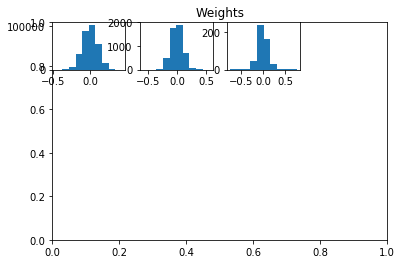

dW 0 Mean -0.171016752562 SD 0.809621047641
dW 1 Mean -0.0232549074391 SD 11.1689527793
dW 2 Mean -5.49433608621e-05 SD 70.9586213862


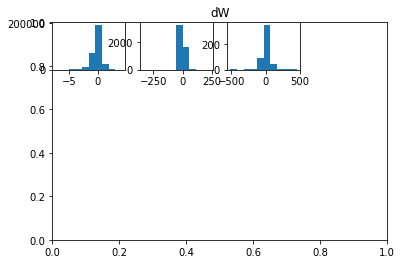

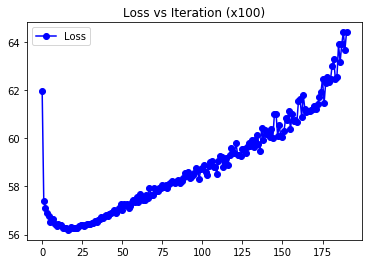

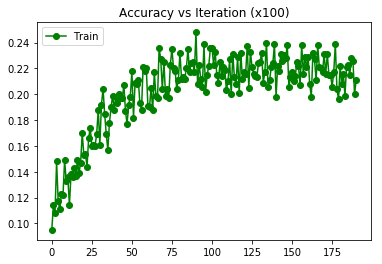

1901


1902


1903


1904


1905


1906


1907


1908


1909


1910


[6 7 4 8 5 4 8 9 0 2 7 8 2 7 3 0 7 9 0 9 0 6 7 7 3 0 7 2 2 5 0 0 0 0 8 0 5
 2 6 5 8 0 5 0 8 1 5 8 0 0 3 5 8 0 2 0 9 0 1 9 5 2 1 1 7 1 8 5 3 2 1 5 9 6
 5 3 5 4 0 0 0 6 7 8 3 4 0 0 0 7 0 0 8 2 6 2 6 1 7 9 3 4 7 9 1 4 7 7 0 2 0
 0 0 5 3 0 9 0 2 5 3 3 0 1 2 8 3 7 0 6 7 0 0 6 3 2 9 0 0 6 0 3 4 4 9 9 3 0
 3 9 6 7 7 0 4 5 0 4 4 2 3 4 1 5 1 9 5 5 5 3 9 5 8 0 6 1 0 6 1 1 0 3 8 4 0
 3 2 7 7 3 0 4 3 6 6 2 5 5 0 0 9 5 3 8 9 3 3 4 7 7 3 3 3 0 4 9 8 0 0 1 7 7
 2 5 4 0 8 6 0 4 6 5 6 8 0 5 0 4 0 3 0 3 3 3 0 7 4 0 4 0 3 8 0 1 4 0 5 1 7
 0 9 1 8 0 0 5 5 5 9 3 3 5 0 0 9 0 7 6 0 5 0 9 6 7 0 6 6 3 4 1 8 0 4 1 5 3
 3 0 7 1 9 1 3 3 0 1 0 5 0 2 9 0 5 1 5 3 8 1 0 9 9 8 0 0 0 8 6 4 9 4 2 4 0
 0 5 1 8 1 4 9 1 8 4 1 0 5 8 2 0 2 0 6 4 0 4 0 5 2 4 6 4 3 6 9 5 6 1 6 0 9
 0 0 7 4 1 9 4 2 4 0 4 5 9 9 7 0 6 4 6 5 7 0 3 4 3 9 2 0 0 6 8 6 9 6 9 8 1
 6 6 9 3 5 7 3 3 6 3 0 3 5 6 2 1 2 8 2 7 2 8 8 8 7 8 3 6 0 9 4 4 2 6 2 5 2
 0 9 9 6 2 0 4 4 1 8 1 7 5 6 3

1943


1944


1945


1946


1947


1948


1949


1950


[0 0 8 0 1 4 6 2 5 1 4 8 0 3 8 9 1 2 0 0 0 3 7 2 4 4 2 9 0 0 0 0 0 0 5 8 2
 4 9 9 8 0 5 3 8 2 2 4 0 6 1 0 8 5 3 0 4 4 0 4 7 2 7 1 7 9 8 0 0 0 3 6 3 8
 1 5 9 1 0 0 0 1 1 4 5 0 4 2 8 0 9 3 2 6 9 7 9 5 7 9 0 5 7 9 5 4 3 7 9 0 2
 8 3 6 6 0 9 5 3 1 3 6 0 3 3 1 8 9 0 0 9 0 8 3 0 3 5 3 0 0 0 3 2 0 9 6 3 0
 3 8 0 2 7 7 1 0 1 0 6 8 3 4 3 3 2 1 2 6 9 0 6 0 4 1 4 1 4 6 5 5 7 3 8 9 4
 3 6 3 6 1 0 1 3 7 3 1 0 2 6 7 9 4 8 3 7 3 2 0 2 3 1 0 8 0 5 0 1 1 0 6 7 7
 0 3 1 2 3 9 0 4 0 0 6 4 9 5 0 6 0 3 2 3 3 1 8 2 3 3 0 0 3 2 1 0 0 3 8 1 6
 5 8 0 2 0 0 9 3 7 3 6 3 9 1 0 9 0 8 5 3 0 0 1 2 7 9 5 8 3 0 4 4 0 4 0 0 3
 3 0 1 3 9 0 5 3 9 3 4 7 1 0 0 1 5 0 2 3 8 9 6 2 7 2 0 9 8 1 8 1 5 1 1 4 4
 0 5 3 8 6 0 5 5 1 4 2 9 0 8 7 6 9 0 1 4 0 6 7 0 4 4 6 6 0 6 0 5 0 0 2 0 9
 5 8 0 7 6 8 9 1 4 0 6 1 9 4 9 1 4 0 4 6 7 2 3 9 0 7 0 5 0 6 6 0 5 5 9 6 0
 3 8 6 0 0 5 7 6 1 9 4 6 3 5 4 1 6 2 2 7 6 0 8 0 9 0 1 6 9 6 4 0 4 6 4 9 6
 0 3 5 7 2 0 9 9 1 5 8 2 2 8 3 0 0 1 4 9 0 5

1983


1984


1985


1986


1987


1988


1989


1990


[0 2 1 0 5 4 8 2 3 1 6 8 0 2 8 3 0 9 6 3 1 6 2 0 3 4 1 2 0 5 0 0 1 4 1 5 2
 4 0 3 8 0 3 0 6 1 2 8 0 6 8 0 8 0 3 0 9 0 0 3 3 9 0 0 7 8 9 0 3 2 9 5 7 5
 4 9 0 4 6 0 4 5 9 0 9 4 0 2 8 1 1 5 8 1 0 7 9 9 0 9 0 5 5 7 5 0 7 7 9 2 7
 7 0 5 3 8 9 5 3 4 9 3 5 3 2 1 3 7 5 0 7 0 8 6 0 8 0 0 0 0 0 3 5 9 7 0 3 5
 5 9 6 2 8 7 1 4 0 9 0 9 4 4 1 3 0 7 5 1 8 0 0 1 0 4 3 1 1 6 1 8 2 3 8 0 0
 0 8 0 2 3 0 4 5 8 7 6 0 5 8 1 0 4 3 7 5 3 3 0 3 7 3 0 5 0 0 6 5 0 0 5 2 2
 6 1 1 0 6 7 0 0 0 5 9 7 5 0 5 8 6 3 0 7 0 2 0 3 8 0 4 3 9 2 9 9 5 5 0 6 5
 6 6 0 8 6 0 5 4 2 0 5 6 9 0 4 0 9 7 5 6 5 0 9 1 8 1 7 6 3 2 9 9 9 4 0 5 5
 0 0 7 0 2 0 0 2 5 7 9 5 3 0 5 1 9 0 8 8 1 5 6 9 1 8 4 0 2 1 8 0 5 0 7 3 4
 6 8 1 0 1 1 5 1 3 0 4 0 5 5 0 0 9 8 5 4 0 0 7 3 2 0 1 6 0 0 9 0 4 3 6 0 9
 6 6 0 2 4 8 0 4 4 0 6 1 9 9 8 4 4 0 6 6 0 0 5 0 4 0 5 5 0 6 9 6 9 6 6 5 8
 0 0 9 0 0 7 7 6 2 1 2 1 5 6 7 4 7 9 1 5 6 1 4 7 4 6 7 6 2 9 8 6 3 1 2 5 0
 0 0 0 7 1 3 1 4 3 7 3 0 2 7 0 0 2 3 4 0 0 5

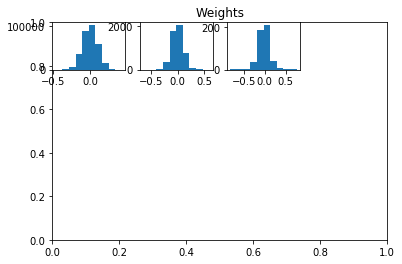

dW 0 Mean -0.228110130297 SD 0.800884278797
dW 1 Mean -0.162256349036 SD 12.7028460704
dW 2 Mean -5.49456573567e-05 SD 82.479939586


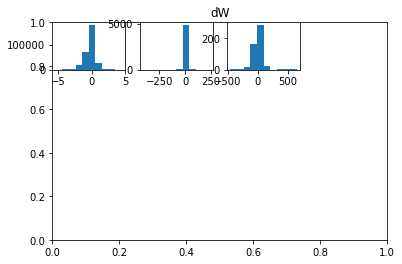

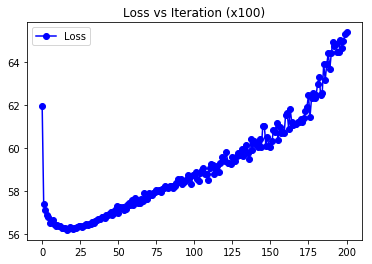

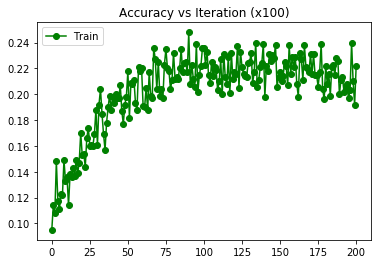

2001


2002


2003


2004


2005


2006


2007


2008


2009


2010


[8 2 3 0 5 9 1 2 2 0 2 2 4 8 6 3 2 8 0 1 0 4 2 5 3 4 1 2 9 0 0 0 0 4 1 0 2
 1 6 0 0 4 0 0 1 2 2 5 0 4 1 0 0 6 0 5 4 3 0 4 3 5 0 1 7 0 5 2 0 6 3 9 4 8
 0 7 9 0 0 0 1 6 2 4 6 4 0 0 8 1 0 5 4 1 7 2 4 5 8 9 0 3 0 2 1 0 4 0 2 2 7
 7 3 1 9 0 5 4 3 5 3 6 5 0 0 5 0 7 9 6 5 1 4 6 9 7 0 1 0 6 0 3 4 4 1 6 3 0
 3 8 8 5 2 7 4 3 0 4 4 9 3 4 3 0 2 2 5 1 5 4 4 5 8 1 5 6 4 6 5 3 2 3 8 4 0
 0 8 5 9 1 4 1 5 7 6 2 0 0 6 9 2 1 5 4 3 6 1 0 2 7 1 9 6 3 4 9 0 7 0 0 8 1
 9 5 4 0 9 2 0 0 0 0 6 6 5 0 5 6 2 1 8 7 0 1 8 2 4 0 4 0 0 2 4 1 9 0 1 6 6
 5 9 3 4 0 0 0 0 2 3 0 6 8 4 4 7 4 2 6 6 0 4 9 2 4 5 1 6 4 1 9 9 0 8 0 0 5
 3 2 7 0 6 4 1 0 4 1 9 0 5 0 1 5 0 2 5 3 1 5 9 9 0 8 5 9 1 1 3 4 9 0 8 9 0
 0 8 9 6 4 5 9 6 3 4 4 9 0 0 1 0 4 0 1 4 4 5 2 3 0 0 9 4 0 6 0 5 0 3 5 5 7
 2 0 3 7 4 6 9 1 4 4 9 5 3 8 9 8 1 0 9 4 7 2 5 0 0 5 2 6 0 0 0 0 5 5 6 5 4
 3 0 9 9 0 3 3 3 4 1 8 0 5 6 2 1 3 8 3 4 6 2 4 8 4 0 1 5 0 3 4 5 9 0 2 1 6
 0 0 5 2 1 3 1 4 1 8 3 2 2 5 0

2043


2044


2045


2046


2047


2048


2049


2050


[8 1 2 4 1 4 6 2 9 1 0 7 0 6 3 3 0 6 0 7 3 9 1 5 0 4 7 4 2 0 3 0 0 0 6 0 5
 4 0 3 0 0 0 1 5 1 9 4 1 6 3 0 0 5 0 5 9 9 0 1 0 5 0 7 7 0 8 1 3 0 3 9 0 6
 9 9 1 0 3 3 4 0 9 4 6 9 0 2 0 2 0 3 0 7 2 8 7 0 1 3 7 5 8 6 3 4 9 0 3 8 7
 8 3 6 3 0 9 6 4 5 9 1 0 1 3 5 0 7 1 0 4 0 0 1 0 7 5 1 8 0 3 3 4 4 6 0 3 0
 6 8 0 9 8 5 1 0 3 0 4 7 4 4 1 0 0 0 5 1 5 4 0 0 4 1 3 1 4 6 5 3 6 5 8 0 0
 3 8 5 6 3 0 4 5 9 8 6 0 0 0 0 3 5 8 1 7 2 9 0 2 3 8 0 5 3 0 7 1 7 0 4 8 5
 0 1 1 0 8 6 0 4 0 5 9 5 0 5 0 4 1 8 2 0 0 2 8 2 6 0 0 0 3 7 0 9 5 5 6 1 5
 5 5 1 8 0 6 0 0 6 0 3 6 7 5 9 0 4 7 5 0 6 0 8 7 1 1 6 8 3 4 1 9 9 0 0 0 1
 3 2 5 0 6 0 3 0 9 6 4 0 3 0 1 5 9 0 8 3 1 9 0 9 4 2 5 0 0 1 3 0 5 1 0 9 0
 0 9 3 1 1 6 0 8 6 0 2 0 0 0 2 9 7 6 1 4 4 5 0 3 0 8 5 4 0 6 5 4 0 9 6 0 7
 5 1 2 5 4 9 0 2 5 5 9 5 9 9 7 0 3 0 8 9 5 2 6 8 7 1 6 9 0 6 3 6 9 6 6 6 0
 6 6 0 0 0 9 6 3 1 1 8 1 9 9 5 1 7 5 1 5 0 1 8 8 9 5 3 5 8 3 4 6 0 1 4 5 2
 0 0 5 7 1 8 9 9 1 8 0 2 1 3 3 0 9 1 4 0 5 5

2083


2084


2085


2086


2087


2088


2089


2090


[5 6 2 0 9 5 2 9 9 1 2 9 4 3 3 9 8 1 0 5 0 6 2 2 3 9 6 0 2 5 0 9 0 0 8 0 6
 4 4 3 8 4 0 3 9 0 2 4 0 4 5 5 8 0 0 7 6 0 0 6 6 2 0 1 2 6 9 2 3 3 1 6 4 6
 9 0 0 8 3 0 0 6 0 0 1 0 2 0 0 2 0 4 2 2 0 2 5 0 0 9 4 5 1 9 3 5 7 2 3 2 0
 2 0 5 3 3 6 0 3 1 1 0 0 1 3 2 0 8 4 0 2 0 8 6 0 2 9 3 0 6 0 9 2 9 6 0 3 5
 4 0 3 2 2 7 3 0 0 0 0 0 4 0 0 6 0 8 5 5 9 4 5 0 5 1 8 1 1 6 0 1 2 3 2 5 0
 3 8 0 6 3 0 4 5 5 5 2 0 0 0 7 3 0 5 5 2 5 2 0 0 7 3 3 0 0 0 0 0 2 0 2 8 2
 0 4 1 0 5 2 0 4 9 0 6 5 5 5 5 4 2 1 2 0 0 2 8 1 4 3 0 0 9 2 1 9 9 0 6 6 0
 0 5 1 8 9 0 1 0 1 5 0 2 8 0 3 0 5 2 2 0 9 0 5 9 1 0 5 6 0 2 1 5 0 4 0 5 4
 3 1 7 0 9 5 0 9 1 6 4 2 0 5 9 1 9 1 5 3 2 1 5 9 8 2 1 8 0 3 0 4 5 3 4 9 0
 0 3 3 5 1 2 0 1 3 4 0 0 3 0 1 0 2 0 3 2 0 0 3 3 8 0 0 6 0 0 0 5 0 0 0 0 9
 6 4 0 5 4 8 0 1 5 1 6 1 3 0 9 0 4 4 6 9 2 9 6 9 8 9 1 5 0 0 3 6 5 5 9 6 8
 0 6 6 0 0 5 0 6 1 3 1 3 8 9 2 8 2 1 2 5 2 9 9 5 9 5 3 5 6 3 6 5 3 0 2 5 9
 0 5 9 8 1 0 9 4 3 8 0 9 9 5 0 4 9 1 4 1 0 9

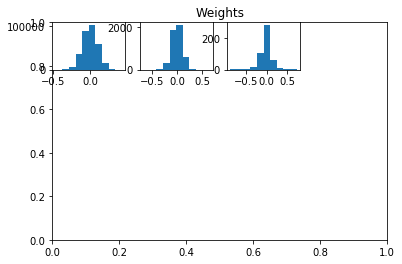

dW 0 Mean -0.34479221132 SD 1.09843390255
dW 1 Mean -0.866028488369 SD 17.7618648047
dW 2 Mean -5.49494376792e-05 SD 124.784607911


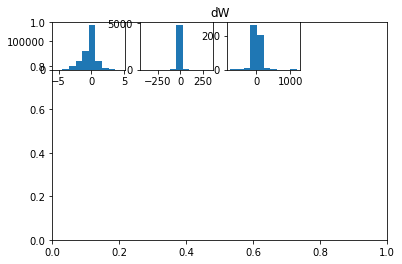

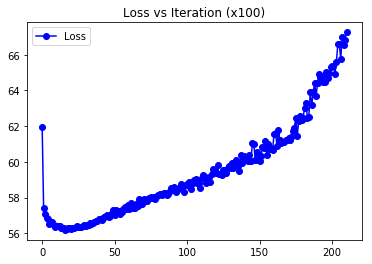

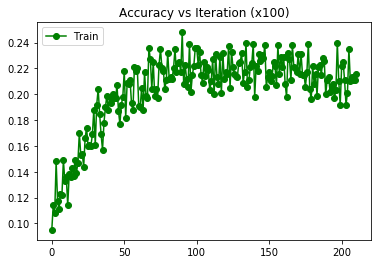

2101


2102


2103


2104


2105


2106


2107


2108


2109


2110


[0 6 7 5 5 5 5 7 5 2 0 7 0 7 0 9 7 4 0 0 0 6 0 0 0 0 6 4 0 5 9 0 5 4 0 0 1
 1 6 0 3 0 0 0 1 0 5 5 0 6 0 0 0 2 3 0 4 0 0 9 0 6 0 7 9 3 5 1 0 1 0 5 0 8
 0 9 9 3 0 0 0 6 3 4 6 3 6 0 8 1 3 3 6 7 1 0 5 5 0 5 0 5 8 1 0 5 7 8 0 9 7
 8 3 5 0 3 3 6 4 8 9 0 0 1 0 5 0 7 1 0 7 0 5 6 9 7 0 4 0 0 1 9 4 0 0 0 3 9
 0 7 3 1 7 7 4 0 0 0 0 0 0 4 1 0 2 8 0 8 5 8 9 6 5 1 3 5 4 8 0 1 6 3 8 9 0
 0 6 3 5 1 0 1 5 6 7 2 5 0 6 1 3 5 8 8 9 5 0 0 7 7 4 7 5 0 5 0 4 7 0 6 8 5
 9 5 1 0 3 7 4 0 0 0 9 0 0 8 0 1 9 3 0 7 0 6 0 2 4 1 0 0 9 2 1 1 4 4 0 1 5
 8 6 3 5 0 6 0 7 7 8 6 9 1 0 0 0 9 1 5 0 9 0 6 8 1 0 0 5 3 8 5 6 0 4 4 0 8
 9 7 7 5 6 0 1 0 0 1 9 8 5 0 6 6 1 4 9 8 1 1 5 0 7 7 0 0 0 8 0 1 5 0 0 4 0
 0 8 1 8 3 1 0 1 9 0 0 9 5 0 4 0 9 0 1 4 5 4 7 1 0 8 2 4 0 0 9 5 7 9 6 0 7
 9 6 7 4 1 3 9 4 5 0 0 5 1 9 6 4 0 0 4 6 2 0 7 0 0 0 5 9 0 6 0 0 9 5 5 6 9
 4 5 8 0 1 7 0 9 5 1 6 0 6 6 5 4 6 8 6 9 0 0 0 3 4 8 0 5 0 1 6 1 3 0 7 8 0
 0 3 0 6 0 0 9 4 3 8 8 7 9 8 0

2143


2144


2145


2146


2147


2148


2149


2150


[2 1 0 0 5 1 8 7 2 0 6 7 0 8 0 0 7 9 0 8 0 9 0 2 4 9 2 0 0 5 3 9 1 9 1 0 0
 4 0 0 8 5 0 8 2 1 7 8 0 1 1 5 8 2 0 8 2 0 0 2 9 9 0 2 7 3 6 7 3 9 3 2 9 5
 0 7 1 4 0 4 4 1 9 0 2 9 0 0 8 2 0 5 9 9 0 7 8 0 8 9 2 5 7 2 0 8 9 0 2 2 0
 7 0 5 0 0 9 0 1 6 9 4 5 3 3 2 0 8 0 0 8 0 2 1 0 8 5 0 2 0 0 3 6 4 0 0 3 2
 0 5 6 5 8 5 3 0 1 0 4 0 8 0 0 0 1 2 5 5 9 8 9 5 4 0 5 0 1 8 0 1 2 4 8 0 0
 3 8 7 2 5 0 0 0 2 8 9 5 2 0 0 9 4 5 8 2 2 1 4 2 8 3 6 0 0 0 0 0 8 0 1 0 6
 0 9 1 0 5 7 0 4 0 0 9 2 9 5 5 4 2 8 7 4 0 2 2 1 8 4 0 0 3 1 1 9 8 0 1 8 6
 1 2 5 8 0 6 9 5 2 8 0 9 2 1 4 5 4 2 9 0 4 0 9 1 8 1 3 8 3 4 5 6 0 4 0 0 5
 0 1 7 0 8 0 1 2 1 1 2 9 2 0 2 5 7 1 5 3 1 6 0 2 1 7 5 0 1 2 8 4 2 0 2 5 5
 0 2 8 0 3 1 0 1 3 4 1 9 5 5 8 0 9 0 1 0 0 2 2 3 7 8 0 4 0 2 0 5 0 9 6 0 9
 2 2 5 0 1 3 9 0 9 2 2 1 4 0 9 4 1 0 9 6 2 9 5 9 5 0 2 4 4 0 3 0 5 5 9 6 0
 2 6 0 8 5 7 0 6 0 8 2 8 6 0 7 4 9 2 1 2 2 2 8 3 9 8 2 5 6 9 0 0 9 1 2 0 9
 0 0 5 7 2 9 2 8 5 6 3 9 9 6 0 4 0 1 0 0 0 5

2183


2184


2185


2186


2187


2188


2189


2190


[0 6 0 8 5 4 7 7 0 4 6 7 0 3 0 0 7 3 9 1 0 3 0 0 4 9 6 0 0 6 0 0 0 4 7 0 0
 4 0 3 8 4 5 8 9 1 7 3 0 0 5 0 0 0 0 0 7 3 0 9 0 0 0 6 7 3 8 7 0 1 1 6 0 7
 5 6 9 1 0 0 4 6 9 0 9 3 1 4 8 5 0 3 4 7 0 1 9 5 7 3 0 5 3 6 3 4 7 7 9 9 5
 0 3 5 0 0 0 7 4 5 3 0 0 3 3 8 8 9 0 0 8 0 8 3 0 3 0 4 7 0 3 9 4 4 0 5 1 5
 4 5 0 1 8 7 4 5 0 0 1 3 3 0 2 1 1 8 5 6 9 8 9 1 5 0 5 0 4 8 8 3 6 3 0 0 0
 0 6 3 6 7 0 5 0 7 7 7 0 5 3 1 4 5 0 3 8 8 1 4 7 3 0 0 4 0 0 6 1 7 0 4 7 1
 9 1 8 9 1 5 0 0 0 0 9 5 0 5 0 4 0 6 0 0 0 1 9 2 4 0 0 0 1 8 1 9 7 1 5 1 7
 5 6 1 8 0 0 0 7 7 8 0 7 7 5 9 0 0 0 5 0 6 0 8 7 1 1 0 8 3 8 9 5 0 4 0 5 5
 3 2 6 5 6 4 0 7 5 3 9 0 0 5 1 5 1 0 5 3 1 9 0 0 4 8 5 9 0 0 0 4 3 1 1 4 0
 0 9 1 8 1 1 0 6 3 0 0 7 0 0 8 0 5 0 5 8 5 0 0 1 0 4 4 1 0 6 8 1 7 5 6 0 8
 9 2 7 4 4 0 0 4 3 1 0 1 9 8 6 4 4 0 4 9 7 0 9 3 4 8 7 5 0 5 0 4 0 4 1 8 4
 4 5 0 8 0 9 0 0 8 0 4 8 8 6 4 3 7 8 3 7 0 0 3 8 4 5 0 5 7 3 8 4 3 3 0 5 0
 0 3 0 5 3 6 3 7 3 7 8 4 9 9 9 9 5 1 4 0 5 5

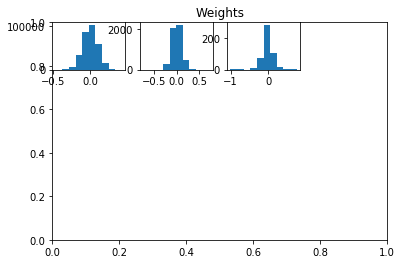

dW 0 Mean -0.409230145746 SD 2.79557038048
dW 1 Mean 0.90939768787 SD 71.2680268365
dW 2 Mean -5.49571077845e-05 SD 346.225745067


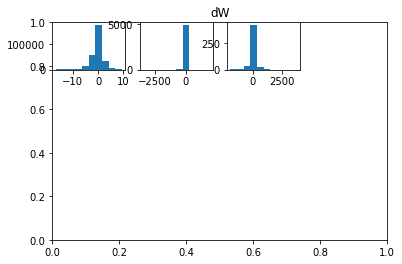

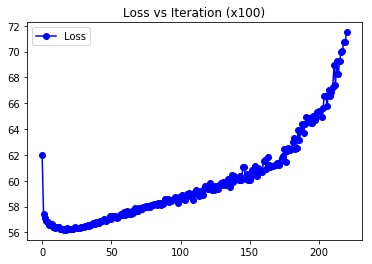

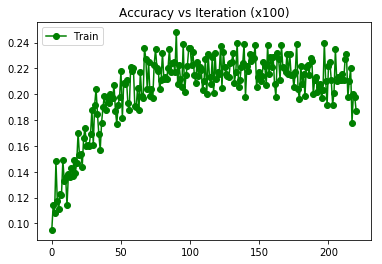

2201


2202


2203


2204


2205


2206


2207


2208


2209


2210


[0 9 1 5 8 4 7 1 5 0 0 0 0 0 3 9 7 8 0 0 3 9 1 0 3 4 3 9 9 5 0 0 0 4 5 0 6
 4 0 1 8 0 0 8 9 5 0 3 0 8 5 0 8 0 0 0 4 0 0 9 0 3 0 7 7 8 5 6 0 0 9 9 3 6
 0 9 1 7 3 3 4 1 9 8 3 3 2 4 0 8 0 0 4 7 0 7 4 0 1 9 0 5 7 6 1 1 3 7 2 3 5
 5 3 5 9 3 0 7 1 9 3 3 0 0 0 1 8 7 0 0 3 0 0 3 3 8 9 3 7 0 3 3 0 4 3 0 1 5
 4 7 0 9 7 7 3 0 0 0 6 3 3 0 1 1 2 8 5 6 9 0 0 0 0 0 3 9 1 6 0 9 6 3 8 0 4
 0 3 3 7 0 4 4 3 0 7 2 0 5 0 7 4 4 3 1 3 3 8 5 4 7 8 0 5 0 3 0 4 7 0 0 0 1
 0 9 1 5 9 3 4 0 0 0 6 4 5 5 0 4 3 3 0 0 0 3 3 9 4 3 0 3 3 6 1 0 4 0 1 8 5
 5 5 0 8 0 0 0 0 7 3 0 3 6 0 0 0 0 2 5 5 6 0 9 2 7 9 9 0 9 0 5 4 9 4 0 0 4
 9 0 1 0 7 0 1 0 4 3 9 4 0 0 3 8 6 0 0 3 1 9 9 6 8 8 0 0 0 0 0 4 5 3 7 0 0
 3 5 3 3 3 1 5 1 6 0 0 0 7 0 0 0 9 0 3 6 0 3 9 0 7 8 9 4 0 3 3 5 7 9 6 3 7
 5 3 0 3 4 3 9 8 4 0 6 3 4 8 7 4 3 4 4 5 2 2 7 9 9 9 5 9 0 0 3 0 5 0 6 8 9
 3 5 7 3 0 9 5 3 4 0 9 0 3 0 7 8 7 8 3 9 6 6 3 8 7 6 3 5 7 3 3 0 0 1 0 5 3
 0 9 3 0 7 3 0 9 1 9 8 7 8 0 3

2243


2244


2245


2246


2247


2248


2249


2250


[0 0 7 0 5 4 8 8 5 2 7 7 0 4 3 0 0 4 0 0 4 9 7 7 0 0 1 8 0 0 0 0 0 0 2 0 7
 4 0 0 7 5 0 3 4 1 7 8 0 8 0 0 8 0 0 8 4 3 0 9 1 5 0 7 7 1 4 2 0 0 4 5 7 7
 0 5 0 1 0 0 4 7 0 7 2 3 8 0 8 1 0 3 4 1 9 7 4 5 1 9 0 1 7 7 0 4 2 7 0 8 0
 8 8 1 4 0 0 7 1 1 9 0 0 1 0 1 0 8 0 1 7 0 7 6 0 8 0 2 0 0 0 3 0 7 6 0 1 5
 3 0 0 5 7 7 4 0 0 0 4 0 0 0 1 0 2 2 0 1 5 8 9 5 5 4 0 1 1 4 5 3 1 3 7 0 0
 0 2 0 2 3 0 1 1 7 7 7 5 4 0 0 4 4 5 4 7 7 0 4 7 7 4 7 4 0 4 5 0 7 0 0 9 7
 0 8 4 5 5 4 0 0 0 0 0 5 0 4 0 1 2 0 0 7 0 7 8 2 4 3 0 0 1 7 1 9 1 0 8 5 5
 5 5 0 8 0 6 0 5 7 5 0 7 1 0 4 5 5 7 5 0 0 9 8 7 7 0 5 5 0 0 1 4 0 7 0 5 4
 4 0 7 0 7 4 3 1 7 1 4 5 0 5 8 5 5 1 7 4 1 1 7 2 0 0 0 0 0 0 4 4 5 0 7 4 0
 0 8 2 4 4 0 0 5 4 0 0 9 7 0 4 0 9 0 5 9 0 0 8 1 7 7 4 6 0 2 0 5 4 0 0 0 7
 5 1 2 7 4 3 0 1 4 0 0 5 9 0 7 4 0 4 7 0 2 9 7 4 7 1 7 4 0 0 0 0 9 6 9 8 1
 4 5 9 0 4 5 5 6 2 5 8 6 4 6 7 8 9 6 1 7 6 1 0 8 4 8 9 5 7 1 6 7 4 5 7 8 0
 0 0 8 7 7 0 1 7 4 8 5 7 2 8 3 0 5 7 1 0 5 9

2283


2284


2285


2286


2287


2288


2289


2290


[2 5 0 4 0 5 6 4 0 4 6 2 4 8 6 0 6 0 6 1 0 9 1 5 4 0 1 4 0 8 0 0 0 0 5 0 6
 4 0 1 8 0 0 0 8 2 8 5 0 4 1 0 5 2 0 0 8 0 0 2 9 9 0 2 8 5 5 5 0 1 0 5 1 5
 0 0 0 1 0 0 8 1 0 8 1 5 2 0 5 5 9 4 5 5 6 6 4 5 1 8 5 5 1 8 0 4 4 7 0 4 2
 0 3 5 8 0 2 6 8 5 9 5 0 1 0 5 0 8 3 5 1 9 8 8 0 8 9 3 5 0 0 0 4 5 0 0 1 8
 5 5 0 5 2 2 1 0 3 0 4 9 4 0 1 0 1 9 8 5 5 0 9 5 5 0 0 1 1 6 5 1 0 3 8 0 0
 0 8 1 5 5 0 1 5 0 8 8 0 5 6 0 4 0 5 1 9 1 0 6 4 8 4 0 5 0 0 9 0 1 0 5 5 1
 0 4 1 0 5 9 0 0 0 0 0 5 5 5 0 8 2 8 9 7 0 1 2 1 4 0 0 0 3 1 1 9 1 1 5 1 6
 0 0 1 6 6 0 0 2 2 5 0 1 6 0 9 0 0 6 9 9 6 0 8 2 6 1 5 5 4 0 5 0 6 4 0 0 9
 0 0 6 1 2 0 4 0 8 5 9 5 0 0 1 1 1 0 5 6 1 4 9 5 1 2 5 0 1 1 0 1 5 1 2 9 0
 0 9 1 5 1 0 5 1 6 1 0 0 9 5 4 0 5 8 1 0 0 0 5 6 6 1 0 0 0 0 5 0 2 0 0 0 0
 6 2 0 8 1 4 0 4 5 1 0 1 9 8 8 4 0 0 6 9 4 9 7 0 9 4 2 5 0 5 0 0 9 0 5 0 1
 6 1 9 0 0 5 0 1 1 5 2 8 8 9 4 8 2 5 1 5 0 0 0 5 5 8 5 5 5 0 8 5 0 5 1 5 9
 0 0 5 8 1 9 4 9 1 6 8 0 2 5 0 4 5 0 1 0 5 0

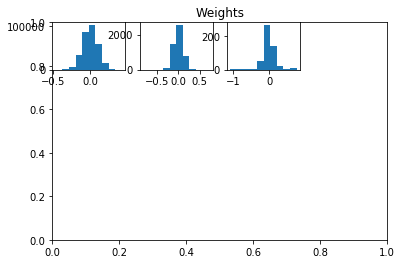

dW 0 Mean 1.08604905949 SD 3.69345797905
dW 1 Mean -1.60179964957 SD 81.3202299518
dW 2 Mean -5.49672503676e-05 SD 515.880932569


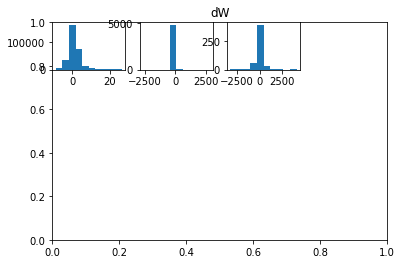

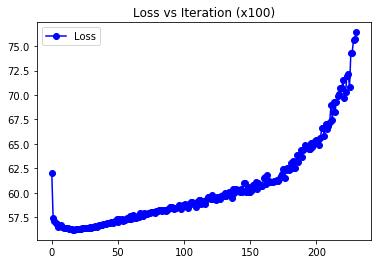

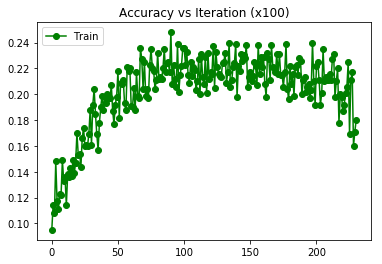

2301


2302


2303


2304


2305


2306


2307


2308


2309


2310


[4 1 4 1 1 1 9 7 4 7 6 7 1 6 1 0 5 0 0 4 0 9 7 5 0 4 5 9 7 0 0 0 0 4 6 0 6
 4 0 0 0 4 0 0 1 1 7 9 0 0 1 0 0 0 0 6 6 0 0 4 7 9 0 7 7 6 6 7 0 2 0 9 1 9
 0 9 9 1 0 0 4 0 0 0 6 3 1 4 8 6 8 4 0 4 9 7 6 9 9 9 5 9 7 6 3 4 9 7 0 6 0
 6 4 6 8 0 0 1 4 4 9 1 5 5 0 8 9 9 0 0 6 0 4 6 9 8 0 0 8 0 0 9 4 4 9 0 3 0
 4 9 0 5 7 9 0 0 6 4 1 3 0 0 0 0 0 9 8 8 9 4 0 6 0 0 4 3 4 6 5 0 7 0 8 5 0
 0 8 8 9 3 0 1 0 0 6 0 5 5 0 0 0 0 8 4 7 4 1 4 6 8 1 6 4 0 9 0 0 8 0 6 4 5
 0 9 4 0 8 7 0 0 9 4 9 5 9 8 0 1 6 8 9 0 0 6 7 3 4 0 4 9 1 8 3 0 9 1 6 6 0
 8 6 0 4 0 0 0 0 5 4 3 6 9 0 9 5 0 8 6 5 4 0 6 4 4 1 8 8 4 4 9 5 0 4 0 5 8
 0 0 7 5 6 5 0 6 1 7 4 9 0 1 1 5 0 4 0 4 1 4 6 6 8 9 0 0 1 0 0 4 3 0 6 9 4
 0 4 0 1 6 9 9 5 1 0 4 9 6 0 4 0 6 0 1 4 0 4 7 0 0 8 4 4 0 6 0 5 0 8 6 9 4
 9 6 0 9 4 8 0 1 4 0 9 1 9 8 7 0 0 0 4 9 4 0 6 0 0 1 6 6 0 0 6 0 5 6 1 9 4
 4 8 9 0 0 9 5 6 8 4 9 8 5 9 1 1 5 1 6 9 6 6 0 0 9 4 6 0 9 3 4 1 0 6 1 5 3
 0 0 4 8 6 8 4 4 5 8 0 4 1 6 0

2343


2344


2345


2346


2347


2348


2349


2350


[5 7 7 4 1 1 6 7 0 1 6 7 0 7 3 3 7 9 0 0 1 3 7 7 0 4 1 7 0 6 3 5 1 0 7 7 6
 6 0 9 3 0 0 8 7 1 3 3 0 6 1 0 0 0 0 0 5 0 0 0 8 9 0 0 8 3 7 0 0 3 0 8 7 8
 4 6 1 0 3 0 4 6 7 7 7 3 4 0 7 7 0 3 7 7 9 7 9 5 7 0 0 5 7 0 0 1 3 7 0 0 0
 0 0 5 0 8 0 0 3 1 3 5 0 0 0 3 5 7 1 0 7 0 7 3 0 8 0 3 8 0 0 0 6 1 6 0 1 0
 3 6 3 5 8 0 4 4 0 0 1 9 9 0 0 6 0 8 9 5 5 3 5 5 7 0 3 1 4 7 0 1 9 3 7 4 0
 0 6 3 7 3 0 0 1 8 0 6 9 0 0 0 9 0 0 1 9 7 1 0 7 8 1 9 5 0 0 0 9 1 0 6 7 7
 0 7 3 0 8 7 0 0 0 5 6 5 0 5 1 1 0 1 0 0 0 1 7 7 3 0 0 0 9 8 1 9 0 1 8 1 5
 1 0 0 7 0 0 0 9 7 1 0 7 7 0 0 0 0 7 6 0 6 4 5 7 7 0 8 3 3 0 5 5 9 6 0 0 5
 0 0 7 0 6 0 0 7 7 7 9 4 0 0 7 1 1 1 0 3 1 5 0 6 0 7 5 0 0 0 0 6 9 1 0 7 0
 3 9 3 3 6 7 0 1 3 0 4 7 6 8 7 0 1 0 5 7 0 5 7 7 0 8 1 0 0 6 0 0 0 0 5 0 7
 9 6 7 7 3 6 0 6 3 7 9 6 9 8 9 4 3 0 0 0 7 0 9 0 6 5 7 0 0 0 9 0 0 6 5 6 9
 6 5 0 0 0 7 7 6 6 0 7 6 3 0 1 7 7 8 3 3 0 0 5 3 7 8 9 5 0 6 3 0 9 6 7 5 1
 0 0 5 7 7 0 4 7 3 7 8 9 7 6 3 0 9 3 7 5 0 5

2382


2383


2384


2385


2386


2387


2388


2389


2390


[0 1 0 0 3 1 6 2 0 0 6 2 3 6 3 0 2 2 3 4 3 3 2 6 3 9 2 8 0 0 0 0 0 9 0 3 3
 2 3 3 0 4 1 1 2 1 8 8 0 0 3 0 8 3 0 0 2 4 0 8 1 3 0 2 2 3 6 6 3 2 3 8 3 6
 0 6 0 2 0 3 0 6 0 0 3 0 1 4 8 2 3 0 6 1 0 6 6 5 2 3 0 1 2 2 0 1 3 2 0 3 0
 6 8 2 3 0 2 6 8 3 3 6 0 1 1 3 8 2 1 0 6 0 2 6 3 6 0 3 6 0 9 3 6 4 0 0 3 3
 3 9 0 1 1 2 1 0 0 0 8 3 3 0 0 3 2 6 0 6 3 8 6 1 3 0 3 3 1 6 1 3 2 9 3 0 0
 0 8 3 6 3 2 1 9 6 0 1 5 0 6 2 3 0 3 2 3 6 0 4 8 0 3 2 3 0 3 5 3 1 0 0 9 2
 0 3 1 0 2 6 0 2 0 5 9 8 0 3 3 4 2 1 0 3 0 1 2 2 3 1 0 0 3 1 6 0 5 0 1 6 9
 2 6 0 6 0 0 0 0 8 3 3 1 9 0 9 5 3 2 3 0 9 9 9 2 2 5 6 3 1 8 8 9 0 6 0 0 3
 0 2 6 4 6 0 0 0 0 6 0 0 0 0 6 1 1 0 0 6 4 1 3 6 1 2 5 0 8 3 0 2 3 1 1 2 0
 0 9 2 3 3 0 6 1 6 0 0 0 8 2 1 0 2 0 1 6 0 0 3 1 2 6 1 6 0 0 3 5 4 0 0 6 4
 6 2 0 9 1 6 0 1 3 1 3 5 1 0 6 4 4 4 2 9 1 9 6 3 0 1 6 4 0 0 3 0 5 6 1 9 9
 6 1 6 8 4 6 2 1 2 3 3 8 9 0 2 3 3 6 1 9 0 2 5 6 0 9 2 0 6 3 8 8 3 3 2 5 0
 0 0 0 8 2 3 0 9 3 6 8 4 2 3 1 4 2 1 

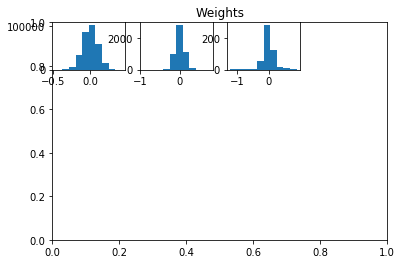

dW 0 Mean -0.666891982547 SD 4.09869060916
dW 1 Mean -0.549121493336 SD 156.908542042
dW 2 Mean -5.4972189726e-05 SD 746.492804679


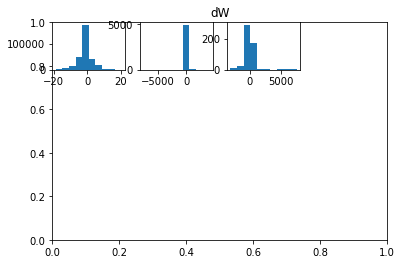

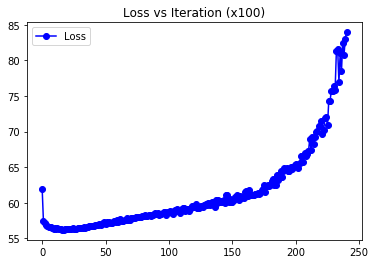

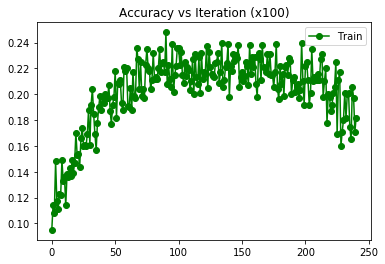

2401


2402


2403


2404


2405


2406


2407


2408


2409


2410


[0 7 4 5 0 4 5 4 0 0 5 7 0 8 0 0 7 4 3 0 4 4 5 5 0 0 5 4 0 0 0 9 1 0 0 0 5
 5 0 0 8 4 0 8 5 1 5 8 0 6 1 0 3 5 0 0 0 3 5 4 0 9 0 7 7 0 8 1 0 0 5 9 0 0
 4 5 5 5 0 0 4 5 0 0 6 4 4 0 5 9 9 0 4 7 0 7 7 0 4 4 2 5 7 7 0 8 1 0 2 0 0
 8 3 5 8 0 3 1 4 4 5 4 0 5 3 5 8 8 5 0 9 0 0 5 0 8 9 3 8 0 0 9 4 7 6 0 0 0
 4 8 1 5 8 7 4 4 0 0 4 0 4 0 0 0 0 8 0 1 9 0 0 0 0 1 0 0 0 6 0 0 0 0 0 0 0
 0 8 0 9 0 0 4 5 7 5 5 0 0 0 4 0 0 3 1 9 5 0 0 4 8 4 0 5 0 3 0 0 0 0 4 0 5
 9 5 4 0 0 6 4 4 9 0 7 4 5 5 5 5 6 0 0 0 0 7 8 0 4 0 0 0 3 1 0 0 4 1 5 5 5
 5 5 0 4 0 0 0 5 7 5 0 5 0 0 4 0 4 7 5 9 4 0 9 0 7 0 5 8 4 4 0 5 4 4 0 5 4
 0 1 7 0 6 0 4 4 0 5 0 8 0 0 7 6 0 4 5 4 1 4 8 4 0 7 0 0 0 0 0 6 5 4 0 4 0
 0 4 3 4 6 4 5 5 3 0 0 0 0 5 4 0 1 0 5 4 0 5 7 0 8 5 4 0 0 0 0 8 4 0 5 0 7
 5 0 0 4 1 5 0 4 5 0 4 9 1 0 7 4 0 0 4 6 7 0 5 4 4 1 7 5 0 0 0 0 0 5 5 9 9
 4 5 0 0 0 5 0 3 4 0 0 4 8 8 5 4 7 6 3 5 0 4 9 8 5 8 5 5 5 1 4 0 0 5 0 0 3
 3 5 0 7 5 0 4 4 5 5 8 0 7 5 0

2443


2444


2445


2446


2447


2448


2449


2450


[6 7 7 8 3 1 7 7 0 0 6 7 0 7 6 0 7 8 9 7 0 3 0 0 0 9 7 7 0 0 0 4 0 6 1 7 8
 7 3 0 6 0 0 1 7 1 8 0 0 7 3 0 8 2 3 8 7 3 0 3 7 7 0 7 7 7 9 6 9 3 3 6 7 7
 4 7 0 3 0 0 0 0 0 7 7 9 6 0 7 7 3 0 7 1 3 8 7 0 9 3 0 0 1 7 0 9 7 7 0 6 0
 6 8 1 9 0 9 7 0 6 3 3 0 8 3 3 0 7 0 0 7 0 0 3 0 8 0 8 7 0 0 3 7 7 7 0 0 0
 0 9 1 1 7 7 6 9 0 0 7 9 7 0 1 0 2 6 5 1 9 8 0 0 6 0 0 0 1 8 5 0 7 0 6 4 0
 0 8 7 7 3 0 3 0 7 7 7 0 0 6 0 9 0 0 8 7 7 7 0 0 7 3 8 6 0 0 0 9 8 0 7 0 7
 9 0 1 3 8 6 4 0 0 0 6 7 0 3 0 1 7 7 0 0 0 1 7 6 3 1 0 0 3 6 1 0 8 0 6 1 5
 8 6 0 7 0 0 0 0 6 7 0 7 8 0 0 0 0 8 9 0 0 0 9 7 7 0 8 8 1 7 0 6 0 6 0 3 3
 0 7 7 0 6 0 0 7 1 1 9 0 0 0 7 1 7 1 0 8 0 6 7 7 7 7 0 0 1 0 8 7 3 9 7 7 0
 0 0 1 0 1 7 3 1 1 0 0 0 7 9 7 8 7 0 1 9 0 3 9 0 7 7 0 3 0 0 0 8 7 0 0 7 7
 9 0 7 7 3 3 0 6 8 1 9 1 9 8 7 0 0 0 8 7 0 0 6 0 7 7 7 9 0 0 9 0 0 7 7 3 9
 6 0 9 0 0 7 2 7 2 3 8 8 9 0 7 3 7 6 7 7 7 9 0 7 7 8 7 0 6 9 7 7 0 6 7 7 7
 0 3 9 7 7 0 9 9 1 6 0 9 8 6 0 4 0 6 7 0 0 8

2483


2484


2485


2486


2487


2488


2489


2490


[6 1 1 8 5 1 7 9 0 1 7 0 0 7 3 0 7 4 0 4 3 3 1 7 0 4 7 8 0 6 0 0 0 0 6 7 0
 7 0 0 7 0 0 0 7 1 7 8 0 7 8 0 8 0 0 6 7 9 0 4 7 8 0 0 9 0 7 7 3 0 0 7 7 7
 0 7 0 7 0 0 0 6 0 4 1 4 4 4 7 7 3 0 8 7 3 7 7 0 7 3 5 1 7 1 3 1 7 7 0 7 0
 7 0 7 9 0 5 7 3 4 6 0 0 0 0 3 0 8 0 0 6 0 7 3 3 8 0 0 7 0 0 9 6 7 6 0 3 7
 7 6 0 4 7 7 1 3 0 0 0 3 0 0 0 3 7 7 0 6 9 0 0 0 0 0 0 6 1 6 5 1 7 0 0 0 0
 0 6 8 7 7 4 5 9 7 8 0 0 8 3 0 4 4 8 4 7 7 3 0 7 7 3 7 4 0 0 5 5 7 0 1 7 5
 0 7 1 0 7 7 0 4 0 0 0 7 5 0 3 4 7 7 9 7 0 1 0 7 7 0 0 9 3 7 1 0 0 0 0 6 5
 5 6 0 3 0 0 0 2 7 8 0 1 7 0 1 0 0 7 9 0 0 0 6 6 7 0 6 3 4 1 4 4 0 6 0 0 9
 0 1 1 0 0 0 0 3 1 7 0 7 0 6 7 8 5 0 9 4 1 9 7 7 7 7 5 0 0 1 0 4 5 9 7 4 4
 0 6 6 6 1 0 5 1 7 0 0 7 7 0 1 0 9 0 1 9 0 6 0 6 7 0 9 6 0 9 0 0 0 0 6 7 7
 9 3 3 7 4 3 0 6 4 0 0 4 9 0 7 9 0 0 7 4 7 0 9 9 0 0 7 0 0 0 3 0 0 6 7 7 9
 0 6 6 8 1 7 0 7 8 7 6 7 7 0 7 7 7 8 9 9 7 7 4 7 7 9 8 0 7 1 6 7 0 6 7 5 1
 0 3 5 7 7 0 4 1 1 7 0 7 7 6 0 4 0 8 7 4 5 5

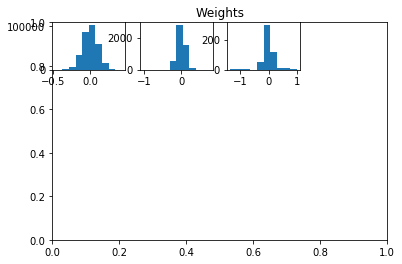

dW 0 Mean -0.146630174533 SD 3.12087034782
dW 1 Mean 0.219649574995 SD 115.628790324
dW 2 Mean -5.49782635026e-05 SD 617.265494871


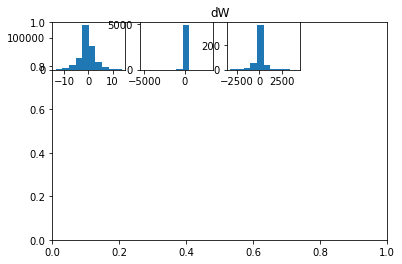

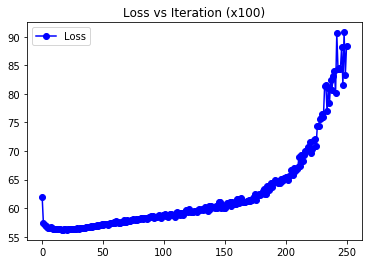

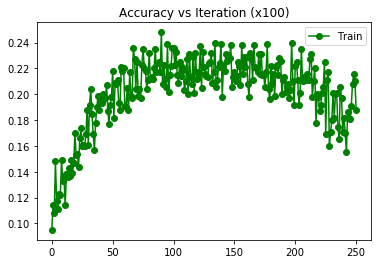

2501


2502


2503


2504


2505


2506


2507


2508


2509


2510


[5 7 0 8 5 5 7 7 0 7 7 7 0 7 0 0 7 7 0 7 0 9 7 7 0 7 8 6 0 5 5 0 0 0 7 0 7
 7 3 3 8 0 0 0 8 1 7 8 0 8 0 0 5 2 3 8 8 0 0 9 7 7 0 7 8 9 5 7 0 0 0 8 7 7
 4 9 0 8 0 0 0 7 0 7 7 0 2 5 7 1 0 0 7 8 0 8 7 0 7 7 0 5 9 7 0 7 7 7 1 7 7
 7 0 1 9 0 0 7 7 5 7 0 0 0 2 0 7 8 0 0 8 4 7 7 0 7 3 0 7 0 0 0 7 9 7 0 3 0
 7 7 0 0 7 7 1 0 7 0 0 0 8 0 0 5 2 8 0 7 5 0 8 7 8 0 0 0 1 8 0 9 7 0 7 9 0
 0 7 7 8 7 0 0 7 7 7 9 0 5 8 1 9 0 8 7 8 7 1 3 0 7 3 7 0 0 9 7 7 8 0 1 7 7
 0 7 1 0 8 7 0 0 0 0 9 7 0 0 0 5 9 8 9 0 4 7 7 1 7 3 0 0 9 7 1 1 7 0 7 5 0
 5 5 8 8 0 0 0 7 7 9 0 7 7 0 6 0 0 7 6 0 7 0 9 7 7 0 9 8 0 7 1 5 9 7 0 0 7
 0 2 0 0 7 0 0 7 7 8 0 7 7 7 7 5 7 9 5 7 9 7 7 7 0 7 0 0 0 8 0 7 9 7 8 9 0
 0 9 3 7 3 0 9 5 7 0 1 0 9 0 7 0 7 8 1 7 0 0 7 7 7 7 0 0 0 7 0 9 0 0 7 7 7
 9 9 7 9 7 3 0 0 9 7 5 9 2 8 7 0 0 0 7 9 7 9 7 0 6 8 7 9 0 0 3 8 0 7 7 8 9
 7 0 8 0 8 8 0 7 8 7 8 7 8 0 7 7 7 9 9 7 7 8 9 7 7 8 7 0 7 7 7 7 0 7 7 5 7
 0 3 5 7 7 9 2 7 1 8 8 9 8 7 0

2543


2544


2545


2546


2547


2548


2549


2550


[2 2 2 4 5 4 2 8 2 1 9 8 4 8 0 9 0 2 0 9 0 2 2 2 4 2 8 8 0 5 0 4 0 4 2 4 9
 2 0 5 8 0 0 2 2 0 2 0 0 2 8 0 8 2 5 0 2 0 0 9 9 2 0 2 2 5 2 0 0 0 0 2 4 2
 0 9 0 5 0 0 9 8 9 8 2 0 2 0 2 8 5 0 8 2 0 0 8 0 2 4 0 0 9 2 0 4 2 4 9 9 2
 2 4 2 2 0 0 2 8 4 5 2 0 0 2 2 8 8 0 0 2 0 2 8 0 8 0 0 2 0 0 9 8 1 9 0 0 8
 4 9 2 9 2 2 1 5 7 0 2 9 2 0 2 0 2 2 0 8 2 0 0 2 0 0 0 0 0 2 0 5 2 4 8 0 0
 0 4 2 2 3 0 0 5 2 2 6 0 5 2 0 0 5 5 2 2 2 2 1 2 8 8 8 5 0 5 0 4 8 0 2 8 4
 0 5 4 0 2 2 0 0 0 0 2 8 0 5 5 4 2 2 0 0 0 2 2 2 2 0 0 0 2 2 1 0 2 5 0 5 2
 5 9 8 4 0 0 0 0 2 5 0 2 2 0 9 5 4 1 2 0 4 0 9 2 2 0 4 8 8 2 0 0 0 0 0 0 9
 0 2 8 0 2 0 0 2 4 2 0 9 0 0 0 0 9 0 5 2 2 4 5 9 5 2 0 0 0 2 0 2 9 4 2 2 0
 0 4 2 4 1 9 5 1 8 0 0 0 2 0 8 0 5 0 1 2 0 2 9 0 2 2 1 2 0 2 5 0 0 0 2 4 2
 9 2 2 9 2 8 4 2 4 0 8 4 9 0 2 8 6 4 2 2 2 0 9 4 9 2 2 9 0 0 2 0 0 2 9 8 4
 0 5 9 8 5 2 5 2 2 9 2 8 4 4 2 2 2 2 9 2 2 2 8 2 9 2 2 0 9 4 2 4 0 4 2 9 8
 0 0 2 8 2 4 1 4 1 2 8 2 8 2 0 0 0 9 2 0 0 5

2583


2584


2585


2586


2587


2588


2589


2590


[0 3 0 0 1 0 6 8 3 0 0 3 3 3 3 3 0 0 9 0 3 3 0 0 3 8 0 8 0 0 0 0 0 4 0 8 0
 3 0 0 8 0 0 8 3 1 3 3 0 0 1 0 8 0 0 4 0 3 0 0 3 9 0 3 3 0 9 0 0 3 3 9 0 8
 0 0 0 3 3 0 0 3 9 0 9 0 8 0 0 0 3 3 8 9 0 2 0 0 0 3 0 3 3 0 0 3 3 0 0 3 0
 0 0 8 8 0 3 1 3 3 3 0 0 0 0 8 3 0 1 0 3 0 8 6 3 3 0 3 0 0 3 3 6 4 3 0 8 0
 3 8 3 0 8 3 0 0 0 0 1 0 3 0 0 3 0 9 0 0 9 0 9 0 0 3 0 0 0 3 0 3 0 8 3 0 0
 3 8 3 3 3 0 1 3 3 8 3 0 0 0 0 0 0 3 3 3 1 0 4 0 3 1 3 3 0 3 0 3 0 0 6 0 3
 0 3 3 0 6 3 0 0 0 0 9 8 5 3 0 8 0 9 0 9 0 3 6 2 3 0 0 0 3 1 1 0 4 0 0 0 0
 0 0 3 8 0 0 0 0 0 0 0 0 6 0 8 0 3 0 9 3 3 0 9 2 3 0 3 3 3 3 0 9 0 0 0 0 9
 3 0 6 0 0 0 9 3 3 3 0 0 3 3 0 1 0 1 8 3 0 0 0 3 4 2 4 0 0 3 8 3 0 3 8 3 0
 0 3 6 0 3 0 9 1 8 0 0 0 3 0 3 0 3 0 3 3 0 3 3 0 3 0 9 3 0 6 3 0 0 8 0 0 9
 0 0 0 0 3 0 9 4 3 9 3 3 3 8 8 0 0 0 3 0 8 2 8 8 3 4 0 0 0 6 3 0 9 3 9 0 4
 0 0 0 8 0 3 9 0 0 9 3 8 3 0 0 3 3 3 8 9 0 3 0 8 3 0 0 0 3 1 3 3 0 6 3 0 0
 0 9 3 3 0 0 8 3 3 3 8 0 8 8 9 0 1 0 3 0 0 0

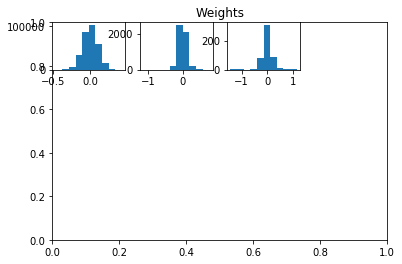

dW 0 Mean 1.20971103358 SD 3.86031106252
dW 1 Mean -3.66561101624 SD 116.898991236
dW 2 Mean -5.4990562594e-05 SD 651.722545731


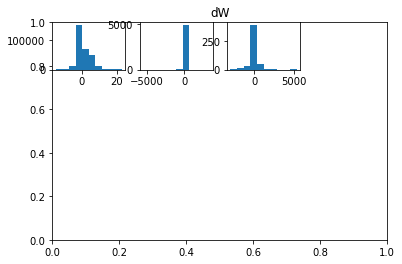

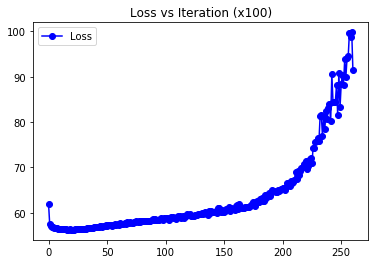

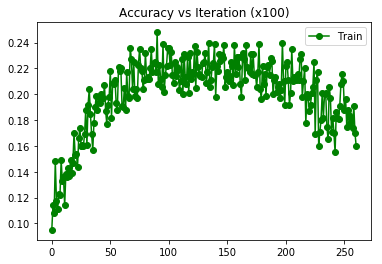

2601


2602


2603


2604


2605


2606


2607


2608


2609


2610


[0 0 1 5 1 1 6 3 8 1 0 3 0 3 0 0 1 1 9 6 0 3 0 5 3 8 1 0 0 8 0 0 0 4 6 0 1
 1 9 0 8 0 0 3 9 1 0 0 0 6 0 0 0 2 0 0 0 0 0 3 3 8 0 1 5 5 5 6 0 0 0 5 3 5
 9 5 0 5 0 0 0 1 0 0 3 0 5 2 8 6 3 0 8 1 0 5 5 9 8 0 0 3 3 3 0 5 3 6 3 3 5
 6 0 1 8 0 9 5 0 1 3 6 0 8 2 5 8 8 0 0 5 0 4 8 0 8 5 0 8 0 0 8 5 1 5 0 3 0
 6 5 3 5 5 3 1 0 7 0 1 3 0 0 5 0 2 6 0 1 3 8 9 1 7 0 0 1 1 5 0 5 6 9 6 0 0
 0 3 0 6 3 0 1 0 7 1 5 0 5 3 0 9 5 5 5 3 3 1 0 0 8 3 3 5 0 5 0 5 0 0 8 6 6
 0 5 1 0 8 3 4 4 0 0 3 5 5 8 1 6 1 3 0 7 0 6 8 9 3 0 4 0 3 5 0 0 5 0 6 5 0
 0 5 0 5 0 0 0 0 6 3 0 5 5 0 9 9 3 1 9 3 0 5 5 0 7 0 0 8 1 3 5 0 0 0 0 0 9
 0 1 6 0 6 0 0 0 1 5 0 0 1 0 1 1 1 3 5 9 1 0 0 9 1 8 0 8 0 0 8 5 3 0 5 3 0
 0 3 3 0 6 8 0 5 3 0 0 0 0 8 3 0 5 0 1 9 0 0 3 7 1 8 5 3 0 3 0 0 0 8 0 0 5
 9 3 7 9 3 3 0 0 5 4 3 5 9 8 7 0 0 4 0 0 5 0 8 3 0 1 1 8 0 0 0 8 9 5 5 8 8
 3 0 5 8 5 9 0 1 1 5 3 5 6 5 5 6 9 5 1 9 6 6 0 8 9 6 3 5 0 8 3 6 5 3 5 8 0
 0 0 3 0 5 8 1 5 5 8 0 3 6 3 9

2642


2643


2644


2645


2646


2647


2648


2649


2650


[8 7 2 5 8 1 2 7 2 0 1 2 0 7 1 0 2 2 0 9 0 3 2 9 3 8 2 8 0 5 3 0 1 0 8 0 8
 2 0 0 3 6 0 3 7 0 2 8 0 1 0 0 0 0 0 8 2 0 0 2 5 9 0 2 7 9 8 2 3 0 0 2 7 9
 4 2 0 5 0 0 0 1 0 7 9 5 2 2 7 5 0 0 2 1 0 2 7 0 1 9 2 0 5 8 0 1 0 2 0 8 0
 5 3 5 9 0 0 6 2 5 2 5 0 0 0 8 5 7 0 0 2 0 2 5 0 8 0 0 5 0 0 9 5 5 2 0 0 0
 5 8 2 2 8 9 2 9 0 0 2 9 8 0 0 0 5 2 8 8 2 8 5 5 7 1 0 0 1 8 0 1 7 8 7 5 0
 0 2 0 8 7 0 5 0 7 7 2 0 0 2 1 0 0 8 2 8 8 1 6 2 7 0 2 5 0 0 0 5 7 0 1 2 5
 9 1 8 0 8 7 0 0 0 0 9 5 0 8 0 5 1 6 8 0 0 2 2 2 2 0 0 0 0 2 5 9 7 0 6 1 0
 0 8 8 7 0 0 0 0 2 0 0 2 2 0 9 9 2 7 5 3 0 0 9 2 2 0 7 5 3 7 0 5 0 2 0 0 5
 0 0 1 0 2 0 0 2 7 8 0 5 0 1 7 0 1 0 0 2 1 0 7 9 5 8 0 8 0 1 8 8 5 9 7 3 5
 0 8 1 0 1 7 5 1 9 0 1 0 7 8 8 0 2 0 1 8 5 2 9 1 1 1 9 6 0 2 0 5 0 8 1 6 2
 9 2 0 0 8 1 0 2 5 0 2 5 2 0 9 0 0 0 2 2 2 2 3 8 6 1 2 9 0 0 0 0 5 5 8 8 0
 3 1 8 0 0 2 5 2 2 5 2 1 5 0 1 1 9 2 9 2 8 2 0 7 9 5 2 5 8 3 8 1 0 5 2 5 2
 9 0 9 7 1 2 9 2 1 8 8 2 7 8 9 2 0 1 

2683


2684


2685


2686


2687


2688


2689


2690


[0 1 7 4 7 1 7 7 1 1 7 7 1 7 0 3 7 8 0 7 0 3 1 7 7 9 1 8 0 0 0 0 1 4 7 7 7
 7 0 0 7 0 0 3 7 0 9 8 0 1 1 0 8 0 0 7 7 0 0 9 8 3 7 7 7 7 8 7 0 3 3 7 9 7
 0 7 1 9 0 3 0 7 0 7 8 3 0 7 9 9 9 0 7 7 5 7 7 0 7 3 0 3 8 7 0 8 7 7 0 3 7
 7 0 5 0 0 0 7 8 7 3 3 0 0 0 3 9 7 9 1 7 4 7 8 0 7 7 1 7 0 0 3 4 9 0 0 0 7
 0 7 0 9 7 7 1 0 0 0 7 0 0 0 0 0 0 8 0 1 8 3 7 7 3 0 3 9 1 3 0 0 0 3 7 0 0
 0 8 3 7 7 0 0 0 7 7 7 0 0 3 0 4 0 0 3 8 7 8 0 7 7 3 7 1 0 0 0 8 9 0 4 7 7
 0 7 3 5 7 9 0 4 9 0 9 7 0 3 3 8 7 7 9 7 0 7 7 3 7 0 0 0 7 8 1 0 7 1 7 1 0
 0 3 0 3 7 0 0 9 7 0 0 7 8 0 3 0 0 7 7 3 9 7 5 8 7 0 7 3 3 1 0 4 9 0 5 0 9
 0 1 1 0 7 0 0 7 8 1 9 0 0 7 7 5 8 1 7 9 7 7 7 7 9 7 0 0 0 1 8 1 3 3 5 0 4
 0 9 3 3 9 7 0 5 7 0 7 7 7 8 7 0 8 0 1 8 0 0 9 0 7 7 4 1 0 7 3 0 0 0 7 7 7
 0 3 7 7 7 3 0 4 3 0 7 3 9 0 7 9 3 0 7 0 7 7 8 9 7 8 7 4 0 0 0 8 8 7 7 8 8
 3 0 9 8 0 7 0 7 0 0 8 7 7 0 7 7 7 7 3 7 0 7 3 7 7 1 7 0 7 7 7 7 0 3 7 7 3
 0 0 9 7 7 8 9 7 3 7 3 7 7 3 0 0 5 9 7 0 0 0

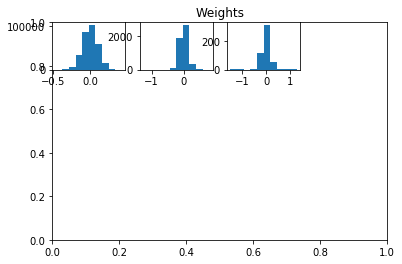

dW 0 Mean 0.528385189903 SD 4.30177169673
dW 1 Mean -1.53575978001 SD 127.430684318
dW 2 Mean -5.49921675301e-05 SD 881.644109208


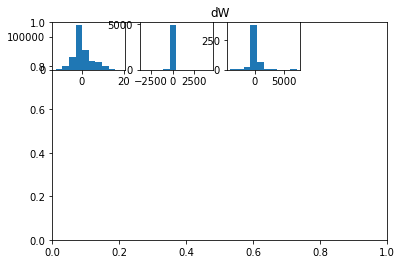

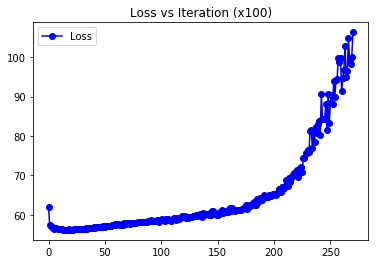

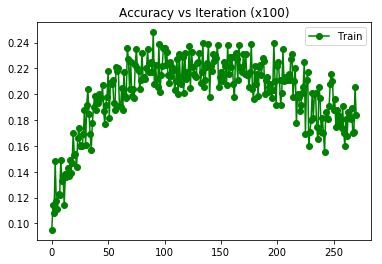

2701


2702


2703


2704


2705


2706


2707


2708


2709


2710


[0 6 0 4 1 1 6 6 6 0 1 6 0 6 3 0 6 3 0 6 0 6 0 6 3 0 6 6 9 0 0 0 0 0 0 0 0
 6 3 0 3 4 0 6 6 0 6 3 0 6 8 0 8 0 0 0 0 0 0 9 6 9 0 6 8 6 8 6 0 5 0 6 0 6
 0 0 0 3 0 3 4 6 0 6 8 5 0 4 0 0 3 3 6 1 0 8 6 0 1 0 0 3 0 0 5 1 9 6 2 0 0
 6 3 1 6 0 0 0 3 3 6 0 0 0 4 3 3 6 0 1 0 0 8 6 3 8 0 0 0 0 7 3 4 6 0 0 0 0
 3 6 6 8 6 0 3 9 7 0 0 3 0 0 5 0 5 9 0 6 6 3 6 6 3 0 3 0 0 6 1 0 6 8 9 4 0
 0 8 3 9 3 0 3 0 0 6 0 0 0 6 0 0 0 3 1 3 0 0 4 6 0 3 0 0 0 0 0 0 0 0 0 0 6
 0 3 1 0 6 6 0 0 0 0 0 6 0 8 0 8 6 3 0 7 0 0 8 0 3 0 0 0 9 6 1 0 0 1 6 8 0
 0 0 0 8 6 0 0 5 6 0 0 6 6 0 0 9 0 1 6 0 6 0 8 6 6 9 6 8 3 6 0 0 0 6 0 0 0
 0 2 6 0 6 0 0 0 6 6 0 0 0 6 0 1 1 1 0 9 1 6 0 0 1 6 0 0 0 0 4 6 9 0 6 3 0
 0 3 0 8 1 0 0 5 8 0 0 0 0 0 3 0 6 0 1 6 0 3 3 0 0 0 0 6 0 6 5 0 0 3 0 6 6
 9 6 0 0 6 1 9 1 3 0 9 3 6 0 6 0 0 0 9 0 1 0 6 0 3 0 8 0 0 0 3 8 0 6 6 3 0
 3 8 6 8 0 8 5 6 3 8 6 3 6 6 6 6 3 6 9 3 6 6 3 0 5 6 6 0 0 3 0 6 0 0 0 0 0
 0 0 9 4 6 0 8 8 3 8 3 3 0 3 3

2743


2744


2745


2746


2747


2748


2749


2750


[2 8 1 8 8 1 6 2 0 0 0 8 0 7 8 0 0 4 5 7 0 4 7 1 4 0 2 7 0 0 0 0 4 6 8 7 1
 6 0 5 7 0 0 0 9 1 8 0 0 1 0 0 8 2 0 0 6 3 5 6 8 8 0 6 7 0 8 0 0 9 0 2 7 0
 0 6 0 5 0 0 0 6 5 0 5 0 2 0 9 6 0 0 4 5 5 2 0 0 8 8 0 5 7 7 5 1 0 7 9 2 2
 8 0 5 8 0 0 4 1 0 6 1 0 0 0 0 1 0 9 0 6 0 8 2 0 8 3 2 7 8 0 0 4 7 1 0 0 0
 5 0 1 0 7 7 2 4 0 0 2 0 8 0 0 5 0 7 9 1 5 2 5 1 7 0 0 0 1 6 5 7 2 0 7 0 0
 0 8 5 6 5 0 5 5 7 8 6 0 4 6 7 0 0 8 8 5 6 4 4 0 0 4 7 5 0 0 0 5 0 0 6 8 6
 0 0 1 0 8 4 0 0 0 0 0 6 9 0 8 4 7 0 9 7 0 6 7 9 4 0 0 0 0 7 5 0 7 0 5 5 0
 5 2 8 8 0 0 0 5 6 7 0 2 8 0 4 0 0 7 9 3 0 7 0 6 2 0 7 0 1 0 0 0 9 4 0 5 0
 0 2 6 0 1 4 0 7 9 7 0 0 5 2 7 1 6 0 0 0 5 7 7 6 8 7 0 0 0 8 0 1 0 0 1 4 0
 0 0 2 0 1 1 0 1 1 0 1 0 7 8 0 0 2 8 1 8 0 0 0 0 0 6 0 2 0 6 0 0 0 0 0 0 7
 0 0 0 8 1 6 9 4 4 0 6 5 9 0 9 9 0 0 7 9 7 4 7 0 6 8 1 0 0 0 0 8 0 0 1 8 9
 4 0 0 0 8 9 0 1 0 1 0 0 6 0 7 8 9 2 6 7 0 8 0 0 7 8 6 0 7 1 4 0 4 1 7 0 1
 0 3 0 1 7 8 1 6 1 0 0 0 1 8 0 0 0 8 7 0 0 0

2783


2784


2785


2786


2787


2788


2789


2790


[0 1 6 6 3 1 8 0 4 0 8 6 3 6 0 0 6 8 9 0 3 6 1 6 6 0 6 6 0 8 0 0 0 4 1 6 1
 4 0 0 9 0 0 0 1 1 0 8 0 0 0 0 8 0 3 6 6 3 0 4 8 3 0 6 1 0 8 0 0 1 3 6 6 6
 0 6 1 4 0 3 9 0 0 0 6 3 4 0 8 6 9 0 4 6 6 6 6 1 1 3 5 3 8 6 0 0 3 6 0 3 0
 6 0 5 3 0 0 6 4 4 3 6 0 9 0 0 6 8 0 0 6 0 4 1 0 6 0 0 0 0 0 9 0 6 6 0 0 0
 3 5 9 1 6 0 1 0 0 0 1 9 0 0 0 0 0 9 0 1 9 8 6 5 0 0 0 3 1 8 5 5 1 0 8 0 0
 0 6 1 6 3 0 1 0 6 8 6 5 0 6 0 0 0 0 3 9 1 0 4 0 8 1 8 0 0 0 6 0 3 0 0 0 1
 0 8 4 0 8 6 0 4 0 0 6 6 0 0 0 6 6 1 0 3 0 1 6 3 3 0 0 0 1 6 1 0 1 0 0 6 0
 0 6 8 6 0 0 0 0 6 6 0 6 6 0 1 0 0 0 9 0 0 0 9 6 6 9 8 3 3 1 0 6 0 0 0 0 3
 0 2 6 5 9 0 0 0 6 6 9 0 0 6 6 1 1 1 0 6 1 0 6 6 4 6 0 0 0 0 8 4 3 1 8 0 0
 0 8 1 1 1 1 0 8 8 0 1 0 6 5 3 0 6 0 6 6 0 0 3 0 6 6 1 1 0 6 0 0 0 8 6 6 0
 9 5 3 4 1 3 0 6 3 0 6 3 4 0 6 4 0 0 0 0 4 2 9 4 9 8 1 9 0 0 0 0 0 6 1 8 9
 0 0 9 8 5 3 5 1 1 0 9 0 8 0 6 3 6 1 1 8 0 0 9 8 3 6 6 0 0 3 3 0 0 0 1 0 0
 0 0 9 0 1 9 8 8 3 8 3 0 1 3 0 0 0 9 4 0 0 0

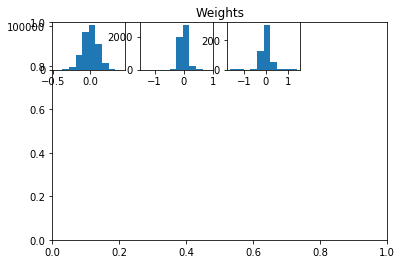

dW 0 Mean 0.0499856405814 SD 8.92635817491
dW 1 Mean -3.3133870682 SD 258.634281732
dW 2 Mean -5.49925706291e-05 SD 1138.9720848


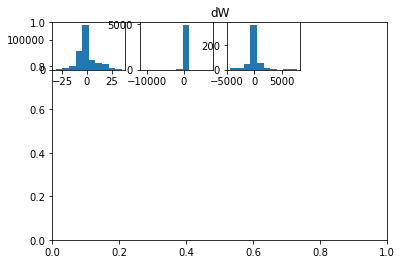

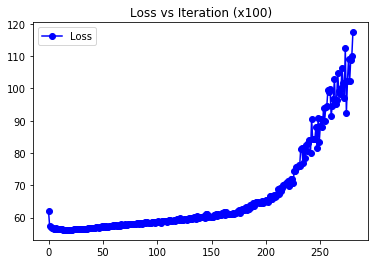

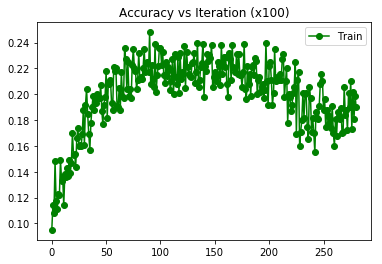

2801


2802


2803


2804


2805


2806


2807


2808


2809


2810


[1 6 4 4 5 1 8 4 5 0 4 4 1 4 3 0 6 1 0 9 9 4 1 5 3 4 4 9 0 5 0 4 0 4 4 9 1
 4 0 6 3 0 1 3 6 1 0 8 0 4 1 0 3 1 0 5 4 0 0 5 5 3 0 6 4 3 9 0 0 0 3 9 1 4
 0 4 5 3 0 0 0 1 0 9 1 0 1 4 6 0 3 0 4 1 0 4 9 4 9 3 0 4 3 6 0 4 4 1 0 3 5
 4 3 5 6 0 9 4 1 5 3 5 0 3 0 8 3 9 0 0 0 0 0 6 9 9 0 4 4 0 1 3 4 4 3 0 9 3
 4 5 0 9 9 4 4 5 0 0 4 3 4 3 0 6 0 9 9 6 1 4 1 5 4 5 9 3 4 4 0 0 4 9 3 0 0
 0 4 0 6 3 0 1 8 4 8 6 0 4 3 5 0 4 3 1 3 4 1 0 0 4 4 5 1 0 3 6 8 5 0 4 9 6
 0 4 5 0 4 4 0 0 9 5 9 5 9 8 5 1 9 1 0 0 0 3 4 5 4 3 0 0 3 1 1 0 4 0 5 1 0
 5 6 3 9 0 0 9 0 6 4 0 3 6 0 4 0 4 4 5 6 4 0 9 4 4 0 4 3 8 4 4 9 0 4 0 0 3
 3 2 9 0 6 0 0 1 4 3 4 5 0 0 3 1 9 1 9 9 5 4 6 4 4 8 0 0 0 3 0 1 3 4 1 8 5
 0 3 3 0 1 4 0 1 6 0 4 0 4 5 3 0 1 0 3 4 0 5 3 9 1 8 4 0 0 3 0 5 0 5 1 4 4
 4 9 5 3 4 8 4 1 3 9 4 9 6 9 9 4 0 0 9 4 4 0 9 3 3 5 1 5 0 6 9 8 5 0 9 9 9
 3 5 9 0 0 4 0 1 1 3 4 4 5 4 4 4 3 5 3 4 6 9 3 8 4 5 3 0 6 3 3 1 0 1 1 9 3
 0 9 3 0 5 3 4 4 4 3 9 4 1 5 0

2843


2844


2845


2846


2847


2848


2849


2850


[2 8 1 0 0 1 6 7 5 0 6 7 0 6 6 0 6 2 0 7 0 9 7 2 0 0 1 7 0 0 0 9 0 0 1 0 6
 2 9 6 2 0 0 0 2 0 7 0 0 7 0 0 8 0 3 0 6 3 0 2 8 2 0 2 7 7 2 2 3 0 0 8 7 6
 0 2 0 8 0 0 2 2 9 7 6 6 2 0 0 8 0 0 8 2 7 1 1 0 2 8 2 0 0 2 0 5 7 7 2 2 0
 2 8 2 2 0 0 2 8 5 2 2 0 2 0 0 6 7 9 0 7 0 2 8 0 8 0 2 8 0 0 2 2 6 0 0 0 0
 7 6 2 2 8 0 1 5 7 0 1 8 0 0 0 0 0 6 5 1 2 0 1 5 7 0 0 5 1 2 2 0 1 0 7 0 0
 0 7 7 2 3 0 2 0 6 2 9 5 0 0 7 0 0 0 7 2 1 2 6 7 2 8 2 6 0 0 0 5 0 0 7 6 7
 2 7 5 0 6 2 0 0 0 0 2 2 5 0 6 8 7 8 0 0 0 2 6 2 7 4 0 9 9 2 3 9 7 0 1 2 0
 0 2 5 8 0 0 0 0 1 6 0 7 7 0 2 0 2 7 2 3 7 0 2 2 7 0 6 2 9 7 8 2 9 0 0 0 5
 0 7 1 0 2 0 0 2 7 2 0 2 0 0 6 1 0 0 8 0 2 9 7 2 2 2 0 0 0 2 8 2 0 7 7 7 4
 0 9 2 7 1 6 0 1 7 0 1 0 7 8 2 8 7 0 1 0 0 2 8 6 7 6 2 8 0 9 5 0 0 8 2 7 9
 2 0 7 9 1 0 0 2 0 0 2 0 9 8 2 4 5 0 2 0 2 0 5 0 7 8 1 9 0 0 0 0 0 2 2 8 0
 0 6 7 8 5 7 0 2 2 8 2 7 8 0 2 6 7 6 9 6 0 6 5 8 2 2 7 0 7 0 2 7 0 1 2 5 7
 0 7 6 6 1 2 2 8 2 7 0 9 8 8 3 0 0 8 7 4 0 0

2883


2884


2885


2886


2887


2888


2889


2890


[8 1 0 6 1 1 8 6 0 2 8 8 0 6 0 9 2 2 0 6 0 6 8 0 0 2 2 2 0 0 6 9 0 2 1 0 6
 6 0 5 2 0 0 0 2 2 8 8 0 0 0 0 8 6 0 8 6 9 0 0 2 6 0 2 2 8 8 2 0 3 0 6 8 0
 9 0 0 1 0 0 2 6 0 6 2 0 8 2 6 2 0 5 2 6 0 2 6 0 8 6 2 2 8 2 3 2 2 2 3 2 0
 8 8 2 8 0 0 2 2 1 6 2 0 0 0 8 5 2 1 0 2 0 2 6 0 8 0 0 0 0 0 0 8 6 0 0 0 0
 5 6 2 2 2 2 0 0 7 0 1 2 0 0 0 6 2 2 0 6 8 2 1 0 6 3 8 1 1 8 2 0 1 0 1 9 0
 0 8 2 6 0 4 0 8 8 1 8 0 2 2 0 3 0 0 2 8 2 8 1 2 8 1 0 6 0 6 0 2 2 0 6 0 2
 0 2 1 0 8 0 0 0 0 0 2 6 9 8 6 2 2 1 0 0 0 1 0 2 2 3 0 0 2 0 1 0 2 1 1 2 0
 8 6 0 6 0 1 0 9 2 6 0 6 1 0 0 0 2 2 2 6 6 0 8 6 8 0 6 8 1 2 0 2 0 8 0 0 6
 0 1 1 0 2 0 4 6 8 6 0 2 0 2 2 6 1 1 0 2 2 1 0 2 2 2 0 0 0 1 8 2 0 1 2 8 0
 0 0 1 0 6 0 9 1 2 0 0 0 0 0 8 0 6 0 1 6 0 6 2 0 0 2 2 1 0 2 0 0 0 8 8 6 6
 2 2 2 2 1 2 0 2 2 0 6 1 1 8 1 0 0 0 2 0 2 0 6 0 0 5 8 0 0 0 0 8 8 2 2 8 1
 2 0 8 8 0 2 2 1 0 0 2 6 1 6 8 2 2 2 1 2 0 2 0 2 2 2 8 0 2 6 8 1 0 6 2 2 2
 0 0 0 2 0 8 2 2 1 2 0 2 2 8 0 0 0 6 2 0 0 0

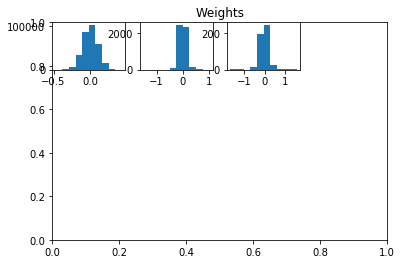

dW 0 Mean 0.590176118333 SD 4.49353167839
dW 1 Mean 1.22797775711 SD 124.313445552
dW 2 Mean -5.49917822427e-05 SD 1186.36120174


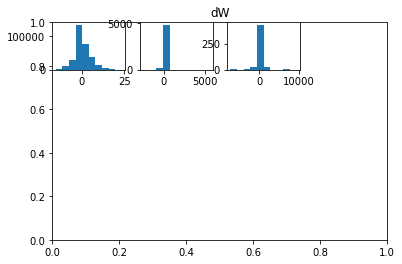

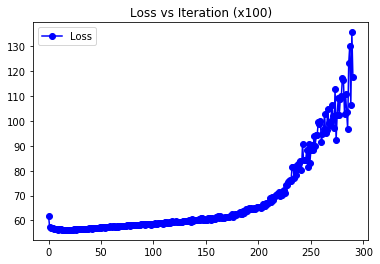

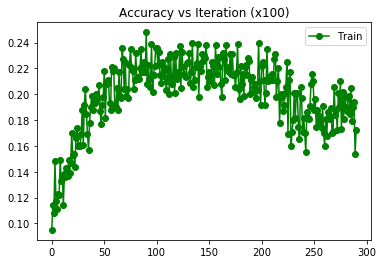

2901


2902


2903


2904


2905


2906


2907


2908


2909


2910


[5 9 4 5 1 5 5 1 5 0 5 6 0 3 3 0 5 9 9 9 0 3 5 6 3 0 5 4 4 0 0 0 0 0 1 5 1
 5 0 5 8 5 0 3 5 3 5 9 0 4 0 0 8 0 0 5 5 0 0 5 9 5 0 1 5 0 5 5 0 0 0 5 3 0
 4 5 0 5 0 0 8 0 0 9 5 0 5 0 8 5 5 0 8 5 0 5 5 5 4 9 0 0 5 1 0 5 3 6 0 9 0
 5 3 1 3 0 0 5 1 5 5 1 0 0 0 5 5 5 0 0 5 0 5 1 0 8 0 1 6 0 9 0 0 5 5 0 0 9
 5 5 0 5 5 5 1 7 0 0 1 0 9 0 0 0 2 1 9 8 5 3 5 5 5 0 0 5 0 5 5 1 5 5 3 0 4
 0 8 1 9 3 0 5 9 5 8 1 0 5 5 4 0 0 8 1 8 5 8 0 6 5 1 5 5 9 9 0 1 1 0 5 0 5
 0 9 5 0 8 5 0 0 9 4 9 5 0 5 5 1 1 3 0 7 0 0 5 5 5 0 0 3 9 6 5 1 9 0 1 5 0
 5 9 0 5 0 0 0 0 6 0 3 6 5 0 3 0 0 0 9 9 5 0 9 1 5 0 5 5 3 8 0 5 4 4 0 0 5
 0 1 1 0 5 0 0 1 5 6 0 5 1 0 5 1 5 0 0 3 5 5 0 6 5 0 0 0 0 3 8 5 9 0 1 9 0
 0 5 1 8 5 5 5 1 9 0 1 0 5 0 3 0 5 0 5 6 0 0 0 0 6 5 6 3 0 5 0 0 4 0 1 0 5
 5 5 0 5 4 5 5 1 5 0 9 1 5 8 5 4 0 0 5 5 5 0 5 9 0 5 5 5 0 6 9 0 0 5 9 8 8
 3 5 0 0 5 9 0 9 8 9 5 5 5 5 5 1 5 1 6 5 0 0 5 1 0 8 5 5 5 3 5 1 9 5 1 8 8
 0 0 9 1 5 9 5 6 5 9 5 9 5 8 9

2943


2944


2945


2946


2947


2948


2949


2950


[6 6 8 5 5 5 6 0 5 2 6 6 3 6 0 0 0 0 9 0 0 6 5 0 6 0 9 6 0 5 3 0 0 0 6 0 1
 6 0 0 6 4 1 8 1 5 5 5 0 1 0 0 8 1 0 6 6 0 1 8 6 6 0 6 6 6 8 6 0 9 0 8 6 0
 0 6 0 5 0 0 9 1 0 6 6 0 8 0 6 1 9 0 8 6 5 0 9 0 0 8 6 0 5 6 0 5 1 6 0 9 5
 6 6 5 0 0 0 6 0 9 8 6 0 0 2 5 6 8 3 0 6 3 5 8 1 8 0 1 6 0 0 0 8 6 0 0 0 0
 5 9 0 8 6 5 6 0 0 0 6 0 8 0 5 5 6 6 0 1 9 8 9 0 6 0 0 0 0 6 5 5 5 8 0 0 0
 0 6 0 5 3 0 0 0 6 6 5 0 0 6 0 0 0 5 5 9 6 8 4 0 6 8 6 6 0 5 0 0 5 0 8 0 5
 0 5 1 0 6 5 0 0 0 0 0 6 5 8 6 6 1 0 9 7 0 6 8 2 5 1 4 3 9 6 1 0 8 5 5 1 0
 5 6 8 6 0 0 0 5 5 6 0 6 1 0 0 0 0 0 6 9 6 0 6 6 1 0 6 8 1 6 0 5 0 0 0 5 6
 0 2 1 0 6 8 0 6 6 6 0 5 0 0 0 5 0 0 9 6 5 6 6 6 0 1 0 0 8 0 8 6 0 1 8 0 4
 0 5 6 0 6 1 0 1 8 0 0 0 0 8 0 0 6 0 5 8 0 0 0 0 6 6 6 0 0 6 8 8 0 8 0 0 6
 9 6 0 9 6 5 5 0 5 0 6 9 6 8 9 0 6 0 6 0 0 4 9 8 6 5 8 5 0 0 0 8 0 6 1 8 8
 0 1 8 0 8 6 0 1 6 5 0 6 5 6 6 1 6 6 9 6 8 6 5 8 8 8 6 0 6 6 8 6 0 6 6 8 0
 0 3 8 6 6 8 0 6 5 1 5 0 6 8 0 0 0 6 5 0 0 0

2983


2984


2985


2986


2987


2988


2989


2990


[0 1 8 8 3 0 2 2 2 2 8 2 0 2 3 0 1 3 0 6 0 3 2 2 3 0 2 8 0 8 2 0 0 0 2 9 1
 2 9 9 8 0 0 3 2 3 8 8 0 0 3 0 8 0 5 2 1 0 5 6 2 3 0 2 2 1 8 2 9 0 3 2 3 6
 0 0 0 2 0 5 2 1 9 6 2 4 2 4 6 8 0 0 2 2 2 2 6 0 9 3 0 8 2 9 0 3 2 0 0 3 0
 2 3 2 0 0 0 2 3 1 8 2 0 0 2 8 8 2 0 0 2 0 0 1 0 2 3 3 6 0 0 0 8 6 1 0 0 0
 6 2 3 2 2 2 8 2 0 0 2 0 0 3 0 0 2 2 0 8 2 0 0 3 3 0 1 0 0 2 0 0 1 8 8 3 4
 0 2 3 3 0 2 3 3 8 8 2 0 0 3 1 2 0 0 3 8 2 1 0 0 3 3 9 3 0 0 0 2 1 0 2 0 2
 2 3 3 0 0 3 0 2 0 0 2 2 0 3 0 2 2 8 0 0 0 2 2 1 3 0 0 0 0 8 0 0 8 0 2 2 9
 8 8 0 3 0 0 0 9 8 8 0 8 2 0 1 0 3 2 9 0 3 0 6 2 2 0 0 8 3 8 0 0 9 3 0 0 3
 0 2 1 0 2 0 0 2 8 1 0 0 0 0 2 1 1 0 8 2 0 0 3 3 2 2 0 0 0 2 8 2 0 8 2 3 0
 0 2 3 3 1 1 9 8 3 0 1 0 3 0 2 3 2 0 3 3 0 3 3 0 6 8 8 2 0 2 9 0 0 0 2 9 2
 0 2 0 9 2 8 0 2 3 2 3 8 1 0 6 0 0 0 2 0 2 0 8 1 2 2 2 9 0 5 0 8 0 0 3 8 0
 2 8 6 8 8 2 0 2 2 9 8 3 3 6 8 3 3 2 2 9 0 2 0 2 0 2 2 0 6 3 3 3 0 3 6 5 3
 2 0 0 2 6 8 2 2 3 3 3 2 9 8 0 4 0 3 2 0 0 0

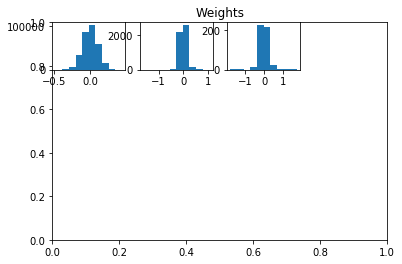

dW 0 Mean -1.38431615938 SD 4.27822962055
dW 1 Mean 1.99942789085 SD 144.602794707
dW 2 Mean -5.49645828496e-05 SD 630.673799975


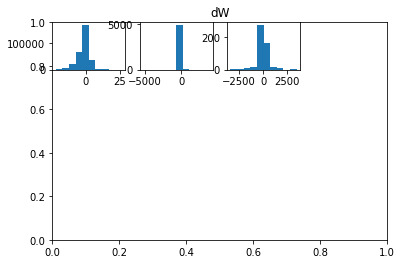

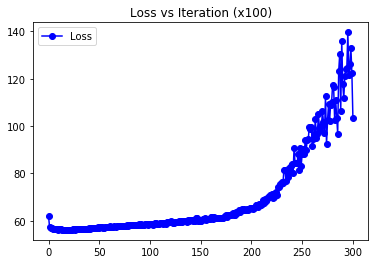

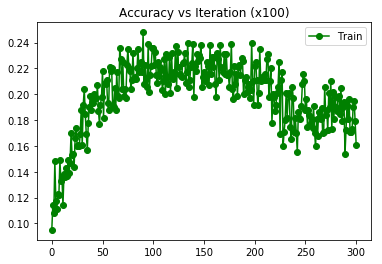

3001


3002


3003


3004


3005


3006


3007


3008


3009


3010


[5 6 0 5 1 1 1 7 5 0 0 9 0 7 3 5 1 1 0 7 0 6 6 7 3 7 1 0 0 8 0 0 0 0 7 9 1
 7 0 3 7 0 1 0 7 0 9 0 0 7 0 0 0 2 3 8 7 0 0 9 7 7 0 7 7 9 9 6 0 5 0 6 7 7
 0 5 0 7 0 0 0 6 5 8 8 0 6 0 7 1 5 0 7 1 7 1 7 5 0 5 2 1 7 7 0 8 7 7 0 7 7
 8 0 6 5 0 3 0 7 5 5 5 0 0 0 7 9 8 0 0 7 4 7 1 9 7 0 0 7 0 0 7 6 7 7 0 3 5
 7 9 6 9 7 7 0 0 7 0 7 0 0 0 0 0 6 6 5 8 9 3 5 5 7 5 0 1 1 7 5 7 1 0 7 0 0
 0 6 7 9 0 0 5 0 7 7 6 0 0 6 0 9 5 0 5 8 5 1 6 0 0 6 7 0 0 0 0 5 7 0 0 9 7
 0 7 3 0 7 7 0 6 0 0 6 7 0 8 5 6 7 0 0 7 0 7 7 0 0 0 0 0 7 7 0 1 8 5 6 7 0
 5 9 0 7 0 0 9 9 7 7 0 7 9 0 9 6 0 8 7 0 7 0 5 6 7 7 7 6 9 7 9 6 0 6 0 5 9
 0 7 7 0 7 5 0 7 9 8 0 5 0 0 7 1 5 1 9 0 0 7 7 7 5 5 5 0 0 0 0 7 0 9 7 5 0
 0 9 0 6 1 1 0 1 8 0 0 0 0 5 0 0 7 0 5 5 0 0 7 0 0 6 5 0 0 7 0 5 0 0 6 0 7
 5 5 0 7 7 6 9 1 5 7 6 1 6 8 7 7 0 0 1 7 7 0 5 0 7 1 7 5 0 5 0 0 0 5 7 9 9
 6 0 7 0 5 7 0 6 6 0 6 1 9 5 7 7 7 1 7 6 7 6 9 7 7 8 8 0 9 7 0 7 0 0 1 5 7
 0 0 5 7 1 8 5 9 5 7 5 7 9 6 3

3043


3044


3045


3046


3047


3048


3049


3050


[4 3 3 4 3 0 1 3 3 2 4 3 0 3 1 3 6 4 0 3 3 9 6 6 3 0 6 4 0 8 2 0 0 4 0 3 6
 3 0 0 3 0 0 3 4 1 3 8 0 6 3 0 3 5 3 9 0 0 0 3 3 3 0 0 3 3 8 8 3 0 3 4 3 8
 0 3 0 8 3 0 4 6 0 4 3 0 4 0 1 4 3 0 4 6 3 4 6 9 4 8 0 9 3 3 0 1 8 6 0 3 0
 4 3 8 3 0 0 1 3 3 3 3 0 0 0 3 3 8 0 0 6 0 4 8 0 3 0 3 3 0 0 0 4 4 9 0 3 3
 3 6 1 1 3 3 3 4 0 0 4 3 3 0 0 5 0 6 0 1 9 3 0 3 4 0 1 3 1 8 4 0 1 8 8 0 0
 0 8 3 3 0 0 3 8 6 6 3 0 4 3 0 4 4 3 8 3 3 3 0 0 3 3 3 3 0 3 2 3 3 0 3 3 3
 3 3 3 0 6 3 0 4 0 5 9 0 9 3 3 4 3 6 0 0 0 1 3 0 3 3 0 0 3 6 0 0 4 0 1 6 0
 0 3 0 3 0 0 0 0 1 3 0 1 3 0 3 0 9 3 3 0 3 0 6 8 3 0 8 3 3 0 0 0 0 3 0 0 3
 0 4 0 0 1 0 0 3 3 6 0 0 0 0 1 1 0 0 0 3 4 0 3 3 4 1 0 8 8 1 8 8 9 8 0 3 0
 0 3 1 3 9 1 0 0 1 0 0 0 3 8 3 0 8 0 3 8 0 0 0 0 3 8 4 3 0 6 0 0 0 0 1 0 4
 9 0 0 3 3 3 0 4 3 0 3 3 6 8 3 4 0 0 3 4 4 0 8 3 3 0 3 9 0 0 3 0 0 3 3 8 4
 8 6 9 8 9 3 5 3 8 3 9 8 8 0 4 3 3 8 3 3 6 8 9 3 3 8 0 0 3 1 3 6 0 1 1 0 3
 0 3 3 1 6 3 3 9 1 3 8 3 6 3 3 4 0 3 8 0 0 0

3082


3083


3084


3085


3086


3087


3088


3089


3090


[0 3 3 0 3 0 2 9 0 0 0 7 0 3 3 3 1 3 0 0 3 3 7 0 9 0 3 0 0 0 0 4 5 0 0 0 0
 3 0 0 1 0 0 0 9 0 3 0 0 0 0 0 3 0 3 9 0 3 0 3 3 0 0 0 9 3 8 0 0 0 0 2 1 7
 0 0 0 3 0 0 1 0 3 0 3 0 1 0 8 7 3 0 7 3 3 0 7 0 7 9 0 9 1 0 5 0 3 0 0 3 0
 7 8 8 3 0 0 0 8 3 3 0 0 0 0 3 3 3 0 0 3 0 8 3 3 3 0 1 0 0 0 0 0 7 3 0 0 0
 3 9 0 0 3 0 1 9 0 0 0 0 0 0 0 5 0 8 0 0 8 3 0 3 1 0 3 3 0 0 1 0 9 3 3 0 0
 0 0 0 3 0 0 3 0 0 8 0 0 0 3 0 9 0 3 1 8 8 9 3 0 0 3 3 1 0 0 5 9 0 0 7 0 3
 9 3 3 0 7 8 0 0 0 0 0 0 0 0 0 8 0 3 0 7 0 0 7 0 0 0 4 0 3 7 3 0 0 3 0 0 0
 0 0 0 9 0 0 0 3 0 0 3 8 8 0 3 0 3 0 8 0 3 0 9 2 7 0 3 3 3 3 0 0 0 0 0 0 9
 0 7 0 0 3 0 0 1 9 3 0 0 0 7 3 0 7 7 0 3 0 0 8 3 0 0 0 0 0 3 8 3 3 3 7 0 4
 3 3 9 3 3 0 0 1 8 0 4 0 3 0 1 0 9 0 3 8 0 3 0 0 0 1 9 0 0 3 3 0 0 8 0 0 7
 0 3 7 0 1 3 3 1 3 0 9 3 0 8 7 0 0 0 7 9 0 2 3 9 3 0 3 0 0 9 3 8 0 3 1 8 0
 3 0 3 8 0 9 5 1 0 3 9 0 3 0 7 3 9 0 1 3 0 9 3 7 3 0 3 0 0 1 0 0 9 3 3 9 3
 0 0 9 8 3 8 1 3 3 3 3 3 0 3 0 0 0 9 

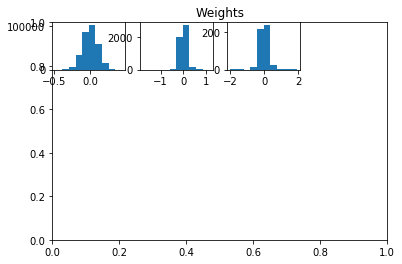

dW 0 Mean -2.4103047183 SD 12.2784023121
dW 1 Mean 5.77511366526 SD 323.008212849
dW 2 Mean -5.50023454016e-05 SD 1085.80629637


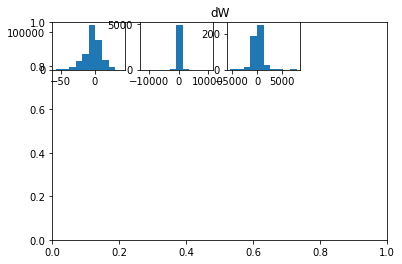

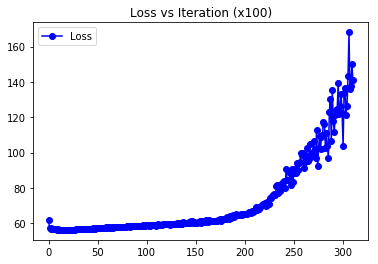

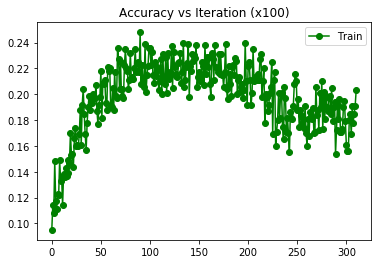

3101


3102


3103


3104


3105


3106


3107


3108


3109


3110


[0 8 0 6 9 0 6 6 4 0 6 8 1 0 0 0 6 0 3 6 0 8 2 2 6 4 6 9 0 0 0 4 0 9 6 0 8
 2 0 0 8 9 5 8 8 1 2 8 0 0 0 0 8 0 0 2 0 1 0 6 6 6 0 2 6 8 8 8 0 0 0 9 0 6
 0 0 0 2 0 3 0 6 0 0 2 0 4 0 0 6 8 0 2 6 0 6 6 9 0 0 2 2 0 8 0 0 2 6 0 0 0
 6 8 2 0 0 0 2 4 8 8 0 0 0 6 1 8 6 5 5 9 0 2 2 6 6 3 0 0 0 0 2 0 0 9 0 8 2
 4 6 0 2 8 2 4 0 0 0 2 0 8 0 5 0 0 2 0 8 9 0 9 2 4 0 0 0 0 6 4 0 9 8 2 3 0
 0 8 2 9 0 0 0 0 0 6 9 0 2 6 0 0 0 8 4 2 8 9 4 4 4 4 6 8 0 0 0 4 0 0 2 0 2
 0 4 4 0 8 2 0 2 0 0 8 6 0 0 0 8 6 0 0 0 0 6 2 2 4 3 0 0 2 1 0 0 8 0 6 8 0
 2 9 0 2 0 0 0 9 1 0 0 6 6 0 9 5 6 2 6 9 4 0 9 1 6 5 0 8 4 8 0 0 0 0 4 5 4
 0 2 0 5 6 0 0 2 6 6 0 0 0 0 6 1 0 0 0 6 0 4 0 4 2 2 0 0 0 8 0 6 0 4 0 4 0
 0 8 6 6 6 2 5 6 9 0 0 0 4 0 0 0 2 0 6 6 0 0 0 0 6 2 6 4 0 2 0 0 4 8 6 0 2
 0 0 5 0 2 8 9 0 4 0 0 4 9 8 2 9 5 0 2 0 8 0 6 8 9 0 0 0 0 0 8 8 9 4 6 8 6
 0 6 6 8 8 2 0 2 2 9 2 2 8 0 2 8 9 8 2 9 6 2 4 8 4 8 0 0 6 6 8 6 0 6 0 2 2
 0 0 6 6 6 6 6 6 1 8 0 0 0 8 0

3142


3143


3144


3145


3146


3147


3148


3149


3150


[4 9 7 7 0 4 7 7 0 0 7 7 0 4 0 0 7 8 0 7 0 4 0 2 7 9 0 4 0 0 7 0 0 4 7 7 7
 8 4 5 9 0 0 3 7 3 9 8 0 0 0 0 8 1 0 8 7 0 0 9 7 0 0 7 8 0 8 7 3 0 0 7 0 7
 0 7 0 8 0 0 0 7 0 7 7 0 4 2 7 0 3 0 7 7 2 7 0 8 7 8 0 0 8 7 0 4 8 7 2 7 0
 7 0 7 8 0 3 4 0 4 8 0 0 9 0 0 7 7 0 0 9 0 2 7 7 8 3 4 7 0 0 0 8 7 7 0 3 0
 0 7 0 0 7 7 0 5 0 0 0 7 0 0 2 0 2 7 0 7 7 0 9 7 7 0 4 0 0 7 4 9 7 0 7 0 4
 0 8 7 3 3 0 0 8 7 8 7 0 0 7 1 0 0 0 7 7 7 7 0 0 7 4 7 4 0 9 0 3 7 0 4 7 4
 2 4 4 0 1 0 4 0 0 5 9 4 5 0 0 7 7 3 0 0 0 7 2 2 4 0 0 0 0 8 4 0 7 1 7 7 2
 2 0 0 4 7 0 0 4 7 7 0 7 0 0 4 2 0 0 7 0 7 2 9 2 7 1 7 3 4 0 9 8 4 0 0 0 7
 0 4 9 3 8 0 0 8 8 7 0 0 0 6 3 0 7 1 7 7 0 7 7 9 4 8 8 0 0 4 8 4 0 4 7 0 0
 0 4 0 7 3 0 0 0 8 4 4 0 7 0 4 0 7 8 0 8 0 0 0 0 0 8 0 4 0 7 3 0 7 8 8 0 2
 4 0 7 3 7 4 9 4 4 2 7 9 0 0 7 4 0 4 7 7 7 0 7 4 9 0 7 9 0 0 0 8 0 0 7 8 8
 0 0 7 0 0 7 0 0 4 4 7 7 7 0 7 4 8 7 9 8 7 7 0 0 4 0 7 0 7 7 7 7 0 4 7 0 2
 0 0 0 8 7 7 4 7 4 7 0 0 7 8 0 2 2 8 

3182


3183


3184


3185


3186


3187


3188


3189


3190


[0 2 4 8 2 1 2 6 1 0 1 2 0 2 0 0 2 9 0 6 0 9 1 2 0 0 2 0 0 0 2 5 0 9 2 0 2
 4 0 9 0 4 0 0 6 0 2 8 0 2 0 0 0 0 3 2 6 0 0 2 6 9 0 0 9 0 4 6 0 3 9 2 4 2
 4 0 0 2 0 3 0 2 9 4 9 3 0 6 6 9 3 4 8 1 0 0 4 0 2 0 5 2 2 6 0 4 2 6 0 9 2
 2 4 2 8 0 2 2 2 4 9 2 0 9 0 0 0 0 0 5 4 0 2 1 0 2 3 0 6 0 0 0 4 4 2 0 0 0
 4 2 2 8 2 2 1 0 0 0 0 0 4 0 0 0 2 2 0 1 2 0 4 0 0 0 0 4 0 2 4 0 6 0 0 4 0
 0 6 2 6 0 0 0 0 9 6 2 0 0 2 1 0 4 0 4 2 2 0 0 4 6 4 4 4 0 0 0 4 2 0 8 9 8
 0 1 0 0 2 4 0 0 0 0 2 0 0 0 0 4 2 1 0 0 0 2 2 2 0 0 0 9 9 1 0 0 4 0 0 6 0
 0 9 0 4 0 0 3 0 2 4 0 1 9 0 1 0 9 2 9 3 0 0 9 6 2 0 8 0 4 4 4 0 0 0 0 0 4
 0 0 2 0 2 0 0 2 6 9 0 0 0 0 2 6 9 0 0 9 9 9 6 2 4 1 0 0 0 4 1 8 2 4 0 0 0
 0 2 2 0 1 1 0 0 1 0 1 0 6 0 2 0 9 0 0 8 0 6 0 0 6 8 4 6 0 2 9 0 0 0 2 1 2
 4 9 3 4 2 4 4 6 4 4 0 9 9 9 9 2 0 0 2 0 1 2 4 4 0 0 2 0 0 0 0 8 0 9 9 9 0
 4 6 2 0 9 8 0 2 1 2 0 2 6 0 2 6 6 2 8 6 0 0 9 0 0 4 1 0 2 4 6 6 0 4 1 2 8
 0 3 0 1 9 9 4 4 0 6 8 0 8 6 0 0 0 9 

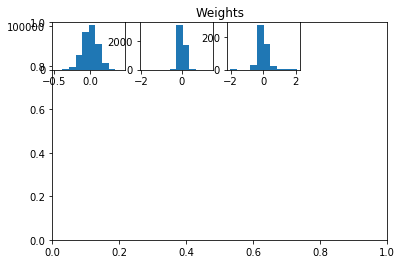

dW 0 Mean 0.276764404554 SD 9.05396436281
dW 1 Mean -8.32690792572 SD 200.959125128
dW 2 Mean -5.50305855722e-05 SD 1359.17649957


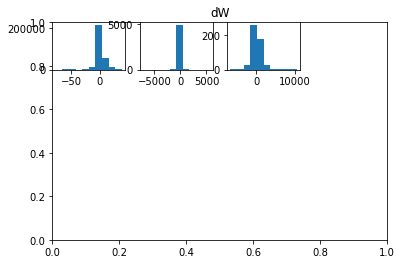

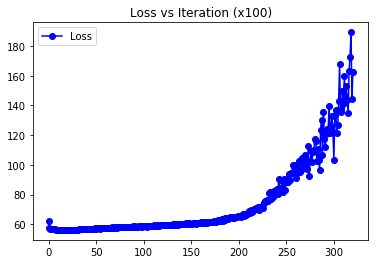

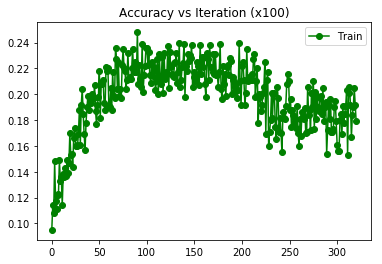

3201


3202


3203


3204


3205


3206


3207


3208


3209


3210


[0 2 0 4 1 0 8 2 0 0 0 2 0 2 3 0 8 2 9 0 0 9 2 2 3 2 2 2 0 0 0 0 0 2 1 0 2
 2 0 9 1 0 0 3 2 0 0 8 0 2 0 0 8 1 0 0 2 9 0 9 2 8 0 2 8 0 8 1 0 9 0 2 7 0
 9 0 9 0 0 0 0 0 0 0 9 9 0 0 2 2 3 0 2 2 0 2 9 8 8 8 0 2 2 0 0 2 2 8 0 2 0
 2 3 2 2 0 0 0 2 1 2 2 0 0 0 8 8 2 9 0 2 0 2 8 0 9 2 0 2 0 3 2 8 1 0 0 0 0
 6 0 3 8 2 2 1 0 0 0 2 0 0 0 0 0 0 2 2 1 2 0 6 0 3 0 0 3 1 0 0 3 1 2 8 5 0
 0 8 8 2 3 0 0 1 8 2 2 9 0 2 0 0 0 0 2 8 2 2 0 0 8 2 0 8 0 0 0 8 0 9 2 2 2
 0 2 3 0 2 2 0 0 0 0 2 2 9 0 0 2 9 0 0 7 0 2 2 0 2 0 0 0 0 1 0 0 0 0 2 2 5
 0 0 0 8 0 0 0 0 0 3 0 1 1 0 2 0 2 1 2 0 0 0 2 2 2 0 6 0 9 0 0 2 9 0 0 5 3
 0 0 1 0 2 0 0 1 7 2 0 0 0 0 0 0 0 1 0 2 8 1 0 3 0 8 1 0 8 2 8 8 0 6 0 0 0
 0 2 0 0 2 2 5 1 9 0 4 0 0 0 2 0 2 0 3 2 0 0 0 0 1 0 0 1 0 2 0 0 0 0 0 1 2
 0 2 2 2 2 3 0 0 0 0 0 3 2 0 1 0 0 0 2 0 0 0 2 2 2 8 2 0 0 0 0 8 0 2 1 6 0
 0 1 2 0 0 2 5 2 2 2 8 2 2 0 0 2 9 0 2 2 0 2 0 8 2 2 1 0 2 3 2 1 0 3 2 2 0
 0 0 8 2 1 8 2 2 2 8 1 0 8 0 0

3242


3243


3244


3245


3246


3247


3248


3249


3250


[0 7 4 4 9 0 7 7 9 7 7 1 0 7 0 0 7 7 9 7 0 4 7 7 4 4 7 7 0 0 0 0 0 4 7 0 7
 4 0 3 7 0 1 0 7 0 0 0 0 7 0 0 8 0 0 4 7 3 0 9 7 9 0 7 7 9 9 7 0 0 7 7 4 4
 0 7 0 7 0 3 4 7 1 0 8 0 1 0 8 9 3 0 7 1 7 7 0 9 8 9 0 4 7 7 0 8 7 7 9 7 0
 7 4 7 9 0 0 7 0 1 7 4 0 0 0 7 7 8 0 5 7 0 7 7 7 7 3 4 7 0 0 7 4 7 1 0 0 7
 4 7 6 9 7 7 4 0 0 0 7 9 9 0 0 5 0 9 0 8 9 0 9 1 8 0 4 0 4 7 4 0 1 0 7 0 4
 0 4 7 7 3 0 0 9 7 8 7 0 0 7 0 0 0 0 7 8 7 7 0 4 7 4 0 4 0 9 0 4 7 0 0 7 7
 0 7 4 0 1 4 0 0 0 0 7 0 0 7 4 7 7 7 0 0 0 0 7 0 7 0 0 9 9 0 1 1 7 5 7 1 0
 5 0 0 9 0 0 0 0 7 9 0 7 7 0 4 0 0 8 9 9 6 6 9 1 7 1 7 3 4 7 4 4 0 4 4 0 9
 0 7 7 0 7 0 0 7 7 7 0 0 0 0 7 7 7 0 0 0 7 1 7 4 7 7 4 0 9 4 0 7 7 7 7 4 0
 0 4 1 7 1 1 0 1 7 4 1 0 7 0 7 0 7 0 1 4 0 0 0 0 1 0 4 1 0 7 0 0 0 9 7 7 7
 4 4 7 7 7 4 0 1 0 0 7 9 1 8 7 4 0 0 7 7 7 0 0 7 7 7 1 0 0 5 0 8 0 4 7 7 4
 4 7 7 0 4 7 0 0 1 4 7 7 4 0 7 4 7 1 7 7 7 0 9 0 7 0 7 0 4 7 0 8 0 7 7 9 7
 0 0 9 7 7 0 1 9 4 7 3 4 1 7 0 0 6 7 

3282


3283


3284


3285


3286


3287


3288


3289


3290


[5 9 7 5 5 5 9 1 5 7 7 5 1 8 3 0 7 7 0 5 9 9 5 5 1 0 5 7 4 8 0 0 0 4 7 7 1
 7 4 0 1 0 1 0 5 0 5 8 0 7 0 0 8 4 0 5 8 3 0 5 9 5 0 8 1 7 8 5 9 0 0 5 0 8
 0 9 0 9 0 0 0 5 0 7 9 4 5 5 5 8 9 0 7 5 7 7 7 0 7 9 5 5 9 9 0 5 5 8 3 7 5
 5 4 1 8 0 5 5 0 5 8 5 0 0 7 5 5 8 0 0 5 0 8 1 0 8 0 0 0 0 0 0 5 9 5 0 0 0
 0 9 0 8 7 5 1 7 0 0 5 0 0 0 0 0 5 7 0 5 5 8 5 5 5 0 5 5 1 7 5 5 5 8 7 0 0
 0 7 7 5 0 0 0 5 7 7 5 0 0 5 0 0 5 5 5 7 7 9 5 0 5 1 9 5 0 5 5 5 7 0 5 5 9
 0 1 5 7 8 9 0 0 5 0 7 5 0 5 5 5 7 7 0 7 0 7 8 0 5 4 0 5 9 8 0 0 0 0 8 1 0
 5 5 5 5 0 0 0 0 9 5 0 7 9 0 9 0 9 7 5 0 5 7 5 7 7 0 9 5 7 7 5 5 0 8 0 0 9
 0 0 7 0 7 5 4 8 9 5 0 5 0 0 5 8 5 0 5 8 9 5 7 5 1 7 5 0 9 0 8 5 5 9 5 0 5
 0 9 0 5 5 7 0 1 9 0 4 0 5 8 0 9 5 0 1 9 0 5 0 0 8 7 5 4 0 5 5 5 0 0 5 7 9
 5 9 0 5 1 5 9 9 9 0 5 5 5 8 9 8 0 0 7 5 1 4 9 9 5 5 1 5 0 0 9 8 0 5 5 5 7
 4 5 9 8 9 5 0 9 5 5 5 8 5 5 7 5 9 7 9 5 7 7 9 9 9 9 7 5 5 7 5 5 0 5 5 9 9
 0 0 9 7 5 9 8 9 5 5 8 9 5 5 0 0 7 7 

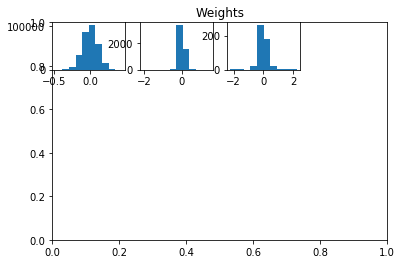

dW 0 Mean 2.11055599512 SD 10.3251371076
dW 1 Mean -5.80069946832 SD 160.190885643
dW 2 Mean -5.49451847692e-05 SD 1101.29228568


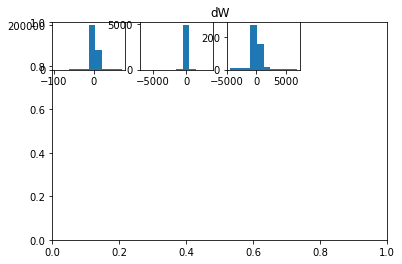

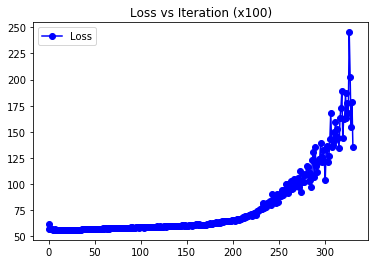

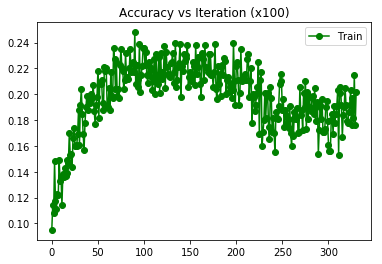

3301


3302


3303


3304


3305


3306


3307


3308


3309


3310


[5 6 8 5 5 9 5 8 4 0 0 4 3 8 3 4 5 4 0 0 4 4 6 0 4 0 1 9 0 9 0 0 4 4 9 4 6
 1 0 0 4 0 0 0 4 0 0 8 0 0 1 0 0 4 0 9 8 0 0 4 6 5 0 4 4 0 9 0 0 0 0 9 4 4
 9 0 0 5 0 3 0 5 0 0 5 0 4 6 1 8 3 3 0 4 0 6 6 0 4 9 0 5 8 9 0 1 5 6 0 4 0
 5 0 1 6 0 0 0 8 4 9 4 0 0 0 5 5 5 0 0 4 0 0 5 0 6 0 1 0 0 0 0 5 1 0 0 0 5
 4 5 6 5 5 5 4 0 0 0 0 0 9 0 0 0 0 6 5 8 9 0 5 5 4 0 5 0 4 5 0 5 4 0 3 0 4
 0 4 5 6 6 0 0 5 5 0 9 0 0 6 0 4 4 0 5 8 6 4 0 4 5 4 4 4 9 0 2 9 8 0 0 6 5
 0 1 5 0 6 4 0 0 0 0 6 5 0 4 0 4 9 1 0 7 0 6 0 6 4 0 9 0 3 6 0 0 9 5 5 1 0
 8 9 5 4 0 0 0 0 5 5 0 5 5 0 1 5 0 6 4 6 6 0 9 4 4 0 5 5 1 4 0 5 9 0 0 0 4
 0 4 8 0 6 4 0 0 4 1 0 0 0 0 5 5 8 0 0 0 5 9 5 5 4 1 1 0 9 4 8 4 5 9 5 0 0
 8 6 6 4 1 1 0 1 8 1 0 0 6 0 1 0 1 0 5 9 0 4 0 0 0 1 4 4 0 5 5 9 0 5 5 5 4
 4 0 0 9 4 4 9 6 4 9 4 9 4 8 9 4 0 3 6 5 1 6 5 9 9 8 5 5 0 0 0 0 0 5 5 5 4
 4 5 4 0 0 5 0 6 5 5 4 4 1 0 4 4 9 5 3 5 0 0 9 0 9 9 8 0 0 9 4 1 0 4 6 5 0
 0 3 5 6 5 4 4 6 4 6 8 0 1 9 3

3342


3343


3344


3345


3346


3347


3348


3349


3350


[6 7 3 5 3 5 7 7 9 0 7 9 1 7 9 0 7 3 0 7 9 3 7 7 3 0 3 9 0 0 0 3 0 9 0 3 9
 1 0 0 8 0 1 3 7 0 7 8 0 7 3 3 0 4 9 7 7 0 5 3 7 9 0 0 3 0 8 5 0 3 7 6 3 9
 0 8 0 3 0 0 4 0 0 5 3 0 0 0 7 1 9 0 8 7 0 7 6 0 7 7 2 3 0 7 0 3 8 9 0 7 7
 9 8 1 3 0 0 5 7 3 3 3 0 3 0 3 3 7 1 0 7 0 0 6 3 3 0 3 7 0 0 0 5 7 3 0 3 0
 3 9 9 7 6 7 3 7 0 0 6 0 9 0 2 0 0 9 5 5 9 3 5 3 0 3 3 3 0 7 5 0 6 0 8 0 0
 0 3 3 7 3 0 0 3 9 7 7 0 0 3 0 0 0 0 8 3 7 7 7 6 3 6 5 6 3 0 5 7 8 0 7 7 9
 9 7 3 0 6 9 0 0 0 0 0 5 0 3 5 1 9 3 0 0 0 3 7 6 7 0 0 3 3 7 1 0 8 0 6 7 2
 5 0 3 3 0 0 0 0 3 3 0 9 0 0 9 0 3 7 6 0 0 0 7 1 7 0 7 0 8 7 5 6 0 0 0 0 3
 3 2 1 6 7 5 0 7 7 3 0 0 0 0 3 5 6 1 0 3 5 0 7 3 9 0 0 0 9 3 8 3 3 3 7 9 0
 3 9 9 3 3 0 0 5 9 0 0 0 7 0 3 0 9 0 3 3 0 3 3 0 3 8 6 3 0 7 3 5 0 3 7 0 7
 5 3 0 7 3 3 8 6 3 9 3 9 3 0 9 9 1 0 7 7 0 0 3 3 7 7 7 0 0 0 3 0 0 7 3 7 7
 3 5 7 0 9 7 0 7 3 7 6 0 9 0 7 3 3 7 3 7 0 7 3 3 0 9 6 0 5 8 6 3 0 0 1 7 9
 0 9 3 7 6 9 3 9 3 3 3 0 7 3 9 0 0 3 

3382


3383


3384


3385


3386


3387


3388


3389


3390


[6 6 6 6 3 9 6 6 1 0 6 6 0 6 6 0 6 6 0 6 3 6 6 8 6 0 6 1 0 0 3 0 0 6 6 6 6
 6 0 0 6 0 1 0 8 0 6 8 0 6 3 3 3 3 3 8 6 0 0 6 6 6 0 8 6 6 8 6 0 3 3 8 6 9
 0 6 9 3 6 0 0 8 3 6 6 0 6 0 6 6 3 3 6 1 0 6 1 8 1 8 0 3 3 6 0 3 3 6 0 6 0
 6 1 1 6 6 0 6 3 6 8 6 0 0 0 3 6 6 0 0 6 0 2 8 6 6 0 0 6 0 0 8 6 6 1 0 0 3
 6 6 1 1 6 3 6 0 0 0 6 3 8 0 3 0 0 8 1 1 8 6 1 6 1 0 6 6 1 6 1 3 1 3 6 0 0
 3 8 3 8 0 0 1 3 6 6 8 0 0 6 0 0 8 0 3 6 8 3 2 8 6 6 0 6 3 6 5 8 3 0 8 6 6
 0 3 6 0 6 6 0 0 0 0 6 0 0 8 6 6 1 1 0 0 0 6 6 0 6 0 0 0 8 6 1 9 2 0 6 6 0
 6 6 9 6 6 0 0 0 1 6 3 6 6 0 6 0 6 6 6 0 6 0 1 1 6 0 6 6 8 6 0 6 0 8 6 0 6
 3 0 1 0 6 1 0 6 6 6 0 0 0 0 1 6 6 0 0 6 1 6 6 6 1 8 0 9 0 1 8 1 3 6 6 3 0
 6 6 3 6 8 6 0 8 6 1 0 0 8 0 1 8 6 6 6 6 0 6 3 0 6 8 6 6 0 6 0 9 0 8 6 6 6
 6 6 0 3 6 6 1 6 0 0 6 6 6 8 6 9 4 0 1 6 1 0 8 9 6 1 6 6 0 3 0 8 8 6 8 8 1
 6 6 6 8 1 6 0 6 6 3 6 6 6 6 6 1 6 1 6 6 6 9 3 1 3 8 6 0 8 6 8 6 0 1 6 1 6
 3 3 6 6 6 8 6 6 1 6 8 0 6 6 0 0 0 6 

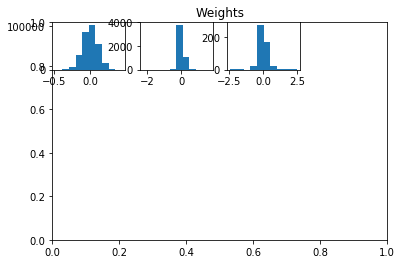

dW 0 Mean -1.66029478527 SD 18.1002722651
dW 1 Mean 3.92320675874 SD 341.011413784
dW 2 Mean -5.50637325359e-05 SD 1378.2783838


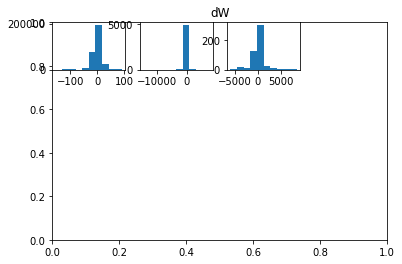

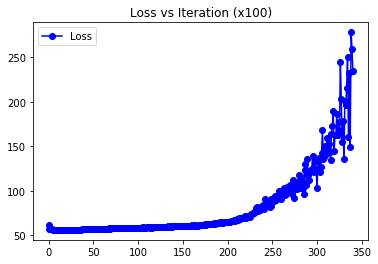

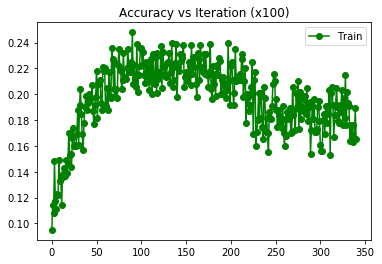

3401


3402


3403


3404


3405


3406


3407


3408


3409


3410


[0 8 3 8 1 1 1 1 0 0 1 3 0 0 3 0 1 0 0 1 3 3 1 1 3 0 1 0 0 0 0 0 0 0 1 3 1
 1 0 0 9 0 1 3 8 0 0 8 0 4 0 0 8 0 0 1 1 0 0 5 3 3 0 1 1 3 8 5 0 0 0 5 1 0
 0 0 0 1 0 0 1 0 0 1 3 0 5 0 0 5 1 0 8 1 0 1 3 0 4 8 0 5 1 1 0 0 3 8 0 9 0
 5 0 1 0 0 0 1 3 1 3 0 0 0 0 1 0 1 0 0 0 0 8 8 3 8 0 3 0 0 0 0 8 0 0 0 1 5
 1 9 0 1 5 3 1 0 0 0 1 0 3 0 2 0 5 1 5 1 3 0 9 5 3 3 3 3 0 0 5 0 1 3 0 0 0
 0 8 0 3 0 0 1 8 3 1 1 1 0 3 0 0 5 0 3 3 1 3 0 0 8 3 0 1 9 0 0 1 3 0 1 9 3
 9 1 3 0 1 0 0 4 0 0 0 5 0 8 1 5 0 1 0 0 0 1 8 0 3 0 0 0 0 3 1 3 5 0 1 1 0
 0 0 1 3 0 0 5 9 8 8 0 3 3 0 3 0 3 3 3 9 9 0 5 1 3 0 8 8 3 1 0 0 0 3 0 0 3
 0 3 0 5 3 5 0 3 3 1 0 0 0 0 8 1 1 1 0 3 5 5 3 0 1 0 9 0 0 3 8 1 0 8 0 0 0
 3 0 1 3 3 1 9 1 1 1 1 0 3 0 1 3 3 0 3 3 0 3 0 0 0 0 5 3 0 3 3 0 0 0 5 1 1
 5 5 0 3 3 0 3 1 0 0 9 5 3 8 1 0 0 0 3 0 1 0 3 0 3 1 1 9 0 0 3 8 0 3 1 9 0
 0 1 0 8 0 3 5 3 1 1 3 8 5 0 8 3 3 5 1 3 0 1 3 0 3 3 8 0 0 1 8 0 0 1 1 8 3
 0 0 3 3 1 8 3 1 1 8 3 9 5 8 9

3442


3443


3444


3445


3446


3447


3448


3449


3450


[5 9 1 5 5 5 5 9 6 0 6 6 0 7 0 0 6 0 5 0 9 6 6 5 6 0 6 8 0 0 0 0 0 6 1 5 9
 1 0 0 6 0 0 6 9 0 0 9 0 0 5 0 8 0 3 5 6 0 0 5 6 5 0 6 6 6 0 5 0 5 0 5 7 6
 0 0 9 9 6 0 9 5 0 6 6 7 6 0 9 5 5 0 7 6 0 6 6 9 8 0 0 1 7 6 0 5 5 8 7 6 5
 6 0 6 6 0 0 0 7 6 5 6 0 9 0 8 9 9 0 0 6 0 5 5 6 9 0 0 7 0 9 0 5 6 1 5 0 5
 5 5 6 5 7 7 6 0 0 0 6 9 0 0 7 9 6 6 5 1 9 0 9 5 1 0 0 0 0 5 0 0 6 9 7 2 0
 0 9 7 6 0 9 0 5 5 1 6 9 0 6 6 7 5 0 5 9 6 7 6 6 5 1 9 6 0 0 0 5 7 0 0 5 9
 5 5 5 0 6 5 0 6 0 0 6 5 0 0 0 6 7 6 0 7 5 6 7 0 0 0 0 0 9 1 1 0 7 0 8 5 0
 6 9 9 9 0 6 0 0 5 6 0 6 7 0 9 0 5 1 5 6 0 0 9 6 6 0 7 5 1 0 9 0 0 0 0 0 1
 0 2 6 0 5 0 0 6 6 5 0 9 0 0 0 5 7 1 0 6 5 9 6 9 1 0 5 5 0 7 0 6 5 6 6 7 0
 6 6 6 6 6 7 9 6 6 0 0 0 6 0 8 0 6 0 0 8 0 6 0 0 7 8 6 6 0 0 5 0 4 9 0 6 9
 6 9 0 0 6 0 5 6 0 0 6 5 6 9 1 7 0 0 5 5 7 0 5 7 5 7 6 5 0 0 9 0 0 5 5 6 9
 6 6 7 0 5 6 0 6 8 5 6 1 6 5 6 5 6 0 9 9 0 6 5 0 5 9 6 5 6 6 0 5 0 5 5 5 9
 0 9 5 6 1 9 6 9 5 6 5 0 6 9 0 5 0 9 

3482


3483


3484


3485


3486


3487


3488


3489


3490


[2 6 6 5 3 9 8 2 8 6 9 8 0 2 9 0 8 6 0 8 8 6 6 6 8 0 9 8 0 0 0 2 0 9 6 6 6
 6 0 0 6 0 1 0 8 0 8 8 0 6 0 0 0 0 0 6 8 0 0 6 6 8 0 6 6 8 8 8 3 2 9 6 6 9
 0 2 0 2 6 0 8 2 0 6 6 0 9 2 6 6 6 0 6 6 0 6 6 0 8 9 0 0 9 6 0 2 9 6 0 6 0
 2 6 6 6 6 0 6 3 6 6 0 0 9 0 8 9 8 0 0 6 0 8 6 9 8 0 0 0 0 0 9 0 9 6 0 9 0
 6 6 9 8 2 0 6 0 0 0 6 0 9 0 0 0 0 9 0 8 9 8 9 2 6 0 6 6 0 6 0 0 9 8 8 0 0
 0 6 3 6 0 0 0 0 6 6 9 0 0 6 1 0 0 0 8 6 6 9 0 0 6 0 6 6 0 0 0 9 3 0 2 6 9
 0 2 3 0 8 9 0 6 9 5 6 6 6 8 6 6 6 6 9 0 0 6 2 0 6 0 0 0 9 6 5 9 9 0 6 8 0
 6 0 8 6 0 6 0 0 2 6 0 6 6 0 9 0 0 2 6 0 6 0 9 6 6 6 6 8 9 2 9 9 0 6 2 0 9
 9 0 9 1 6 0 0 8 6 6 0 0 0 0 6 6 9 1 0 8 9 6 6 6 9 6 0 0 0 2 8 8 9 8 8 0 0
 6 9 6 6 8 6 0 6 8 9 1 0 6 8 3 0 6 8 6 6 5 6 0 0 8 6 6 3 0 6 0 0 0 0 6 6 8
 0 6 0 0 6 6 9 6 0 0 0 2 6 8 9 9 6 0 9 6 8 0 0 9 6 2 6 0 0 0 0 0 9 9 6 6 8
 6 8 6 8 9 6 5 6 2 8 8 6 6 9 6 6 0 6 6 6 6 9 9 8 0 8 8 0 6 6 6 9 0 6 6 9 9
 0 0 6 8 9 6 9 6 9 9 9 0 6 9 9 0 0 9 

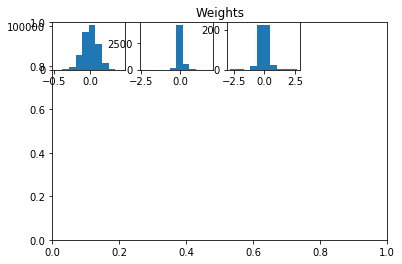

dW 0 Mean 3.16319432399 SD 15.0392985957
dW 1 Mean -1.84028203292 SD 461.010569647
dW 2 Mean -5.51345333224e-05 SD 2866.70224302


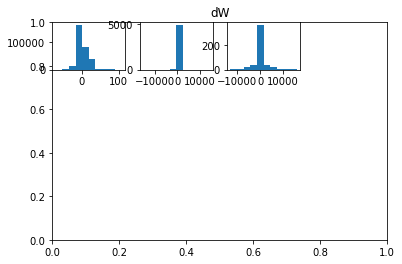

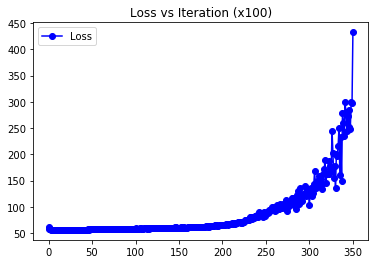

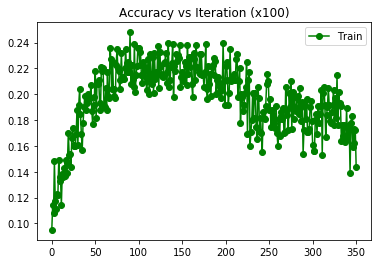

3501


3502


3503


3504


3505


3506


3507


3508


3509


3510


[0 8 7 7 1 0 7 7 6 0 8 7 0 7 8 0 1 7 9 1 0 0 1 7 8 0 7 8 0 0 0 0 0 0 7 1 7
 1 0 0 8 0 1 0 8 0 7 8 0 0 1 0 8 0 0 8 7 0 0 8 7 8 0 6 7 7 8 7 0 9 7 6 6 8
 0 8 9 7 0 3 0 0 0 9 7 7 8 0 6 7 0 0 8 1 7 6 7 0 7 8 0 9 8 6 0 1 9 8 0 0 0
 7 6 7 6 0 0 0 7 6 9 0 0 1 0 7 7 9 0 0 8 0 7 8 1 9 0 1 7 0 0 0 7 1 7 0 0 0
 6 0 2 1 7 7 1 0 0 0 0 0 0 0 0 6 0 8 0 7 7 0 1 7 1 0 6 0 0 7 0 1 7 0 7 5 0
 0 7 7 6 0 0 0 8 7 6 8 0 0 6 0 0 8 8 7 6 7 7 0 7 7 8 0 7 8 0 0 7 7 0 7 7 9
 0 0 1 0 7 9 0 0 0 0 7 7 0 8 0 6 9 9 0 0 0 7 8 6 7 0 0 0 7 1 0 0 7 3 6 8 0
 0 0 0 6 0 0 0 2 7 7 0 6 1 0 1 5 9 6 6 0 0 0 8 1 6 6 7 0 7 7 0 0 0 0 0 0 8
 0 7 1 0 0 0 0 7 9 6 0 0 0 0 7 1 1 0 0 7 9 7 7 9 1 1 0 0 0 9 8 1 7 6 8 0 5
 0 8 1 8 1 9 0 8 9 1 0 0 9 0 7 0 1 0 1 7 0 0 0 0 7 8 0 8 0 7 9 8 0 8 7 6 7
 9 6 0 9 1 8 6 9 0 0 0 0 2 8 7 7 0 7 1 6 7 0 0 7 6 7 7 0 0 0 0 0 0 7 1 9 6
 0 6 7 8 7 6 6 7 6 9 8 1 9 0 7 8 9 8 2 0 0 1 9 8 0 8 7 0 0 7 7 1 0 8 6 7 7
 0 0 0 8 8 8 1 7 2 8 8 0 6 8 0

3543


3544


3545


3546


3547


3548


3549


3550


[1 2 2 6 1 5 2 8 1 2 6 2 0 2 8 0 6 2 3 1 4 2 6 2 4 4 8 2 0 0 3 3 0 2 2 5 2
 2 0 3 2 0 3 1 8 3 2 8 3 6 0 3 8 3 3 8 6 3 0 2 6 8 0 8 2 6 8 6 3 0 9 2 1 2
 3 0 0 8 6 0 2 2 0 5 2 3 2 4 1 2 1 0 2 2 3 2 8 0 2 8 2 2 2 2 0 2 8 2 3 2 0
 2 4 8 8 0 3 2 2 5 2 2 0 1 0 8 5 8 3 3 2 3 2 2 0 2 3 1 2 0 6 2 8 6 2 0 2 0
 5 2 2 2 2 2 2 3 0 0 2 0 0 0 0 3 0 8 0 8 9 2 1 1 1 3 6 5 0 2 2 1 2 0 2 0 3
 4 2 2 2 3 4 2 5 2 2 6 0 0 2 0 0 0 0 8 2 2 2 3 0 5 8 2 5 0 0 3 8 2 3 2 9 2
 4 2 1 3 8 0 4 0 0 0 2 8 0 0 0 8 1 2 0 0 3 2 2 2 8 3 9 5 8 2 0 3 2 3 2 2 3
 2 0 0 2 0 0 3 2 1 8 0 2 2 3 6 3 5 2 6 0 0 4 1 1 8 3 1 8 4 2 4 2 0 8 3 3 4
 0 0 6 3 2 0 0 8 1 2 0 4 0 2 2 5 9 3 2 2 2 5 1 9 2 1 1 8 1 2 8 2 2 1 2 0 0
 0 2 2 5 2 1 0 1 2 0 2 3 2 0 2 0 8 0 5 2 0 2 8 0 2 8 2 1 0 2 5 2 0 8 2 1 8
 6 2 0 0 1 2 5 2 0 0 8 2 2 8 2 2 4 3 2 0 2 0 0 9 8 2 2 0 0 0 9 8 0 2 5 8 6
 0 5 2 8 5 2 3 8 2 2 2 1 2 0 2 2 2 2 1 2 2 2 9 8 0 2 2 0 2 8 8 5 0 6 2 5 2
 3 3 0 1 1 4 1 2 5 2 6 0 1 8 3 0 6 8 2 3 0 0

3583


3584


3585


3586


3587


3588


3589


3590


[0 3 3 5 3 7 7 7 3 7 7 0 0 0 3 0 7 0 9 3 3 3 7 7 3 0 0 0 0 0 0 0 0 0 7 0 7
 7 0 3 0 9 0 0 7 5 0 0 0 0 3 0 8 1 0 0 7 0 0 0 0 3 0 7 9 0 8 0 0 3 3 7 0 7
 0 7 0 0 3 0 0 0 0 0 3 0 0 0 0 0 3 0 0 7 9 7 7 0 7 0 7 3 8 3 0 3 3 7 3 3 0
 7 3 7 0 0 0 0 7 3 3 0 0 3 0 0 3 3 3 0 7 0 8 3 3 3 0 1 0 0 9 3 0 7 3 0 3 0
 7 7 3 7 0 0 3 0 0 0 0 0 0 0 3 0 0 7 0 5 9 0 9 0 3 0 3 0 0 0 2 3 7 3 8 9 0
 3 8 3 3 0 9 3 0 0 7 0 0 0 0 1 0 0 0 3 7 8 0 5 3 7 3 3 0 3 3 0 0 0 0 0 0 1
 0 1 3 0 7 3 0 0 0 0 0 7 0 0 0 7 3 0 0 7 0 0 7 0 7 0 0 3 3 7 0 0 0 0 0 7 3
 0 0 0 7 0 0 0 0 7 8 0 8 7 9 9 0 3 7 7 0 0 0 9 0 7 0 0 0 3 0 7 0 0 0 0 5 7
 0 0 1 0 3 7 0 0 7 3 0 0 0 0 0 7 7 1 0 0 0 7 3 3 7 7 5 0 0 0 3 7 3 8 0 0 5
 0 0 3 3 3 0 0 5 3 0 4 0 3 0 0 3 7 0 3 0 0 0 0 0 0 7 0 3 0 7 3 0 0 0 7 0 7
 0 3 0 3 7 3 3 0 0 0 3 3 2 8 0 0 0 9 0 7 2 9 3 0 7 7 3 0 0 3 0 0 0 7 9 7 7
 0 0 0 3 0 7 5 7 8 0 8 0 3 0 7 3 3 7 7 7 0 3 0 7 0 0 7 0 7 7 3 3 9 0 7 9 3
 9 9 3 7 0 0 2 9 3 9 3 0 7 0 9 0 7 3 2 0 3 0

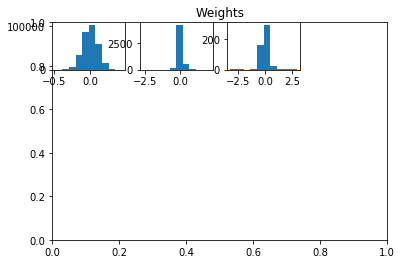

dW 0 Mean -9.80133766943 SD 39.9487991847
dW 1 Mean -16.5662381894 SD 647.989125085
dW 2 Mean -5.50720939864e-05 SD 2566.92454818


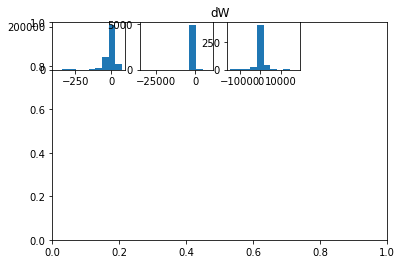

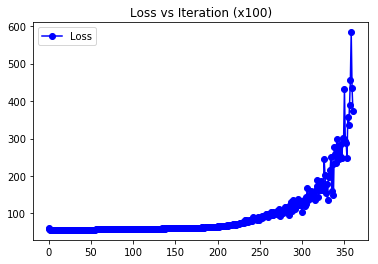

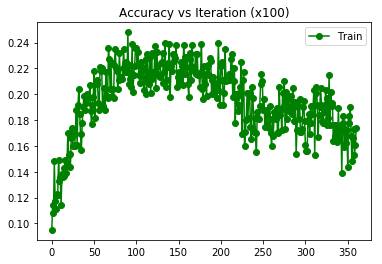

3601


3602


3603


3604


3605


3606


3607


3608


3609


3610


[0 8 6 4 7 4 9 6 9 6 6 6 6 0 1 0 6 7 3 0 0 9 6 0 0 0 8 8 0 0 0 0 0 9 6 0 9
 4 0 0 9 4 0 0 8 3 6 0 0 6 0 0 8 0 0 7 6 3 5 6 8 0 0 6 8 0 8 6 0 0 9 8 0 9
 0 8 0 4 0 0 4 6 0 8 6 0 6 0 9 6 9 4 6 6 6 0 6 0 7 8 0 9 1 6 0 4 7 6 0 6 0
 6 0 6 8 0 0 0 0 6 9 0 0 9 4 0 0 8 4 5 6 0 0 6 0 0 0 0 0 0 0 0 8 9 6 0 9 7
 6 0 9 8 0 0 0 0 0 0 0 0 9 0 0 5 7 6 0 8 9 6 9 6 8 0 6 4 0 0 0 0 8 0 8 0 0
 0 8 0 0 6 0 0 0 6 6 6 0 0 0 4 0 0 0 8 7 6 9 0 0 0 6 6 0 9 0 0 4 9 0 0 0 6
 0 4 6 0 6 7 0 0 0 4 0 0 0 0 4 8 9 6 0 0 0 0 6 0 0 4 0 0 8 8 0 0 7 0 6 6 6
 0 0 8 6 0 0 0 0 0 8 0 8 7 0 9 0 0 6 9 0 6 0 6 6 6 0 1 8 9 6 4 0 0 8 0 5 0
 0 0 8 6 6 0 0 0 9 6 0 0 0 6 7 6 6 1 0 0 9 6 0 9 9 0 9 0 0 0 8 6 0 6 0 0 0
 6 0 9 0 6 8 0 8 8 9 0 0 8 0 7 8 6 0 0 6 0 6 0 0 6 0 6 1 0 9 9 9 0 0 6 7 6
 0 6 0 0 6 9 0 8 0 0 0 6 9 8 6 9 0 0 9 8 1 0 6 4 6 4 6 6 0 0 8 0 0 0 9 8 8
 0 0 6 0 0 0 0 0 6 0 0 8 8 0 0 6 0 0 9 6 0 6 4 0 9 7 8 0 0 6 0 9 0 9 1 8 6
 0 0 9 6 6 8 6 6 9 6 0 0 6 0 0

3643


3644


3645


3646


3647


3648


3649


3650


[2 2 2 7 2 7 8 2 1 6 2 8 4 2 0 2 1 2 3 7 7 2 2 2 7 2 2 8 9 2 3 3 0 8 2 7 8
 2 3 3 2 0 3 8 8 3 2 8 3 2 0 3 8 3 3 2 8 4 5 2 2 8 0 2 2 7 8 2 3 3 9 2 1 2
 5 2 0 2 0 3 2 2 7 1 2 3 2 0 2 2 9 3 2 8 3 2 1 2 2 7 3 2 2 2 3 2 7 1 3 2 2
 8 0 2 2 0 3 2 2 7 2 2 0 2 0 2 9 2 3 5 2 3 8 2 8 2 3 2 2 0 3 2 2 7 2 0 2 2
 1 2 8 2 2 2 2 7 0 0 8 2 2 0 5 3 0 1 2 2 2 2 1 2 7 3 5 0 2 2 2 8 2 2 7 7 3
 0 8 2 2 3 0 2 8 2 2 2 0 0 2 0 4 0 7 2 8 2 2 0 8 2 2 2 7 9 7 0 2 2 0 2 9 2
 3 2 2 3 2 2 0 0 0 0 2 2 0 7 7 2 2 2 0 0 3 8 8 0 2 7 0 3 2 1 3 0 2 3 2 2 0
 2 9 8 2 0 2 5 0 2 8 0 2 2 3 1 0 2 2 2 3 0 0 2 2 2 3 7 8 7 2 5 2 0 2 3 3 7
 8 0 2 3 2 8 3 2 7 8 0 2 0 3 8 8 7 3 0 2 9 7 7 2 8 2 9 0 2 0 8 2 2 1 8 2 5
 0 2 1 7 2 2 0 1 2 1 7 0 2 2 1 0 8 7 8 2 0 2 0 0 2 2 1 1 0 2 8 8 0 0 2 8 2
 2 2 3 2 8 2 5 1 0 0 2 8 2 8 2 2 3 3 2 2 2 0 8 2 2 2 2 2 0 0 2 8 0 2 8 2 1
 2 7 2 8 2 2 3 2 2 2 8 8 2 9 2 2 2 2 2 2 2 8 7 8 2 8 8 0 2 7 2 7 0 7 2 8 2
 7 3 2 2 2 2 2 2 2 2 7 2 2 8 3 0 0 2 2 6 5 2

3683


3684


3685


3686




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:217: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:224: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in maximum
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in less_equal


3687


3688


3689


3690


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

ValueError: max must be larger than min in range parameter.

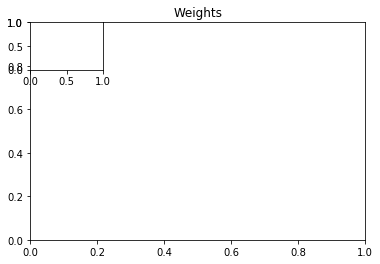

In [493]:
NN2 = NeuralNetwork(layer_dimensions, drop_prob=.25, reg_lambda=.01)
NN2.train(X_train, y_train, iters=50000, alpha=0.00001, batch_size=1000, print_every=10)

In [ ]:
y_predicted2 = NN2.predict(X)
save_predictions(y_predicted, 'ans2-uni')